# <ins>**Notebook 1**</ins>: **Consolidación de Base de Precios**

### **<ins>Propósito</ins>**

Este notebook tiene como objetivo **<ins>consolidar las bases de datos originalmente elaboradas por el</ins>** **<ins>SIPC</ins>** *(Sistema de Información de Precios al Consumidor)* **<ins>de forma anual</ins>**, a fin de **generar una <ins>única base de precios para la totalidad del período en estudio</ins>:** ***Enero 2021 - Junio 2024***, imponiendosé diversos criterios de selectividad y completando faltantes en caso de haberlos.

---

### **<ins>Objetivos</ins>**

- **<ins>Consolidar en un solo dataframe la totalidad de bases de datos</ins> refentes al periodo estudiado**: *Enero 2021 - Junio 2024*
- **</ins>Establacer y ejecutar un proceso de depuración<ins>** sobre los datos obtenidos con el objetivo de poder consolidar una base de datos con la calidad suficiente que permita, a posteriori, la conformación de bases de ¨Price Spells*, las cuales serán utilizadas para la modelización en Machine Learning y Survival Machine Learning
- **<ins>Efectuar un pequeño analisis estadísitico<ins> sobre las bases formuladas** a fin de poder conocer sus caracteristicas y difencias principales.

---

### **<ins>Archivos necesarios</ins>**

1. **<ins>establecimiento.xlsx</ins>** -> Listado de establecimientos en base
2. **<ins>productos.csv</ins>** -> Listado de productos en base
3. **<ins>productos (Rubros y Categorías).csv<ins>** -> Contiene los Rubros y Categorias asociados a cada uno de los productos en base
4. **<ins>precios_2021.csv<ins>** -> Contiene la totalidad de precios de productos reportados por el SIPC para la totalidad del pais en 2021
5. **<ins>precios_2022.csv<ins>** -> Contiene la totalidad de precios de productos reportados por el SIPC para la totalidad del pais en 2022
6. **<ins>precios_2023.csv<ins>** -> Contiene la totalidad de precios de productos reportados por el SIPC para la totalidad del pais en 2023
7. **<ins>precios_2024.csv<ins>** -> Contiene la totalidad de precios de productos reportados por el SIPC para la totalidad del pais en el primer semestre del 2024

---

### **<ins>Archivos generados</ins>**

1. **<ins>df_precios_montevideo_2021_2024_C.feather</ins>** -> Base con la totalidad de precios sin agrupar de los pares establecimiento-producto en Montevideo para el periodo Enero 2021 - Junio 2024 que cumplen con las restrcciones establecidas en el presente Notebook.

---



# **0. Librerias**

In [ ]:
## INSTALACIÓN DE BIBLIOTECAS ##

# Instalamos las bibliotecas necesarias
!pip install openpyxl xlrd
!pip install folium

In [ ]:
## CARGA DE LIBRERÍAS ##

import pandas as pd #pandas
import os #os
import matplotlib.pyplot as plt #matplotlib
import seaborn as sns #seaborn
import folium # Mapa Interactivo
import warnings  # warnings
from tqdm import tqdm # Tqdm
from datetime import datetime # Datetime
import ipywidgets as widgets #Widgets
from IPython.display import display #Display
from tqdm.notebook import tqdm # Timer
from collections import defaultdict #DefaultDict
import numpy as np #Numpy

In [ ]:
## OTROS ##

# Desactivación de warnings
warnings.filterwarnings('ignore')

# **1. <ins>Conformación base de datos Precios</ins>** *(Enero 2021 - Junio 2024)*

## **1.1  <ins>Referencias</ins>**: *Establecimientos y Productos*

In [ ]:
## CARGA DE BASES DE REFERENCIAS ##

# Cargamos de base 'productos', 'establecimientos' y 'productos (Rubros y Categorías)'
productos = pd.read_csv('productos.csv', encoding='latin1', delimiter=';')
establecimientos = pd.read_excel('establecimientos.xlsx')
productos_categorias_rubros = pd.read_csv('productos (Rubros y Categorías).csv', encoding='latin1', delimiter=';')


# Aseguramos que los nombres de las columnas coinciden
if 'id.producto' in productos.columns and 'id.producto' in productos_categorias_rubros.columns:
    # Hacemos merge entre productos y productos_categorias_rubros a través de id.producto
    productos = pd.merge(productos, productos_categorias_rubros, on='id.producto', how='left')

    # Reordenamos las columnas
    productos = productos[['id.producto', 'rubro', 'categoria', 'producto', 'marca', 'especificacion', 'nombre']]

    # Renombramos columnas
    productos = productos.rename(columns={'rubro': 'Rubro', 'categoria': 'Categoria'})

establecimientos.head(5)

,id.establecimientos,razon.social,nombre.sucursal,direccion,ccz,barrio,cajas,cadena,long,lat,ciudad,depto,id.depto,localidad,superficie (m2),Cadena (Nuevo Criterio),Tipo Establecimiento
0,65,Devoto Hermanos S.A.,Devoto - SAYAGO,Camino Ariel 4626,13.0,Sayago,29,Devoto,-34.836390,-56.211492,Montevideo,Montevideo,1,1020,NaN,Devoto,Hipermercado
1,64,Devoto Hermanos S.A.,Devoto - HIPER PIRIAPOLIS,Piria y Buenos Aires,NaN,Interior,27,Devoto,-34.865491,-55.270386,Piriápolis,Maldonado,10,10523,NaN,Devoto,Hipermercado
2,62,Devoto Hermanos S.A.,Devoto - PUNTA DEL ESTE,Roosevelt y Parada 10,NaN,Interior,26,Devoto,-34.936067,-54.937759,Punta del Este,Maldonado,10,10524,NaN,Devoto,Hipermercado
3,59,Devoto Hermanos S.A.,Devoto - SAN MARTIN II,Avda. Gral. San Martín 3083,11.0,Atahualpa,20,Devoto,-34.869780,-56.182030,Montevideo,Montevideo,1,1020,NaN,Devoto,Hipermercado
4,60,Devoto Hermanos S.A.,Devoto - PORTONES,Avda. Italia 5779,8.0,Carrasco,20,Devoto,-34.882185,-56.082181,Montevideo,Montevideo,1,1020,NaN,Devoto,Hipermercado


In [ ]:
## AJUSTES VARIOS DE FORMATO Y TIPO DE DATOS  ##

# Función para convertir valores con comas y/o múltiples puntos a float
def convertir_a_float_mejorado(valor):
    if isinstance(valor, str):  # Si el valor es una cadena
        valor = valor.replace(',', '.')  # Eliminamos todas las comas
        # Si hay más de un punto, reconstruimos el número manteniendo solo el primer punto
        partes = valor.split('.')
        if len(partes) > 2:
            valor = partes[0] + '.' + ''.join(partes[1:])
    try:
        return float(valor)
    except ValueError:
        return None  # Retornamos 'None' si no se puede convertir a float

## Transformación y clasificación de productos
productos.rename(columns={
    'id.producto': 'ID_producto',
    'producto': 'Producto',
    'marca': 'Marca',
    'especificacion': 'Especificación',
    'nombre': 'Nombre'
}, inplace=True)
for col in ['ID_producto', 'Producto', 'Marca', 'Especificación', 'Nombre']:
    productos[col] = productos[col].astype('category')

## Transformación y clasificación de establecimientos
establecimientos.rename(columns={
    'id.establecimientos': 'ID_establecimiento',
    'razon.social': 'Razon_social',
    'nombre.sucursal': 'Nombre_sucursal',
    'direccion': 'Dirección',
    'ccz': 'CCZ',
    'barrio': 'Barrio',
    'cajas': 'Cajas',
    'cadena': 'Cadena_old',
    'long': 'Long',
    'lat': 'Lat',
    'ciudad': 'Ciudad',
    'depto': 'Departamento',
    'id.depto': 'ID_departamento',
    'localidad': 'Localidad',
    'superficie (m2)': 'Superficie (m2)',
    'Cadena (Nuevo Criterio)': 'Cadena',
    'Tipo Establecimiento': 'Tipo_establecimiento'
}, inplace=True)
category_cols = ['ID_establecimiento', 'Razon_social', 'Nombre_sucursal', 'Dirección', 'CCZ', 'Barrio', 'Cadena_old', 'Ciudad', 'Departamento', 'ID_departamento', 'Localidad', 'Cadena', 'Tipo_establecimiento']
for col in category_cols:
    establecimientos[col] = establecimientos[col].astype('category')

# Convertimos cajas a int, y longitudes y latitudes después de correcciones de formato
establecimientos['Cajas'] = establecimientos['Cajas'].astype(int)
establecimientos['Long'] = establecimientos['Long'].apply(convertir_a_float_mejorado)
establecimientos['Lat'] = establecimientos['Lat'].apply(convertir_a_float_mejorado)
establecimientos['Superficie (m2)'] = establecimientos['Superficie (m2)'].astype(str).str.replace(',', '.').astype(float)

In [ ]:
establecimientos.info() # Composición base de 'establecimientos'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ID_establecimiento    768 non-null    category
 1   Razon_social          768 non-null    category
 2   Nombre_sucursal       768 non-null    category
 3   Dirección             767 non-null    category
 4   CCZ                   209 non-null    category
 5   Barrio                768 non-null    category
 6   Cajas                 768 non-null    int64   
 7   Cadena_old            768 non-null    category
 8   Long                  765 non-null    float64 
 9   Lat                   765 non-null    float64 
 10  Ciudad                768 non-null    category
 11  Departamento          768 non-null    category
 12  ID_departamento       768 non-null    category
 13  Localidad             768 non-null    category
 14  Superficie (m2)       448 non-null    float64 
 15  Cadena

In [ ]:
productos.info() # Composición base de 'productos'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ID_producto     368 non-null    category
 1   Rubro           368 non-null    object  
 2   Categoria       368 non-null    object  
 3   Producto        368 non-null    category
 4   Marca           294 non-null    category
 5   Especificación  357 non-null    category
 6   Nombre          368 non-null    category
dtypes: category(5), object(2)
memory usage: 47.0+ KB


In [ ]:
productos_categorias_rubros.info() # Composición base 'productos (Rubros y Categorías)'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id.producto  368 non-null    int64 
 1   rubro        368 non-null    object
 2   categoria    368 non-null    object
dtypes: int64(1), object(2)
memory usage: 8.8+ KB


## **1.2 Precios <ins>2021</ins>**

#### **1.2.1 <ins>Conexión de Datos</ins>**

In [ ]:
## Cargamos el Dataframe con los precios de 2021
df_precios2021 = pd.read_csv('precios_2021.csv', header=None)

In [ ]:
df_precios2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19156553 entries, 0 to 19156552
Data columns (total 11 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       int64  
 1   1       object 
 2   2       object 
 3   3       object 
 4   4       int64  
 5   5       float64
 6   6       object 
 7   7       object 
 8   8       int64  
 9   9       object 
 10  10      int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 1.6+ GB


In [ ]:
# Eliminamos las columnas innecesarias
df_precios2021.drop(df_precios2021.columns[[3, 6, 7, 9]], axis=1, inplace=True)

# Renombramos columnas restantes
df_precios2021.columns = ["ID_preciodiario", "Fecha_actualizacion", "Fecha", "Promoción", "Precio", "ID_establecimiento", "ID_producto"]

# Convertimos 'ID_preciodiario', 'ID_establecimiento', 'ID_producto' a tipo categoría
df_precios2021['ID_preciodiario'] = df_precios2021['ID_preciodiario'].astype('category')
df_precios2021['ID_establecimiento'] = df_precios2021['ID_establecimiento'].astype('category')
df_precios2021['ID_producto'] = df_precios2021['ID_producto'].astype('category')

# Convertimos 'Precio' a tipo float
df_precios2021['Precio'] = df_precios2021['Precio'].astype(float)

# Convertimos 'Fecha' y 'Fecha_actualizacion' a tipo fecha sin hora
df_precios2021['Fecha'] = pd.to_datetime(df_precios2021['Fecha']).dt.date
df_precios2021['Fecha_actualizacion'] = pd.to_datetime(df_precios2021['Fecha_actualizacion']).dt.date

# Convertimos 'Promoción' a tipo booleano
df_precios2021['Promoción'] = df_precios2021['Promoción'].astype(bool)

# Eliminación de duplicados (hay establecimientos con más de un envío de precio por producto para un mismo día)

# Se eliminan duplicados manteniendo el registro con el valor máximo en Precio y deje ordenado el dataset por 'Fecha' (ascendente), 'ID_establecimiento', 'ID_producto'
df_precios2021 = df_precios2021.sort_values('Precio', ascending=False) \
                                .drop_duplicates(subset=['Fecha', 'ID_establecimiento', 'ID_producto'], keep='first') \
                                .sort_values(['Fecha', 'ID_establecimiento', 'ID_producto'], ascending=[True, True, True])

# Observamos el dataframe resultante
df_precios2021.head()

,ID_preciodiario,Fecha_actualizacion,Fecha,Promoción,Precio,ID_establecimiento,ID_producto
0,86532886,2021-01-01,2021-01-01,True,47.0,699,88
1,86532887,2021-01-01,2021-01-01,True,47.0,700,88
2,86532888,2021-01-01,2021-01-01,True,47.0,701,88
3,86532889,2021-01-01,2021-01-01,True,47.0,702,88
4,86532890,2021-01-01,2021-01-01,True,47.0,703,88


In [ ]:
## MERGE CON "Establecimiento" y "Productos"

# Realizamos join entre df_precios2021 y productos
df_precios2021 = pd.merge(df_precios2021, productos[['ID_producto', 'Producto', 'Marca', 'Nombre', 'Rubro', 'Categoria']], on='ID_producto', how='left')

# Realizamos join entre el resultado anterior y establecimientos
df_precios2021 = pd.merge(df_precios2021, establecimientos[['ID_establecimiento', 'Departamento', 'Nombre_sucursal']], on='ID_establecimiento', how='left')

# Verificamos los resultados del merge
df_precios2021.head()

,ID_preciodiario,Fecha_actualizacion,Fecha,Promoción,Precio,ID_establecimiento,ID_producto,Producto,Marca,Nombre,Rubro,Categoria,Departamento,Nombre_sucursal
0,86580925,2021-01-01,2021-01-01,False,85.0,2,1,Aceite de girasol,Óptimo,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6
1,86580926,2021-01-01,2021-01-01,False,101.0,2,2,Aceite de girasol,Río de la Plata,Aceite de girasol Río de la Plata Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6
2,86580927,2021-01-01,2021-01-01,False,89.0,2,3,Aceite de girasol,Uruguay,Aceite de girasol Uruguay Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6
3,86580928,2021-01-01,2021-01-01,False,87.0,2,4,Aceite de maíz,Delicia,Aceite de maíz Delicia Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6
4,86580929,2021-01-01,2021-01-01,False,132.0,2,5,Aceite de maíz,Río de la Plata,Aceite de maíz Río de la Plata Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6


#### **1.2.2 <ins>Análisis detallado MONTEVIDEO</ins>**

In [ ]:
# BASE MONTEVIDEO 2021
df_montevideo2021 = df_precios2021[df_precios2021['Departamento'] == 'Montevideo']
df_montevideo2021.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11314201 entries, 0 to 19011556
Data columns (total 14 columns):
 #   Column               Dtype   
---  ------               -----   
 0   ID_preciodiario      category
 1   Fecha_actualizacion  object  
 2   Fecha                object  
 3   Promoción            bool    
 4   Precio               float64 
 5   ID_establecimiento   int64   
 6   ID_producto          int64   
 7   Producto             category
 8   Marca                category
 9   Nombre               category
 10  Rubro                object  
 11  Categoria            object  
 12  Departamento         category
 13  Nombre_sucursal      category
dtypes: bool(1), category(6), float64(1), int64(2), object(4)
memory usage: 1.5+ GB


In [ ]:
# Contamos combinaciones únicas de ID_establecimiento e ID_producto
num_combinaciones_unicas = df_montevideo2021[['ID_establecimiento', 'ID_producto']].drop_duplicates().shape[0]

# Contamos la cantidad de establecimientos únicos
num_establecimientos_unicos = df_montevideo2021['ID_establecimiento'].nunique()

# Contamos la cantidad de productos únicos
num_productos_unicos = df_montevideo2021['ID_producto'].nunique()

# Imprimimos el resultado
print(f"Combinaciones únicas establecimiento-producto: {num_combinaciones_unicas}")
print(f"Cantidad de establecimientos únicos: {num_establecimientos_unicos}")
print(f"Cantidad de productos únicos: {num_productos_unicos}")

Combinaciones únicas establecimiento-producto: 41632
Cantidad de establecimientos únicos: 367
Cantidad de productos únicos: 264


In [ ]:
# Merge con establecimientos para tener la información de las variables 'Cadena' y 'Cajas'
df_montevideo2021 = pd.merge(df_montevideo2021, establecimientos[['ID_establecimiento', 'Cajas', 'Cadena']], on='ID_establecimiento', how='left')

df_montevideo2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314201 entries, 0 to 11314200
Data columns (total 16 columns):
 #   Column               Dtype   
---  ------               -----   
 0   ID_preciodiario      category
 1   Fecha_actualizacion  object  
 2   Fecha                object  
 3   Promoción            bool    
 4   Precio               float64 
 5   ID_establecimiento   object  
 6   ID_producto          int64   
 7   Producto             category
 8   Marca                category
 9   Nombre               category
 10  Rubro                object  
 11  Categoria            object  
 12  Departamento         category
 13  Nombre_sucursal      category
 14  Cajas                int64   
 15  Cadena               category
dtypes: bool(1), category(7), float64(1), int64(2), object(5)
memory usage: 1.5+ GB


In [ ]:
# TABLA ESTABLECIMIENTO-PRODUCTO - cantidad de registros diarios en el año

# Aseguramos de que la columna 'Fecha' esté en formato datetime
df_montevideo2021['Fecha'] = pd.to_datetime(df_montevideo2021['Fecha'], errors='coerce')

# Agrupamos por ID_establecimiento e ID_producto y contamos la cantidad de registros diarios
resumen_registros_diarios = df_montevideo2021.groupby(['ID_establecimiento', 'ID_producto']).size().reset_index(name='Registros diarios')

# Añadimos las columnas 'Nombre', 'Rubro' y 'Categoria'
resumen_registros_diarios = resumen_registros_diarios.merge(
    df_montevideo2021[['ID_producto', 'Nombre', 'Rubro', 'Categoria']].drop_duplicates(),
    on='ID_producto',
    how='left'
)

# Reordenamos las columnas para tener el formato deseado
resumen_registros_diarios = resumen_registros_diarios[['ID_establecimiento', 'ID_producto', 'Nombre', 'Rubro', 'Categoria', 'Registros diarios']]

# Ordenamos por 'Registros diarios' en forma descendente
resumen_registros_diarios = resumen_registros_diarios.sort_values(by='Registros diarios', ascending=False)

# Verificamos el resultado
resumen_registros_diarios

,ID_establecimiento,ID_producto,Nombre,Rubro,Categoria,Registros diarios
36257,781,16,Arroz blanco Green Chef Bolsa 1 kg.,Alimentos,Arroz,365
36281,781,76,Harina trigo común 0000 Cañuelas Paquete 1 kg.,Alimentos,Harinas,365
36290,781,104,Manteca Kasdorf Envase 200 grs.,Alimentos,Lacteos,365
36288,781,93,Jabón en polvo máquina Skip - Paquete azul Paq...,Limpieza,Jabón de Ropa,365
37271,795,82,Hipoclorito de sodio Agua Jane Botella 1 lt.,Limpieza,Limpieza de Hogar,365
...,...,...,...,...,...,...
13188,284,119,Pan de molde lacteado Bimbo Paquete 330 grs.,Alimentos,Panificados,1
13123,284,7,Aceite de soja Condesa Envase 900 cc,Alimentos,Aceites,1
13212,284,322,"Crema Facial Revitalift Filler Dia, 50.0 milil...",Cuidado Personal,Estética,1
13128,284,16,Arroz blanco Green Chef Bolsa 1 kg.,Alimentos,Arroz,1


#### **1.2.3 <ins>Base de final de productos</ins>**

In [ ]:
## FILTROS ##

# Contamos la cantidad de registros antes del filtrado
registros_antes = len(df_precios2021)

# Filtro #1: MONTEVIDEO
df_precios_montevideo_2021 = df_precios2021[df_precios2021['Departamento'] == 'Montevideo']

# Filtro #2: PRODUCTOS SELECCIONADOS
df_precios_montevideo_2021 = df_precios_montevideo_2021[df_precios_montevideo_2021['ID_producto'].isin(productos_seleccionados['ID Producto'])]

# Filtrar #3: "Registros Diarios" superiores a 300
df_precios_montevideo_2021 = df_precios_montevideo_2021.merge(
    registros_montevideo[['ID_establecimiento', 'ID_producto', 'Registros diarios']],
    on=['ID_establecimiento', 'ID_producto'],
    how='left'
)

df_precios_montevideo_2021 = df_precios_montevideo_2021[df_precios_montevideo_2021['Registros diarios'] > 300]

# Contamos la cantidad de registros después del filtrado
registros_despues = len(df_precios_montevideo_2021)

# Mostramos los resultados
print(f"Cantidad de registros antes del filtrado: {registros_antes}")
print(f"Cantidad de registros después del filtrado: {registros_despues}")
print('---------------------------------------------------------------------')

# Verificamos el DataFrame resultante
df_precios_montevideo_2021.head(5)

Cantidad de registros antes del filtrado: 19011557
Cantidad de registros después del filtrado: 8700724
---------------------------------------------------------------------


,ID_preciodiario,Fecha_actualizacion,Fecha,Promoción,Precio,ID_establecimiento,ID_producto,Producto,Marca,Nombre,Rubro,Categoria,Departamento,Nombre_sucursal,Registros diarios
0,86580925,2021-01-01,2021-01-01,False,85.0,2,1,Aceite de girasol,Óptimo,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,341
1,86580926,2021-01-01,2021-01-01,False,101.0,2,2,Aceite de girasol,Río de la Plata,Aceite de girasol Río de la Plata Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,341
2,86580927,2021-01-01,2021-01-01,False,89.0,2,3,Aceite de girasol,Uruguay,Aceite de girasol Uruguay Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,341
3,86580928,2021-01-01,2021-01-01,False,87.0,2,4,Aceite de maíz,Delicia,Aceite de maíz Delicia Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,341
4,86580929,2021-01-01,2021-01-01,False,132.0,2,5,Aceite de maíz,Río de la Plata,Aceite de maíz Río de la Plata Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,341


In [ ]:
## BASE DE DATOS FILTRADA (productos seleccionados y > 300 registros diarios) COMPLETA CON NAS PARA CADA COMBINACIÓN ESTABLECIMIENTO-PRODUCTO TODO EL AÑO ##

# Convertir la columna 'Fecha' de df_precios_montevideo_2021 a tipo datetime
df_precios_montevideo_2021['Fecha'] = pd.to_datetime(df_precios_montevideo_2021['Fecha'])

# Obtener la fecha mínima y máxima de toda la base
fecha_min_global = df_precios_montevideo_2021['Fecha'].min()
fecha_max_global = df_precios_montevideo_2021['Fecha'].max()

# Generar un rango de fechas completo para cada combinación de ID_establecimiento e ID_producto
all_dates = pd.DataFrame()
unique_combinations = df_precios_montevideo_2021[['ID_establecimiento', 'ID_producto']].drop_duplicates()

for _, row in tqdm(unique_combinations.iterrows(), total=len(unique_combinations), desc="Generando fechas"):
    id_est = row['ID_establecimiento']
    id_prod = row['ID_producto']

    fechas = pd.date_range(start=fecha_min_global, end=fecha_max_global)
    temp_df = pd.DataFrame({'Fecha': fechas})
    temp_df['ID_establecimiento'] = id_est
    temp_df['ID_producto'] = id_prod
    all_dates = pd.concat([all_dates, temp_df], ignore_index=True)

# Asegurarse de que 'Fecha' en all_dates también sea del tipo datetime64[ns]
all_dates['Fecha'] = pd.to_datetime(all_dates['Fecha'])

# Unir el rango de fechas completo con el dataframe original
merged_df = pd.merge(all_dates, df_precios_montevideo_2021, on=['Fecha', 'ID_establecimiento', 'ID_producto'], how='left')

Generando fechas: 100%|██████████| 24973/24973 [20:50<00:00, 19.97it/s]


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9115145 entries, 0 to 9115144
Data columns (total 15 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Fecha                datetime64[ns]
 1   ID_establecimiento   int64         
 2   ID_producto          int64         
 3   ID_preciodiario      category      
 4   Fecha_actualizacion  object        
 5   Promoción            object        
 6   Precio               float64       
 7   Producto             category      
 8   Marca                category      
 9   Nombre               category      
 10  Rubro                object        
 11  Categoria            object        
 12  Departamento         category      
 13  Nombre_sucursal      category      
 14  Registros diarios    float64       
dtypes: category(6), datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 1.4+ GB


In [ ]:
## DISTRIBUCIÓN DE FALTANTES ##

# Contamos los faltantes totales por cada combinación de ID_producto e ID_establecimiento
faltantes_totales = merged_df.groupby(['ID_establecimiento', 'ID_producto']).agg(
    Faltantes_Totales=('Precio', lambda x: x.isna().sum())
).reset_index()

# Calculamos el rango máximo de días sin datos, el primer día de faltantes y el último día de esos faltantes
def calcular_rangos(df):
    isna_groups = df['Precio'].isna().astype(int).groupby(df['Precio'].notna().astype(int).cumsum()).cumsum()
    max_rango = isna_groups.max()
    if max_rango > 0:
        primer_dia = df.loc[isna_groups.idxmax() - max_rango + 1, 'Fecha']
        ultimo_dia = df.loc[isna_groups.idxmax(), 'Fecha']
        # Obtenemos los precios antes y después de los faltantes
        precio_antes = df.loc[df['Fecha'] == primer_dia - pd.Timedelta(days=1), 'Precio'].values[0] if not df.loc[df['Fecha'] == primer_dia - pd.Timedelta(days=1), 'Precio'].empty else None
        precio_despues = df.loc[df['Fecha'] == ultimo_dia + pd.Timedelta(days=1), 'Precio'].values[0] if not df.loc[df['Fecha'] == ultimo_dia + pd.Timedelta(days=1), 'Precio'].empty else None
    else:
        primer_dia = pd.NaT
        ultimo_dia = pd.NaT
        precio_antes = None
        precio_despues = None
    return pd.Series([max_rango, primer_dia, ultimo_dia, precio_antes, precio_despues])

# Barra de progreso para el cálculo de rangos
print("Calculando rangos...")
rangos = merged_df.groupby(['ID_establecimiento', 'ID_producto']).apply(calcular_rangos).reset_index()
rangos.columns = ['ID_establecimiento', 'ID_producto', 'Max dias sin datos', 'Fecha inicio', 'Fecha fin', 'Precio antes', 'Precio despues']

# Calculamos faltantes por todos los meses del año y añadimos al dataframe de faltantes totales
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
for mes in tqdm(range(1, 13), desc="Calculando faltantes mensuales"):
    mes_col_name = f"{meses[mes-1]} faltantes"
    faltantes_totales[mes_col_name] = merged_df[merged_df['Fecha'].dt.month == mes].groupby(['ID_establecimiento', 'ID_producto'])['Precio'].apply(lambda x: x.isna().sum()).reset_index(drop=True)

# Función para contar períodos sin datos mayores a 15 días
def contar_periodos_mayores_a_15_dias(df):
    isna_groups = df['Precio'].isna().astype(int).groupby(df['Precio'].notna().astype(int).cumsum()).cumsum()
    periodos_mayores_a_15 = (isna_groups > 15).groupby(isna_groups.notna().astype(int).cumsum()).sum()
    return periodos_mayores_a_15.max() if not periodos_mayores_a_15.empty else 0

# Barra de progreso para contar períodos mayores a 15 días
print("Contando períodos sin datos mayores a 15 días...")
# Agregar la columna "Frec. períodos sin datos mayor a 15"
faltantes_totales['Frec. sin datos mayor a 15'] = merged_df.groupby(['ID_establecimiento', 'ID_producto']).apply(contar_periodos_mayores_a_15_dias).reset_index(drop=True)

# Unir los rangos al DataFrame de faltantes totales
faltantes_totales = pd.merge(faltantes_totales, rangos, on=['ID_establecimiento', 'ID_producto'], how='left')

# Renombramos las columnas
faltantes_totales = faltantes_totales.rename(columns={
    'Faltantes_Totales': 'Faltantes totales',
    'Max dias sin datos': 'Max dias sin datos',
    'Fecha inicio': 'Fecha inicio',
    'Fecha fin': 'Fecha fin',
    'Precio antes': 'Precio antes de faltantes',
    'Precio despues': 'Precio después de faltantes'
})

# Realizamos join entre faltantes_totales y productos
faltantes_totales = pd.merge(faltantes_totales, productos[['ID_producto', 'Nombre', 'Rubro', 'Categoria']], on='ID_producto', how='left')

# Ordenamos las columnas para una mejor visualización
columns_order = [
    'ID_establecimiento', 'ID_producto', 'Nombre', 'Rubro', 'Categoria', 'Faltantes totales',
    'Max dias sin datos', 'Fecha inicio', 'Fecha fin', 'Precio antes de faltantes', 'Precio después de faltantes',
    'Frec. sin datos mayor a 15'
] + [f"{mes} faltantes" for mes in meses]
faltantes_totales = faltantes_totales[columns_order]

# Mostramos los primeros registros
print(faltantes_totales.head())

Calculando rangos...


Calculando faltantes mensuales: 100%|██████████| 12/12 [00:40<00:00,  3.39s/it]


Contando períodos sin datos mayores a 15 días...
   ID_establecimiento ID_producto  \
0                   2           1   
1                   2           2   
2                   2           3   
3                   2           4   
4                   2           5   

                                            Nombre      Rubro Categoria  \
0           Aceite de girasol Óptimo Envase 900 cc  Alimentos   Aceites   
1  Aceite de girasol Río de la Plata Envase 900 cc  Alimentos   Aceites   
2          Aceite de girasol Uruguay Envase 900 cc  Alimentos   Aceites   
3             Aceite de maíz Delicia Envase 900 cc  Alimentos   Aceites   
4     Aceite de maíz Río de la Plata Envase 900 cc  Alimentos   Aceites   

   Faltantes totales  Max dias sin datos Fecha inicio  Fecha fin  \
0                 24                  13   2021-06-30 2021-07-12   
1                 24                  13   2021-06-30 2021-07-12   
2                 24                  13   2021-06-30 2021-07-12   
3    

In [ ]:
faltantes_totales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24973 entries, 0 to 24972
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   ID_establecimiento                   24973 non-null  int64         
 1   ID_producto                          24973 non-null  object        
 2   Nombre                               24973 non-null  category      
 3   Rubro                                24973 non-null  object        
 4   Categoria                            24973 non-null  object        
 5   Faltantes totales                    24973 non-null  int64         
 6   Max dias sin datos                   24973 non-null  int64         
 7   Fecha inicio                         23162 non-null  datetime64[ns]
 8   Fecha fin                            23162 non-null  datetime64[ns]
 9   Precio antes de faltantes            21355 non-null  float64       
 10  Precio des

In [ ]:
## BLACKLIST (Part 1) ##

# MÁS DE 30 DÍAS CORRIDOS SIN DATOS ##
faltantes_totales_2021 = faltantes_totales

# Filtramos filas donde "Max dias sin datos" >= 31 (blacklist)
blacklist_2021 = faltantes_totales_2021[faltantes_totales_2021['Max dias sin datos'] >= 31]

# Seleccionamos las columnas necesarias para la blacklist
blacklist_2021 = blacklist_2021[['ID_establecimiento', 'ID_producto', 'Nombre', 'Rubro', 'Categoria', 'Max dias sin datos']]

# Definimos blacklist_general
blacklist_general = pd.DataFrame(columns=['ID_establecimiento', 'ID_producto', 'Nombre', 'Rubro', 'Categoria', 'Max dias sin datos'])

# Añadimos los casos de 2021 a la blacklist_general
blacklist_general = pd.concat([blacklist_general, blacklist_2021], ignore_index=True)

# Eliminamos duplicados por combinación de ID_establecimiento e ID_producto
blacklist_general = blacklist_general.drop_duplicates(subset=['ID_establecimiento', 'ID_producto'])

# Mostramos las cantidades y porcentajes para 2021
total_rows_2021 = len(faltantes_totales_2021)
blacklist_count_2021 = len(blacklist_2021)
blacklist_percentage_2021 = (blacklist_count_2021 / total_rows_2021) * 100

print(f"Blacklist 2021: {blacklist_count_2021} líneas ({blacklist_percentage_2021:.2f}% del total)")

# Mostramos el número total de casos en la blacklist_general actualizada
blacklist_general_count = len(blacklist_general)
print(f"Blacklist General actualizada: {blacklist_general_count} líneas")

Blacklist 2021: 1797 líneas (7.20% del total)
Blacklist General actualizada: 1797 líneas


In [ ]:
## BLACKLIST (Part 2.1) ##

## ON ANALYSIS LIST ## (<= 15 (no se consideran))
# Análisis de combinaciones de intermedios sobre base de precios - generación de nuevo dataset con combinaciones de Establecimiento-Producto que también deben ir a la Blacklist

tqdm.pandas()  # Habilitar el método progress_apply

# Filtro de combinaciones donde "Max dias sin datos" está entre 16 y 30 (inclusive)
intermedios_2021 = faltantes_totales_2021[
    (faltantes_totales_2021['Max dias sin datos'] >= 16) &
    (faltantes_totales_2021['Max dias sin datos'] <= 30)
]

# Análisis de combinaciones de intermedios sobre base de precios - generación de nuevo dataset con combinaciones de Establecimiento-Producto que también deben ir a la Blacklist

# Creamos un conjunto con las combinaciones únicas de 'ID_establecimiento' e 'ID_producto' en 'intermedios_2021'
combinaciones_intermedios = set(intermedios_2021[['ID_establecimiento', 'ID_producto']].itertuples(index=False, name=None))

# Filtramos 'merged_df_2021' utilizando las combinaciones de 'intermedios_2021'
df_intermedios = merged_df_2021[
    merged_df_2021[['ID_establecimiento', 'ID_producto']].progress_apply(
        lambda x: (x['ID_establecimiento'], x['ID_producto']) in combinaciones_intermedios, axis=1)
]

# Ordenamos por fecha para asegurarnos de que los registros estén en orden cronológico
df_intermedios = df_intermedios.sort_values('Fecha')

# Inicializamos una lista para almacenar los registros que cumplan la condición
intermedios_2021_black = []

# Iteramos sobre cada combinación en intermedios_2021 con barra de progreso
for _, row in tqdm(intermedios_2021.iterrows(), total=intermedios_2021.shape[0], desc="Procesando combinaciones"):
    id_est = row['ID_establecimiento']
    id_prod = row['ID_producto']

    # Filtramos el DataFrame df_intermedios para esta combinación
    df_filtrado = df_intermedios[
        (df_intermedios['ID_establecimiento'] == id_est) &
        (df_intermedios['ID_producto'] == id_prod)
    ].copy()  # Creamos una copia del DataFrame para evitar SettingWithCopyWarning

    # Creamos una columna de faltantes (días sin datos) y una columna para identificar los grupos de faltantes
    df_filtrado['Faltante'] = df_filtrado['Precio'].isna().astype(int)
    df_filtrado['Grupo'] = (df_filtrado['Faltante'] != df_filtrado['Faltante'].shift()).cumsum()

    # Filtramos aquellos grupos donde el número de faltantes esté en el rango deseado
    grupos_faltantes = df_filtrado.groupby('Grupo').filter(
        lambda x: 16 <= x['Faltante'].sum() <= 30
    )

    # Verificamos los precios antes y después de los faltantes
    for group, df_group in grupos_faltantes.groupby('Grupo'):
        # Obtenemos el primer y último registro del grupo de faltantes
        if not df_group.empty:
            fecha_inicio = df_group['Fecha'].min()
            fecha_fin = df_group['Fecha'].max()

            # Obtenemos el precio antes y después de los faltantes
            precios_antes = df_filtrado.loc[df_filtrado['Fecha'] < fecha_inicio, 'Precio'].dropna()
            precios_despues = df_filtrado.loc[df_filtrado['Fecha'] > fecha_fin, 'Precio'].dropna()

            precio_antes = precios_antes.iloc[-1] if not precios_antes.empty else None
            precio_despues = precios_despues.iloc[0] if not precios_despues.empty else None

            # Verificamos si los precios antes y después son diferentes
            if precio_antes is not None and precio_despues is not None and precio_antes != precio_despues:
                intermedios_2021_black.append({
                    'ID_establecimiento': id_est,
                    'ID_producto': id_prod,
                    'Nombre': row['Nombre'],
                    'Rubro': row['Rubro'],
                    'Categoria': row['Categoria']
                })
                # Salimos del loop si se cumple la condición para esta combinación
                break

# Convertimos la lista en un DataFrame
intermedios_2021_black = pd.DataFrame(intermedios_2021_black)

# Visualizamos los primeros registros
intermedios_2021_black.info()

Procesando combinaciones: 100%|██████████| 1595/1595 [00:20<00:00, 77.51it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID_establecimiento  526 non-null    int64 
 1   ID_producto         526 non-null    int64 
 2   Nombre              526 non-null    object
 3   Rubro               526 non-null    object
 4   Categoria           526 non-null    object
dtypes: int64(2), object(3)
memory usage: 20.7+ KB


In [ ]:
## BLACKLIST (Part 2.2) ##

# Verificamos si 'intermedios_2021_black' tiene registros
if not intermedios_2021_black.empty:

    # Añadimos los nuevos casos a la blacklist existente
    blacklist_2021 = pd.concat([blacklist_2021, intermedios_2021_black], ignore_index=True).drop_duplicates().reset_index(drop=True)

    print(f"Se añadieron {len(intermedios_2021_black)} nuevos casos a la blacklist.")
else:
    print("No se añadieron nuevos casos a la blacklist.")

# Mostramos la cantidad de casos en la blacklist actualizada
blacklist_count = len(blacklist_2021)
print(f"Blacklist 2021 actualizada: {blacklist_count} líneas")

Se añadieron 526 nuevos casos a la blacklist.
Blacklist 2021 actualizada: 2323 líneas


In [ ]:
## BLACKLIST (Part 3.1) ##

## Cargamos el Dataframe con los precios de 2022
df_precios2022 = pd.read_csv('precios_2022.csv', header=None)

# Eliminamos las columnas innecesarias
df_precios2022.drop(df_precios2022.columns[[3, 6, 7, 9]], axis=1, inplace=True)

# Renombramos columnas restantes
df_precios2022.columns = ["ID_preciodiario", "Fecha_actualizacion", "Fecha", "Promoción", "Precio", "ID_establecimiento", "ID_producto"]

# Convertimos 'ID_preciodiario', 'ID_establecimiento', 'ID_producto' a tipo categoría
df_precios2022['ID_preciodiario'] = df_precios2022['ID_preciodiario'].astype('category')
df_precios2022['ID_establecimiento'] = df_precios2022['ID_establecimiento'].astype('category')
df_precios2022['ID_producto'] = df_precios2022['ID_producto'].astype('category')

# Convertimos 'Precio' a tipo float
df_precios2022['Precio'] = df_precios2022['Precio'].astype(float)

# Convertimos 'Fecha' y 'Fecha_actualizacion' a tipo fecha sin hora
df_precios2022['Fecha'] = pd.to_datetime(df_precios2022['Fecha']).dt.date
df_precios2022['Fecha_actualizacion'] = pd.to_datetime(df_precios2022['Fecha_actualizacion']).dt.date

# Convertimos 'Promoción' a tipo booleano
df_precios2022['Promoción'] = df_precios2022['Promoción'].astype(bool)

## MERGE CON "Establecimiento" y "Productos"

# Realizamos join entre df_precios2022 y productos
df_precios2022 = pd.merge(df_precios2022, productos[['ID_producto', 'Producto', 'Marca', 'Nombre', 'Rubro', 'Categoria']], on='ID_producto', how='left')

# Realizamos join entre el resultado anterior y establecimientos
df_precios2022 = pd.merge(df_precios2022, establecimientos[['ID_establecimiento', 'Departamento', 'Nombre_sucursal']], on='ID_establecimiento', how='left')

In [ ]:
## BLACKLIST (Part 3.2) ##

## ON SUSPENSE LIST ## Verificar aquellos que no tienen precios reportados al 31/12 y corresponde verificar el 1er registro del año siguiente para totalizar el máximo período sin datos

# Convertimos la columna 'Fecha' a datetime
merged_df_2021['Fecha'] = pd.to_datetime(merged_df_2021['Fecha'])

# Definimos el último día del año 2021
ultimo_dia = pd.Timestamp('2021-12-31')

# Creamos una lista para almacenar los registros que irán a On Suspense list
on_suspense_list = []

# Convertimos la blacklist a un set para una búsqueda más rápida
blacklist_set = set(blacklist_2021[['ID_establecimiento', 'ID_producto']].itertuples(index=False, name=None))

for index, row in tqdm(intermedios_2021.iterrows(), total=intermedios_2021.shape[0], desc="Creando On Suspense List 2021"):
    id_est = row['ID_establecimiento']
    id_prod = row['ID_producto']

    if (id_est, id_prod) not in blacklist_set:
        registros_producto = merged_df_2021[(merged_df_2021['ID_establecimiento'] == id_est) &
                                            (merged_df_2021['ID_producto'] == id_prod)].sort_values(by='Fecha', ascending=False)

        if not registros_producto.empty:
            # Verificamos si el precio del '2021-12-31' es NaN
            registro_31dic = registros_producto[registros_producto['Fecha'] == pd.Timestamp('2021-12-31')]

            if registro_31dic.empty or pd.isna(registro_31dic['Precio'].values[0]):
                # Retrocedemos hasta encontrar un valor no NaN
                precios_validos = registros_producto[~registros_producto['Precio'].isna()]

                if not precios_validos.empty:
                    ultimo_registro = precios_validos['Fecha'].max()
                    dias_diferencia = (pd.Timestamp('2021-12-31') - ultimo_registro).days

                    # Contamos el número de NaNs desde el último valor válido hasta '2021-12-31'
                    periodo_nans = registros_producto[(registros_producto['Fecha'] > ultimo_registro) &
                                                      (registros_producto['Fecha'] <= pd.Timestamp('2021-12-31'))]['Precio'].isna().sum()

                    dias_diferencia += periodo_nans

                else:
                    # Si no hay precios válidos, considera todos los días del año como faltantes
                    ultimo_registro = None
                    dias_diferencia = 365
            else:
                # Si el precio en '2021-12-31' no es NaN
                ultimo_registro = pd.Timestamp('2021-12-31')
                dias_diferencia = 0

            # Creamos el nuevo registro para On Suspense List
            nuevo_registro = {
                'ID_establecimiento': id_est,
                'ID_producto': id_prod,
                'Nombre': row['Nombre'],
                'Rubro': row['Rubro'],
                'Categoria': row['Categoria'],
                'Ult Registro': ultimo_registro,
                'Días hasta 31/12': dias_diferencia
            }

            on_suspense_list.append(nuevo_registro)

# Convertimos la lista a un DataFrame
on_suspense_df = pd.DataFrame(on_suspense_list)

Creando On Suspense List 2021: 100%|██████████| 1595/1595 [00:48<00:00, 32.76it/s]


In [ ]:
## BLACKLIST (Part 3.3) ##

# Iteramos sobre la lista de On Suspense List para agregar "Primer registro" y "Total faltantes"
for index, row in tqdm(on_suspense_df.iterrows(), total=on_suspense_df.shape[0], desc="Actualizando On Suspense List con datos de 2022"):
    id_est = row['ID_establecimiento']
    id_prod = row['ID_producto']

    # Filtramos los registros correspondientes en df_precios2022
    registros_producto_2022 = df_precios2022[(df_precios2022['ID_establecimiento'] == id_est) &
                                             (df_precios2022['ID_producto'] == id_prod)]

    # Verificamos el primer registro de 2022 para esa combinación de ID_establecimiento e ID_producto
    if not registros_producto_2022.empty:
        primer_registro_2022 = registros_producto_2022['Fecha'].min()

        # Aseguramos que primer_registro_2022 sea un Timestamp
        if not pd.isna(primer_registro_2022):
            if isinstance(primer_registro_2022, pd.Timestamp):
                dias_faltantes_2022 = (primer_registro_2022 - pd.Timestamp('2022-01-01')).days
            else:
                primer_registro_2022 = pd.Timestamp(primer_registro_2022)
                dias_faltantes_2022 = (primer_registro_2022 - pd.Timestamp('2022-01-01')).days
        else:
            dias_faltantes_2022 = None
    else:
        primer_registro_2022 = pd.NaT
        dias_faltantes_2022 = None

    # Actualizamos el DataFrame con los nuevos valores
    on_suspense_df.at[index, 'Primer registro'] = primer_registro_2022

    # Ajustamos la columna 'Total faltantes' con la lógica correcta
    if dias_faltantes_2022 is not None:
        on_suspense_df.at[index, 'Total faltantes'] = dias_faltantes_2022 + row['Días hasta 31/12']
    else:
        on_suspense_df.at[index, 'Total faltantes'] = row['Días hasta 31/12']

# Filtramos los casos donde "Total faltantes" sea mayor o igual a 31
nuevos_blacklist = on_suspense_df[on_suspense_df['Total faltantes'] >= 31]

# Seleccionamos las columnas necesarias para la blacklist
nuevos_blacklist = nuevos_blacklist[['ID_establecimiento', 'ID_producto', 'Nombre', 'Rubro', 'Categoria']]

# Verificamos si 'nuevos_blacklist' tiene registros
if not nuevos_blacklist.empty:

    # Añadimos los nuevos casos a la blacklist existente
    blacklist_2021 = pd.concat([blacklist_2021, nuevos_blacklist], ignore_index=True).drop_duplicates().reset_index(drop=True)

    print(f"Se añadieron {len(nuevos_blacklist)} nuevos casos a la blacklist.")
else:
    print("No se añadieron nuevos casos a la blacklist.")

# Mostramos la cantidad de casos en la blacklist actualizada
blacklist_count = len(blacklist_2021)
print(f"Blacklist 2021 actualizada: {blacklist_count} líneas")

Actualizando On Suspense List con datos de 2022: 100%|██████████| 1069/1069 [01:26<00:00, 12.39it/s]

Se añadieron 12 nuevos casos a la blacklist.
Blacklist 2021 actualizada: 2335 líneas


## **1.3 Precios <ins>2022</ins>**

#### **1.3.1 <ins>Conexión de Datos</ins>**

In [ ]:
## Cargamos el Dataframe con los precios de 2022
df_precios2022 = pd.read_csv('precios_2022.csv', header=None)

In [ ]:
df_precios2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20203129 entries, 0 to 20203128
Data columns (total 11 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       int64  
 1   1       object 
 2   2       object 
 3   3       object 
 4   4       int64  
 5   5       float64
 6   6       object 
 7   7       object 
 8   8       int64  
 9   9       object 
 10  10      int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 1.7+ GB


In [ ]:
# Eliminamos las columnas innecesarias
df_precios2022.drop(df_precios2022.columns[[3, 6, 7, 9]], axis=1, inplace=True)

# Renombramos columnas restantes
df_precios2022.columns = ["ID_preciodiario", "Fecha_actualizacion", "Fecha", "Promoción", "Precio", "ID_establecimiento", "ID_producto"]

# Convertimos 'ID_preciodiario', 'ID_establecimiento', 'ID_producto' a tipo categoría
df_precios2022['ID_preciodiario'] = df_precios2022['ID_preciodiario'].astype('category')
df_precios2022['ID_establecimiento'] = df_precios2022['ID_establecimiento'].astype('category')
df_precios2022['ID_producto'] = df_precios2022['ID_producto'].astype('category')

# Convertimos 'Precio' a tipo float
df_precios2022['Precio'] = df_precios2022['Precio'].astype(float)

# Convertimos 'Fecha' y 'Fecha_actualizacion' a tipo fecha sin hora
df_precios2022['Fecha'] = pd.to_datetime(df_precios2022['Fecha']).dt.date
df_precios2022['Fecha_actualizacion'] = pd.to_datetime(df_precios2022['Fecha_actualizacion']).dt.date

# Convertimos 'Promoción' a tipo booleano
df_precios2022['Promoción'] = df_precios2022['Promoción'].astype(bool)

# Eliminación de duplicados (hay establecimientos con más de un envío de precio por producto para un mismo día)

# Se eliminan duplicados manteniendo el registro con el valor máximo en Precio y deje ordenado el dataset por 'Fecha' (ascendente), 'ID_establecimiento', 'ID_producto'
df_precios2022 = df_precios2022.sort_values('Precio', ascending=False) \
                                .drop_duplicates(subset=['Fecha', 'ID_establecimiento', 'ID_producto'], keep='first') \
                                .sort_values(['Fecha', 'ID_establecimiento', 'ID_producto'], ascending=[True, True, True])

# Observamos el dataframe resultante
df_precios2022.head()

,ID_preciodiario,Fecha_actualizacion,Fecha,Promoción,Precio,ID_establecimiento,ID_producto
0,106092189,2022-01-01,2022-01-01,False,37.0,287,68
1,106092190,2022-01-01,2022-01-01,False,59.0,287,83
2,106092191,2022-01-01,2022-01-01,False,113.0,287,63
3,106092192,2022-01-01,2022-01-01,False,139.0,287,64
4,106092193,2022-01-01,2022-01-01,False,41.0,287,10


In [ ]:
## MERGE CON "Establecimiento" y "Productos"

# Realizamos join entre df_precios2021 y productos
df_precios2022 = pd.merge(df_precios2022, productos[['ID_producto', 'Producto', 'Marca', 'Nombre', 'Rubro', 'Categoria']], on='ID_producto', how='left')

# Realizamos join entre el resultado anterior y establecimientos
df_precios2022 = pd.merge(df_precios2022, establecimientos[['ID_establecimiento', 'Departamento', 'Nombre_sucursal']], on='ID_establecimiento', how='left')

# Verificamos los resultados del merge
df_precios2022.head()

,ID_preciodiario,Fecha_actualizacion,Fecha,Promoción,Precio,ID_establecimiento,ID_producto,Producto,Marca,Nombre,Rubro,Categoria,Departamento,Nombre_sucursal
0,106136657,2022-01-01,2022-01-01,False,122.0,2,1,Aceite de girasol,Óptimo,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6
1,106136658,2022-01-01,2022-01-01,False,139.0,2,2,Aceite de girasol,Río de la Plata,Aceite de girasol Río de la Plata Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6
2,106136659,2022-01-01,2022-01-01,False,115.0,2,3,Aceite de girasol,Uruguay,Aceite de girasol Uruguay Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6
3,106136660,2022-01-01,2022-01-01,False,130.0,2,4,Aceite de maíz,Delicia,Aceite de maíz Delicia Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6
4,106136661,2022-01-01,2022-01-01,False,149.0,2,5,Aceite de maíz,Río de la Plata,Aceite de maíz Río de la Plata Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6


#### **1.3.2 <ins>Análisis detallado MONTEVIDEO</ins>**

In [ ]:
# BASE MONTEVIDEO 2022
df_montevideo2022 = df_precios2022[df_precios2022['Departamento'] == 'Montevideo']
df_montevideo2022.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11700373 entries, 0 to 19974288
Data columns (total 14 columns):
 #   Column               Dtype   
---  ------               -----   
 0   ID_preciodiario      category
 1   Fecha_actualizacion  object  
 2   Fecha                object  
 3   Promoción            bool    
 4   Precio               float64 
 5   ID_establecimiento   int64   
 6   ID_producto          int64   
 7   Producto             category
 8   Marca                category
 9   Nombre               category
 10  Rubro                object  
 11  Categoria            object  
 12  Departamento         category
 13  Nombre_sucursal      category
dtypes: bool(1), category(6), float64(1), int64(2), object(4)
memory usage: 1.5+ GB


In [ ]:
# Contamos combinaciones únicas de ID_establecimiento e ID_producto
num_combinaciones_unicas = df_montevideo2022[['ID_establecimiento', 'ID_producto']].drop_duplicates().shape[0]

# Contamos la cantidad de establecimientos únicos
num_establecimientos_unicos = df_montevideo2022['ID_establecimiento'].nunique()

# Contamos la cantidad de productos únicos
num_productos_unicos = df_montevideo2022['ID_producto'].nunique()

# Imprimimos el resultado
print(f"Combinaciones únicas establecimiento-producto: {num_combinaciones_unicas}")
print(f"Cantidad de establecimientos únicos: {num_establecimientos_unicos}")
print(f"Cantidad de productos únicos: {num_productos_unicos}")

Combinaciones únicas establecimiento-producto: 42473
Cantidad de establecimientos únicos: 386
Cantidad de productos únicos: 277


In [ ]:
# Merge con establecimientos para tener la información de las variables 'Cadena' y 'Cajas'
df_montevideo2022 = pd.merge(df_montevideo2022, establecimientos[['ID_establecimiento', 'Cajas', 'Cadena']], on='ID_establecimiento', how='left')

df_montevideo2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11700373 entries, 0 to 11700372
Data columns (total 16 columns):
 #   Column               Dtype   
---  ------               -----   
 0   ID_preciodiario      category
 1   Fecha_actualizacion  object  
 2   Fecha                object  
 3   Promoción            bool    
 4   Precio               float64 
 5   ID_establecimiento   object  
 6   ID_producto          int64   
 7   Producto             category
 8   Marca                category
 9   Nombre               category
 10  Rubro                object  
 11  Categoria            object  
 12  Departamento         category
 13  Nombre_sucursal      category
 14  Cajas                int64   
 15  Cadena               category
dtypes: bool(1), category(7), float64(1), int64(2), object(5)
memory usage: 1.5+ GB


In [ ]:
# TABLA ESTABLECIMIENTO-PRODUCTO - cantidad de registros diarios en el año

# Aseguramos de que la columna 'Fecha' esté en formato datetime
df_montevideo2022['Fecha'] = pd.to_datetime(df_montevideo2022['Fecha'], errors='coerce')

# Agrupamos por ID_establecimiento e ID_producto y contamos la cantidad de registros diarios
resumen_registros_diarios = df_montevideo2022.groupby(['ID_establecimiento', 'ID_producto']).size().reset_index(name='Registros diarios')

# Añadimos las columnas 'Nombre', 'Rubro' y 'Categoria'
resumen_registros_diarios = resumen_registros_diarios.merge(
    df_montevideo2022[['ID_producto', 'Nombre', 'Rubro', 'Categoria']].drop_duplicates(),
    on='ID_producto',
    how='left'
)

# Reordenamos las columnas para tener el formato deseado
resumen_registros_diarios = resumen_registros_diarios[['ID_establecimiento', 'ID_producto', 'Nombre', 'Rubro', 'Categoria', 'Registros diarios']]

# Ordenamos por 'Registros diarios' en forma descendente
resumen_registros_diarios = resumen_registros_diarios.sort_values(by='Registros diarios', ascending=False)

# Verificamos el resultado
resumen_registros_diarios

,ID_establecimiento,ID_producto,Nombre,Rubro,Categoria,Registros diarios
15342,221,113,Mermelada de durazno Los Nietitos Envase 500 grs.,Alimentos,Dulces,365
15415,222,17,Arroz blanco Saman Blanco Bolsa 1 kg.,Alimentos,Arroz,365
15402,221,350,Curitas Ready Plast 8 unidades,Cuidado Personal,Primeros Auxilios,365
15403,222,1,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,365
15404,222,2,Aceite de girasol Río de la Plata Envase 900 cc,Alimentos,Aceites,365
...,...,...,...,...,...,...
26081,504,327,"Pañales Babysec Premium Extra Extra Grande, 48...",Cuidado Personal,Higiene Personal,1
26080,504,320,"Champú Dove, 400.0 mililitros",Cuidado Personal,Higiene Personal,1
37875,789,141,Sal fina yodada fluorada Torrevieja Paquete 50...,Alimentos,Sal,1
37942,790,141,Sal fina yodada fluorada Torrevieja Paquete 50...,Alimentos,Sal,1


#### **1.3.3 <ins>Base de final de productos</ins>**

In [ ]:
## FILTROS ##

# Contamos la cantidad de registros antes del filtrado
registros_antes = len(df_precios2022)

# Filtro #1: MONTEVIDEO
df_precios_montevideo_2022 = df_precios2022[df_precios2022['Departamento'] == 'Montevideo']

# Filtro #2: PRODUCTOS SELECCIONADOS
df_precios_montevideo_2022 = df_precios_montevideo_2022[df_precios_montevideo_2022['ID_producto'].isin(productos_seleccionados['ID Producto'])]

# Filtrar #3: "Registros Diarios" superiores a 300
df_precios_montevideo_2022 = df_precios_montevideo_2022.merge(
    registros_montevideo[['ID_establecimiento', 'ID_producto', 'Registros diarios']],
    on=['ID_establecimiento', 'ID_producto'],
    how='left'
)

df_precios_montevideo_2022 = df_precios_montevideo_2022[df_precios_montevideo_2022['Registros diarios'] > 300]

# Contamos la cantidad de registros después del filtrado
registros_despues = len(df_precios_montevideo_2022)

# Mostramos los resultados
print(f"Cantidad de registros antes del filtrado: {registros_antes}")
print(f"Cantidad de registros después del filtrado: {registros_despues}")
print('---------------------------------------------------------------------')

# Verificamos el DataFrame resultante
df_precios_montevideo_2022.head(5)

Cantidad de registros antes del filtrado: 19974525
Cantidad de registros después del filtrado: 9079308
---------------------------------------------------------------------


,ID_preciodiario,Fecha_actualizacion,Fecha,Promoción,Precio,ID_establecimiento,ID_producto,Producto,Marca,Nombre,Rubro,Categoria,Departamento,Nombre_sucursal,Registros diarios
0,106136657,2022-01-01,2022-01-01,False,122.0,2,1,Aceite de girasol,Óptimo,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,360
1,106136658,2022-01-01,2022-01-01,False,139.0,2,2,Aceite de girasol,Río de la Plata,Aceite de girasol Río de la Plata Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,360
2,106136659,2022-01-01,2022-01-01,False,115.0,2,3,Aceite de girasol,Uruguay,Aceite de girasol Uruguay Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,360
3,106136660,2022-01-01,2022-01-01,False,130.0,2,4,Aceite de maíz,Delicia,Aceite de maíz Delicia Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,360
4,106136661,2022-01-01,2022-01-01,False,149.0,2,5,Aceite de maíz,Río de la Plata,Aceite de maíz Río de la Plata Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,360


In [ ]:
## BASE DE DATOS FILTRADA (productos seleccionados y > 300 registros diarios) COMPLETA CON NAS PARA CADA COMBINACIÓN ESTABLECIMIENTO-PRODUCTO TODO EL AÑO ##

# Convertir la columna 'Fecha' de df_precios_montevideo_2022 a tipo datetime
df_precios_montevideo_2022['Fecha'] = pd.to_datetime(df_precios_montevideo_2022['Fecha'])

# Obtener la fecha mínima y máxima de toda la base
fecha_min_global = df_precios_montevideo_2022['Fecha'].min()
fecha_max_global = df_precios_montevideo_2022['Fecha'].max()

# Generar un rango de fechas completo para cada combinación de ID_establecimiento e ID_producto
all_dates = pd.DataFrame()
unique_combinations = df_precios_montevideo_2022[['ID_establecimiento', 'ID_producto']].drop_duplicates()

for _, row in tqdm(unique_combinations.iterrows(), total=len(unique_combinations), desc="Generando fechas"):
    id_est = row['ID_establecimiento']
    id_prod = row['ID_producto']

    fechas = pd.date_range(start=fecha_min_global, end=fecha_max_global)
    temp_df = pd.DataFrame({'Fecha': fechas})
    temp_df['ID_establecimiento'] = id_est
    temp_df['ID_producto'] = id_prod
    all_dates = pd.concat([all_dates, temp_df], ignore_index=True)

# Asegurarse de que 'Fecha' en all_dates también sea del tipo datetime64[ns]
all_dates['Fecha'] = pd.to_datetime(all_dates['Fecha'])

# Unir el rango de fechas completo con el dataframe original
merged_df = pd.merge(all_dates, df_precios_montevideo_2022, on=['Fecha', 'ID_establecimiento', 'ID_producto'], how='left')

Generando fechas: 100%|██████████| 25986/25986 [32:35<00:00, 13.29it/s]


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9484890 entries, 0 to 9484889
Data columns (total 15 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Fecha                datetime64[ns]
 1   ID_establecimiento   int64         
 2   ID_producto          int64         
 3   ID_preciodiario      category      
 4   Fecha_actualizacion  object        
 5   Promoción            object        
 6   Precio               float64       
 7   Producto             category      
 8   Marca                category      
 9   Nombre               category      
 10  Rubro                object        
 11  Categoria            object        
 12  Departamento         category      
 13  Nombre_sucursal      category      
 14  Registros diarios    float64       
dtypes: category(6), datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 1.4+ GB


In [ ]:
## DISTRIBUCIÓN DE FALTANTES ##

# Contamos los faltantes totales por cada combinación de ID_producto e ID_establecimiento
faltantes_totales = merged_df_2022 .groupby(['ID_establecimiento', 'ID_producto']).agg(
    Faltantes_Totales=('Precio', lambda x: x.isna().sum())
).reset_index()

# Calculamos el rango máximo de días sin datos, el primer día de faltantes y el último día de esos faltantes
def calcular_rangos(df):
    isna_groups = df['Precio'].isna().astype(int).groupby(df['Precio'].notna().astype(int).cumsum()).cumsum()
    max_rango = isna_groups.max()
    if max_rango > 0:
        primer_dia = df.loc[isna_groups.idxmax() - max_rango + 1, 'Fecha']
        ultimo_dia = df.loc[isna_groups.idxmax(), 'Fecha']
        # Obtener los precios antes y después de los faltantes
        precio_antes = df.loc[df['Fecha'] == primer_dia - pd.Timedelta(days=1), 'Precio'].values[0] if not df.loc[df['Fecha'] == primer_dia - pd.Timedelta(days=1), 'Precio'].empty else None
        precio_despues = df.loc[df['Fecha'] == ultimo_dia + pd.Timedelta(days=1), 'Precio'].values[0] if not df.loc[df['Fecha'] == ultimo_dia + pd.Timedelta(days=1), 'Precio'].empty else None
    else:
        primer_dia = pd.NaT
        ultimo_dia = pd.NaT
        precio_antes = None
        precio_despues = None
    return pd.Series([max_rango, primer_dia, ultimo_dia, precio_antes, precio_despues])

# Barra de progreso para el cálculo de rangos
print("Calculando rangos...")
rangos = merged_df_2022 .groupby(['ID_establecimiento', 'ID_producto']).apply(calcular_rangos).reset_index()
rangos.columns = ['ID_establecimiento', 'ID_producto', 'Max dias sin datos', 'Fecha inicio', 'Fecha fin', 'Precio antes', 'Precio despues']

# Calculamos faltantes por todos los meses del año y añadimos al dataframe de faltantes totales
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
for mes in tqdm(range(1, 13), desc="Calculando faltantes mensuales"):
    mes_col_name = f"{meses[mes-1]} faltantes"
    faltantes_totales[mes_col_name] = merged_df_2022 [merged_df_2022 ['Fecha'].dt.month == mes].groupby(['ID_establecimiento', 'ID_producto'])['Precio'].apply(lambda x: x.isna().sum()).reset_index(drop=True)

# Función para contar períodos sin datos mayores a 15 días
def contar_periodos_mayores_a_15_dias(df):
    isna_groups = df['Precio'].isna().astype(int).groupby(df['Precio'].notna().astype(int).cumsum()).cumsum()
    periodos_mayores_a_15 = (isna_groups > 15).groupby(isna_groups.notna().astype(int).cumsum()).sum()
    return periodos_mayores_a_15.max() if not periodos_mayores_a_15.empty else 0

# Barra de progreso para contar períodos mayores a 15 días
print("Contando períodos sin datos mayores a 15 días...")
# Agregamos la columna "Frec. períodos sin datos mayor a 15"
faltantes_totales['Frec. sin datos mayor a 15'] = merged_df_2022 .groupby(['ID_establecimiento', 'ID_producto']).apply(contar_periodos_mayores_a_15_dias).reset_index(drop=True)

# Unimos los rangos al DataFrame de faltantes totales
faltantes_totales = pd.merge(faltantes_totales, rangos, on=['ID_establecimiento', 'ID_producto'], how='left')

# Renombramos las columnas
faltantes_totales = faltantes_totales.rename(columns={
    'Faltantes_Totales': 'Faltantes totales',
    'Max dias sin datos': 'Max dias sin datos',
    'Fecha inicio': 'Fecha inicio',
    'Fecha fin': 'Fecha fin',
    'Precio antes': 'Precio antes de faltantes',
    'Precio despues': 'Precio después de faltantes'
})

# Realizamos join entre faltantes_totales y productos
faltantes_totales = pd.merge(faltantes_totales, productos[['ID_producto', 'Nombre', 'Rubro', 'Categoria']], on='ID_producto', how='left')

# Ordenamos las columnas para una mejor visualización
columns_order = [
    'ID_establecimiento', 'ID_producto', 'Nombre', 'Rubro', 'Categoria', 'Faltantes totales',
    'Max dias sin datos', 'Fecha inicio', 'Fecha fin', 'Precio antes de faltantes', 'Precio después de faltantes',
    'Frec. sin datos mayor a 15'
] + [f"{mes} faltantes" for mes in meses]
faltantes_totales = faltantes_totales[columns_order]

# Mostramos los primeros registros
print(faltantes_totales.head())

Calculando rangos...


Calculando faltantes mensuales: 100%|██████████| 12/12 [00:28<00:00,  2.38s/it]


Contando períodos sin datos mayores a 15 días...
   ID_establecimiento ID_producto  \
0                   2           1   
1                   2           2   
2                   2           3   
3                   2           4   
4                   2           5   

                                            Nombre      Rubro Categoria  \
0           Aceite de girasol Óptimo Envase 900 cc  Alimentos   Aceites   
1  Aceite de girasol Río de la Plata Envase 900 cc  Alimentos   Aceites   
2          Aceite de girasol Uruguay Envase 900 cc  Alimentos   Aceites   
3             Aceite de maíz Delicia Envase 900 cc  Alimentos   Aceites   
4     Aceite de maíz Río de la Plata Envase 900 cc  Alimentos   Aceites   

   Faltantes totales  Max dias sin datos Fecha inicio  Fecha fin  \
0                  5                   4   2022-12-18 2022-12-21   
1                  5                   4   2022-12-18 2022-12-21   
2                  5                   4   2022-12-18 2022-12-21   
3    

In [ ]:
faltantes_totales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25986 entries, 0 to 25985
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID_establecimiento           25986 non-null  int64         
 1   ID_producto                  25986 non-null  object        
 2   Nombre                       25986 non-null  category      
 3   Rubro                        25986 non-null  object        
 4   Categoria                    25986 non-null  object        
 5   Faltantes totales            25986 non-null  int64         
 6   Max dias sin datos           25986 non-null  int64         
 7   Fecha inicio                 23177 non-null  datetime64[ns]
 8   Fecha fin                    23177 non-null  datetime64[ns]
 9   Precio antes de faltantes    22917 non-null  float64       
 10  Precio después de faltantes  22620 non-null  float64       
 11  Frec. sin datos mayor a 15   25986 non-nu

In [ ]:
## BLACKLIST (Part 1) ##

# MÁS DE 30 DÍAS CORRIDOS SIN DATOS ##
faltantes_totales_2022 = faltantes_totales

# Filtramos filas donde "Max dias sin datos" >= 31 (blacklist)
blacklist_2022 = faltantes_totales_2022[faltantes_totales_2022['Max dias sin datos'] >= 31]

# Seleccionamos las columnas necesarias para la blacklist
blacklist_2022 = blacklist_2022[['ID_establecimiento', 'ID_producto', 'Nombre', 'Rubro', 'Categoria', 'Max dias sin datos']]

# Añadimos los casos de 2022 a la blacklist_general
blacklist_general = pd.concat([blacklist_general, blacklist_2022], ignore_index=True)

# Eliminamos duplicados por combinación de ID_establecimiento e ID_producto
blacklist_general = blacklist_general.drop_duplicates(subset=['ID_establecimiento', 'ID_producto'])

# Mostramos las cantidades y porcentajes para 2022
total_rows_2022 = len(faltantes_totales_2022)
blacklist_count_2022 = len(blacklist_2022)
blacklist_percentage_2022 = (blacklist_count_2022 / total_rows_2022) * 100

print(f"Blacklist 2022: {blacklist_count_2022} líneas ({blacklist_percentage_2022:.2f}% del total)")

# Mostramos el número total de casos en la blacklist_general actualizada
blacklist_general_count = len(blacklist_general)
print(f"Blacklist General actualizada: {blacklist_general_count} líneas")

Blacklist 2022: 699 líneas (2.69% del total)
Blacklist General actualizada: 3351 líneas


In [ ]:
## BLACKLIST (Part 2.1) ##

## ON ANALYSIS LIST ## (<= 15 (no se consideran))
# Análisis de combinaciones de intermedios sobre base de precios - generación de nuevo dataset con combinaciones de Establecimiento-Producto que también deben ir a la Blacklist
tqdm.pandas()  # Habilitar el método progress_apply

# Filtro de combinaciones donde "Max dias sin datos" está entre 16 y 30 (inclusive)
intermedios_2022 = faltantes_totales_2022[
    (faltantes_totales_2022['Max dias sin datos'] >= 16) &
    (faltantes_totales_2022['Max dias sin datos'] <= 30)
]

# Análisis de combinaciones de intermedios sobre base de precios - generación de nuevo dataset con combinaciones de Establecimiento-Producto que también deben ir a la Blacklist

# Creamos un conjunto con las combinaciones únicas de 'ID_establecimiento' e 'ID_producto' en 'intermedios_2022'
combinaciones_intermedios = set(intermedios_2022[['ID_establecimiento', 'ID_producto']].itertuples(index=False, name=None))

# Filtramos 'merged_df_2022' utilizando las combinaciones de 'intermedios_2022'
df_intermedios = merged_df_2022[
    merged_df_2022[['ID_establecimiento', 'ID_producto']].progress_apply(
        lambda x: (x['ID_establecimiento'], x['ID_producto']) in combinaciones_intermedios, axis=1)
]

# Ordenamos por fecha para asegurarnos de que los registros estén en orden cronológico
df_intermedios = df_intermedios.sort_values('Fecha')

# Inicializamos una lista para almacenar los registros que cumplan la condición
intermedios_2022_black = []

# Iteramos sobre cada combinación en intermedios_2022 con barra de progreso
for _, row in tqdm(intermedios_2022.iterrows(), total=intermedios_2022.shape[0], desc="Procesando combinaciones"):
    id_est = row['ID_establecimiento']
    id_prod = row['ID_producto']

    # Filtramos el DataFrame df_intermedios para esta combinación
    df_filtrado = df_intermedios[
        (df_intermedios['ID_establecimiento'] == id_est) &
        (df_intermedios['ID_producto'] == id_prod)
    ].copy()  # Creamos una copia del DataFrame para evitar SettingWithCopyWarning

    # Creamos una columna de faltantes (días sin datos) y una columna para identificar los grupos de faltantes
    df_filtrado['Faltante'] = df_filtrado['Precio'].isna().astype(int)
    df_filtrado['Grupo'] = (df_filtrado['Faltante'] != df_filtrado['Faltante'].shift()).cumsum()

    # Filtramos aquellos grupos donde el número de faltantes esté en el rango deseado
    grupos_faltantes = df_filtrado.groupby('Grupo').filter(
        lambda x: 16 <= x['Faltante'].sum() <= 30
    )

    # Verificamos los precios antes y después de los faltantes
    for group, df_group in grupos_faltantes.groupby('Grupo'):
        # Obtenemos el primer y último registro del grupo de faltantes
        if not df_group.empty:
            fecha_inicio = df_group['Fecha'].min()
            fecha_fin = df_group['Fecha'].max()

            # Obtenemos el precio antes y después de los faltantes
            precios_antes = df_filtrado.loc[df_filtrado['Fecha'] < fecha_inicio, 'Precio'].dropna()
            precios_despues = df_filtrado.loc[df_filtrado['Fecha'] > fecha_fin, 'Precio'].dropna()

            precio_antes = precios_antes.iloc[-1] if not precios_antes.empty else None
            precio_despues = precios_despues.iloc[0] if not precios_despues.empty else None

            # Verificamos si los precios antes y después son diferentes
            if precio_antes is not None and precio_despues is not None and precio_antes != precio_despues:
                intermedios_2022_black.append({
                    'ID_establecimiento': id_est,
                    'ID_producto': id_prod,
                    'Nombre': row['Nombre'],
                    'Rubro': row['Rubro'],
                    'Categoria': row['Categoria']
                })
                # Salir del loop si se cumple la condición para esta combinación
                break

# Convertimos la lista en un DataFrame
intermedios_2022_black = pd.DataFrame(intermedios_2022_black)

# Visualizamos los primeros registros
intermedios_2022_black.info()

Procesando combinaciones: 100%|██████████| 2291/2291 [00:25<00:00, 89.93it/s] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID_establecimiento  545 non-null    int64 
 1   ID_producto         545 non-null    int64 
 2   Nombre              545 non-null    object
 3   Rubro               545 non-null    object
 4   Categoria           545 non-null    object
dtypes: int64(2), object(3)
memory usage: 21.4+ KB


In [ ]:
## BLACKLIST (Part 2.2) ##

# Verificamos si 'intermedios_2022_black' tiene registros
if not intermedios_2022_black.empty:

    # Añadimos los nuevos casos a la blacklist existente
    blacklist_2022 = pd.concat([blacklist_2022, intermedios_2022_black], ignore_index=True).drop_duplicates().reset_index(drop=True)

    print(f"Se añadieron {len(intermedios_2022_black)} nuevos casos a la blacklist.")
else:
    print("No se añadieron nuevos casos a la blacklist.")

# Mostramos la cantidad de casos en la blacklist actualizada
blacklist_count = len(blacklist_2022)
print(f"Blacklist 2022 actualizada: {blacklist_count} líneas")

Se añadieron 545 nuevos casos a la blacklist.
Blacklist 2022 actualizada: 1244 líneas


In [ ]:
## BLACKLIST (Part 3.1) ##

## Cargamos el Dataframe con los precios de 2023
df_precios2023 = pd.read_csv('precios_2023.csv', header=None)

# Convertimos la primera fila en el encabezado
df_precios2023.columns = df_precios2023.iloc[0]

# Eliminamos la primera fila que ahora es el encabezado
df_precios2023 = df_precios2023[1:]

# Reiniciamos los índices
df_precios2023.reset_index(drop=True, inplace=True)

# Eliminamos las columnas innecesarias
df_precios2023.drop(df_precios2023.columns[[3, 6, 7, 9]], axis=1, inplace=True)

# Renombramos columnas restantes
df_precios2023.columns = ["ID_preciodiario", "Fecha_actualizacion", "Fecha", "Promoción", "Precio", "ID_establecimiento", "ID_producto"]

# Convertimos 'ID_preciodiario', 'ID_establecimiento', 'ID_producto' a tipo categoría
df_precios2023['ID_preciodiario'] = df_precios2023['ID_preciodiario'].astype('category')
df_precios2023['ID_establecimiento'] = df_precios2023['ID_establecimiento'].astype('category')
df_precios2023['ID_producto'] = df_precios2023['ID_producto'].astype('category')

# Convertimos 'Precio' a tipo float
df_precios2023['Precio'] = df_precios2023['Precio'].astype(float)

# Convertimos 'Fecha' y 'Fecha_actualizacion' a tipo fecha sin hora
df_precios2023['Fecha'] = pd.to_datetime(df_precios2023['Fecha']).dt.date
df_precios2023['Fecha_actualizacion'] = pd.to_datetime(df_precios2023['Fecha_actualizacion']).dt.date

# Convertimos 'Promoción' a tipo booleano
df_precios2023['Promoción'] = df_precios2023['Promoción'].astype(bool)

## MERGE CON "Establecimiento" y "Productos"

# Realizamos join entre df_precios2023 y productos
df_precios2023 = pd.merge(df_precios2023, productos[['ID_producto', 'Producto', 'Marca', 'Nombre', 'Rubro', 'Categoria']], on='ID_producto', how='left')

# Realizamos join entre el resultado anterior y establecimientos
df_precios2023 = pd.merge(df_precios2023, establecimientos[['ID_establecimiento', 'Departamento', 'Nombre_sucursal']], on='ID_establecimiento', how='left')

In [ ]:
## BLACKLIST (Part 3.2) ##

## ON SUSPENSE LIST ## Verificar aquellos que no tienen precios reportados al 31/12 y corresponde verificar el 1er registro del año siguiente para totalizar el máximo período sin datos

# Convertimos la columna 'Fecha' a datetime
merged_df_2022['Fecha'] = pd.to_datetime(merged_df_2022['Fecha'])

# Definimos el último día del año 2022
ultimo_dia = pd.Timestamp('2022-12-31')

# Cargamos la blacklist existente si no está cargada
try:
    blacklist_2022 = pd.read_csv(blacklist_path, sep=';', encoding='latin1')
except FileNotFoundError:
    print(f"No se encontró el archivo en {blacklist_path}. Se creará un nuevo archivo.")
    blacklist_2022 = pd.DataFrame()

# Creamos una lista para almacenar los registros que irán a On Suspense list
on_suspense_list = []

# Convertimos la blacklist a un set para una búsqueda más rápida
blacklist_set = set(blacklist_2022[['ID_establecimiento', 'ID_producto']].itertuples(index=False, name=None))

for index, row in tqdm(intermedios_2022.iterrows(), total=intermedios_2022.shape[0], desc="Creando On Suspense List 2021"):
    id_est = row['ID_establecimiento']
    id_prod = row['ID_producto']

    if (id_est, id_prod) not in blacklist_set:
        registros_producto = merged_df_2022[(merged_df_2022['ID_establecimiento'] == id_est) &
                                            (merged_df_2022['ID_producto'] == id_prod)].sort_values(by='Fecha', ascending=False)

        if not registros_producto.empty:
            # Verificamos si el precio del '2022-12-31' es NaN
            registro_31dic = registros_producto[registros_producto['Fecha'] == pd.Timestamp('2022-12-31')]

            if registro_31dic.empty or pd.isna(registro_31dic['Precio'].values[0]):
                # Retrocedemos hasta encontrar un valor no NaN
                precios_validos = registros_producto[~registros_producto['Precio'].isna()]

                if not precios_validos.empty:
                    ultimo_registro = precios_validos['Fecha'].max()
                    dias_diferencia = (pd.Timestamp('2022-12-31') - ultimo_registro).days

                    # Contamos el número de NaNs desde el último valor válido hasta '2022-12-31'
                    periodo_nans = registros_producto[(registros_producto['Fecha'] > ultimo_registro) &
                                                      (registros_producto['Fecha'] <= pd.Timestamp('2022-12-31'))]['Precio'].isna().sum()

                    dias_diferencia += periodo_nans

                else:
                    # Si no hay precios válidos, considera todos los días del año como faltantes
                    ultimo_registro = None
                    dias_diferencia = 365
            else:
                # Si el precio en '2022-12-31' no es NaN
                ultimo_registro = pd.Timestamp('2022-12-31')
                dias_diferencia = 0

            # Creamos el nuevo registro para On Suspense List
            nuevo_registro = {
                'ID_establecimiento': id_est,
                'ID_producto': id_prod,
                'Nombre': row['Nombre'],
                'Rubro': row['Rubro'],
                'Categoria': row['Categoria'],
                'Ult Registro': ultimo_registro,
                'Días hasta 31/12': dias_diferencia
            }

            on_suspense_list.append(nuevo_registro)

# Convertimos la lista a un DataFrame
on_suspense_df = pd.DataFrame(on_suspense_list)

Creando On Suspense List 2021: 100%|██████████| 2291/2291 [00:25<00:00, 88.57it/s]


In [ ]:
## BLACKLIST (Part 3.3) ##

# Iteramos sobre la lista de On Suspense List para agregar "Primer registro" y "Total faltantes"
for index, row in tqdm(on_suspense_df.iterrows(), total=on_suspense_df.shape[0], desc="Actualizando On Suspense List con datos de 2023"):
    id_est = row['ID_establecimiento']
    id_prod = row['ID_producto']

    # Filtramos los registros correspondientes en df_precios2023
    registros_producto_2023 = df_precios2023[(df_precios2023['ID_establecimiento'] == id_est) &
                                             (df_precios2023['ID_producto'] == id_prod)]

    # Verificamos el primer registro de 2023 para esa combinación de ID_establecimiento e ID_producto
    if not registros_producto_2023.empty:
        primer_registro_2023 = registros_producto_2023['Fecha'].min()

        # Aseguramos que primer_registro_2023 sea un Timestamp
        if not pd.isna(primer_registro_2023):
            if isinstance(primer_registro_2023, pd.Timestamp):
                dias_faltantes_2023 = (primer_registro_2023 - pd.Timestamp('2023-01-01')).days
            else:
                primer_registro_2023 = pd.Timestamp(primer_registro_2023)
                dias_faltantes_2023 = (primer_registro_2023 - pd.Timestamp('2023-01-01')).days
        else:
            dias_faltantes_2023 = None
    else:
        primer_registro_2023 = pd.NaT
        dias_faltantes_2023 = None

    # Actualizamos el DataFrame con los nuevos valores
    on_suspense_df.at[index, 'Primer registro'] = primer_registro_2023

    # Ajustamos la columna 'Total faltantes' con la lógica correcta
    if dias_faltantes_2023 is not None:
        on_suspense_df.at[index, 'Total faltantes'] = dias_faltantes_2023 + row['Días hasta 31/12']
    else:
        on_suspense_df.at[index, 'Total faltantes'] = row['Días hasta 31/12']

# Filtramos los casos donde "Total faltantes" sea mayor o igual a 31
nuevos_blacklist = on_suspense_df[on_suspense_df['Total faltantes'] >= 31]

# Seleccionamos las columnas necesarias para la blacklist
nuevos_blacklist = nuevos_blacklist[['ID_establecimiento', 'ID_producto', 'Nombre', 'Rubro', 'Categoria']]

# Verificamos si 'nuevos_blacklist' tiene registros
if not nuevos_blacklist.empty:

    # Añadimos los nuevos casos a la blacklist existente
    blacklist_2022 = pd.concat([blacklist_2022, nuevos_blacklist], ignore_index=True).drop_duplicates().reset_index(drop=True)

    print(f"Se añadieron {len(nuevos_blacklist)} nuevos casos a la blacklist.")
else:
    print("No se añadieron nuevos casos a la blacklist.")

# Mostramos la cantidad de casos en la blacklist actualizada
blacklist_count = len(blacklist_2022)
print(f"Blacklist 2022 actualizada: {blacklist_count} líneas")

Actualizando On Suspense List con datos de 2023: 100%|██████████| 1746/1746 [1:09:52<00:00,  2.40s/it]

Se añadieron 100 nuevos casos a la blacklist.
Blacklist 2022 actualizada: 1344 líneas


## **1.4 Precios <ins>2023</ins>**

#### **1.4.1 <ins>Conexión de Datos</ins>**

In [ ]:
## Cargamos el Dataframe con los precios de 2023
df_precios2023 = pd.read_csv('precios_2023.csv', header=None)

In [ ]:
# Convertimos la primera fila en el encabezado
df_precios2023.columns = df_precios2023.iloc[0]

# Eliminamos la primera fila que ahora es el encabezado
df_precios2023 = df_precios2023[1:]

# Reiniciamos los índices
df_precios2023.reset_index(drop=True, inplace=True)

df_precios2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22102370 entries, 0 to 22102369
Data columns (total 11 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   ID_PrecioDiario        object
 1   Declaracion            object
 2   Fecha                  object
 3   Fecha_anterior         object
 4   Oferta                 object
 5   Precio                 object
 6   PrecioAnterior         object
 7   Publico                object
 8   Establecimiento        object
 9   Feria_id               object
 10  Presentacion_Producto  object
dtypes: object(11)
memory usage: 1.8+ GB


In [ ]:
# Eliminamos las columnas innecesarias
df_precios2023.drop(df_precios2023.columns[[3, 6, 7, 9]], axis=1, inplace=True)

# Renombramos columnas restantes
df_precios2023.columns = ["ID_preciodiario", "Fecha_actualizacion", "Fecha", "Promoción", "Precio", "ID_establecimiento", "ID_producto"]

# Convertimos 'ID_preciodiario', 'ID_establecimiento', 'ID_producto' a tipo categoría
df_precios2023['ID_preciodiario'] = df_precios2023['ID_preciodiario'].astype('category')
df_precios2023['ID_establecimiento'] = df_precios2023['ID_establecimiento'].astype('category')
df_precios2023['ID_producto'] = df_precios2023['ID_producto'].astype('category')

# Convertimos 'Precio' a tipo float
df_precios2023['Precio'] = df_precios2023['Precio'].astype(float)

# Convertimos 'Fecha' y 'Fecha_actualizacion' a tipo fecha sin hora
df_precios2023['Fecha'] = pd.to_datetime(df_precios2023['Fecha']).dt.date
df_precios2023['Fecha_actualizacion'] = pd.to_datetime(df_precios2023['Fecha_actualizacion']).dt.date

# Convertimos 'Promoción' a tipo booleano
df_precios2023['Promoción'] = df_precios2023['Promoción'].astype(bool)

# Eliminación de duplicados (hay establecimientos con más de un envío de precio por producto para un mismo día)

# Se eliminan duplicados manteniendo el registro con el valor máximo en Precio y deje ordenado el dataset por 'Fecha' (ascendente), 'ID_establecimiento', 'ID_producto'
df_precios2023 = df_precios2023.sort_values('Precio', ascending=False) \
                                .drop_duplicates(subset=['Fecha', 'ID_establecimiento', 'ID_producto'], keep='first') \
                                .sort_values(['Fecha', 'ID_establecimiento', 'ID_producto'], ascending=[True, True, True])

# Observamos el dataframe resultante
df_precios2023.head()

,ID_preciodiario,Fecha_actualizacion,Fecha,Promoción,Precio,ID_establecimiento,ID_producto
0,126959511,2023-01-01,2023-01-01,True,176.0,699,42
1,126959512,2023-01-01,2023-01-01,True,176.0,700,42
2,126959513,2023-01-01,2023-01-01,True,176.0,701,42
3,126959514,2023-01-01,2023-01-01,True,176.0,702,42
4,126959515,2023-01-01,2023-01-01,True,176.0,703,42


In [ ]:
## MERGE CON "Establecimiento" y "Productos"

# Realizamos join entre df_precios2021 y productos
df_precios2023 = pd.merge(df_precios2023, productos[['ID_producto', 'Producto', 'Marca', 'Nombre', 'Rubro', 'Categoria']], on='ID_producto', how='left')

# Realizamos join entre el resultado anterior y establecimientos
df_precios2023 = pd.merge(df_precios2023, establecimientos[['ID_establecimiento', 'Departamento', 'Nombre_sucursal']], on='ID_establecimiento', how='left')

# Verificamos los resultados del merge
df_precios2023.head()

,ID_preciodiario,Fecha_actualizacion,Fecha,Promoción,Precio,ID_establecimiento,ID_producto,Producto,Marca,Nombre,Rubro,Categoria,Departamento,Nombre_sucursal
0,126994729,2023-01-01,2023-01-01,True,119.0,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126995443,2023-01-01,2023-01-01,True,96.0,10,103,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,126995561,2023-01-01,2023-01-01,True,89.0,10,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,126994947,2023-01-01,2023-01-01,True,162.0,10,109,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,126994345,2023-01-01,2023-01-01,True,63.0,10,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **1.4.2 <ins>Análisis detallado MONTEVIDEO</ins>**

In [ ]:
# BASE MONTEVIDEO 2023
df_montevideo2023 = df_precios2023[df_precios2023['Departamento'] == 'Montevideo']
df_montevideo2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12225735 entries, 56370 to 21762587
Data columns (total 14 columns):
 #   Column               Dtype   
---  ------               -----   
 0   ID_preciodiario      category
 1   Fecha_actualizacion  object  
 2   Fecha                object  
 3   Promoción            bool    
 4   Precio               float64 
 5   ID_establecimiento   object  
 6   ID_producto          object  
 7   Producto             category
 8   Marca                category
 9   Nombre               category
 10  Rubro                object  
 11  Categoria            object  
 12  Departamento         category
 13  Nombre_sucursal      category
dtypes: bool(1), category(6), float64(1), object(6)
memory usage: 1.6+ GB


In [ ]:
# Contamos combinaciones únicas de ID_establecimiento e ID_producto
num_combinaciones_unicas = df_montevideo2023[['ID_establecimiento', 'ID_producto']].drop_duplicates().shape[0]

# Contamos la cantidad de establecimientos únicos
num_establecimientos_unicos = df_montevideo2023['ID_establecimiento'].nunique()

# Contamos la cantidad de productos únicos
num_productos_unicos = df_montevideo2023['ID_producto'].nunique()

# Imprimimos el resultado
print(f"Combinaciones únicas establecimiento-producto: {num_combinaciones_unicas}")
print(f"Cantidad de establecimientos únicos: {num_establecimientos_unicos}")
print(f"Cantidad de productos únicos: {num_productos_unicos}")

Combinaciones únicas establecimiento-producto: 43434
Cantidad de establecimientos únicos: 386
Cantidad de productos únicos: 287


In [ ]:
# Merge con establecimientos para tener la información de las variables 'Cadena' y 'Cajas'
df_montevideo2023 = pd.merge(df_montevideo2023, establecimientos[['ID_establecimiento', 'Cajas', 'Cadena']], on='ID_establecimiento', how='left')

df_montevideo2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12225735 entries, 0 to 12225734
Data columns (total 16 columns):
 #   Column               Dtype   
---  ------               -----   
 0   ID_preciodiario      category
 1   Fecha_actualizacion  object  
 2   Fecha                object  
 3   Promoción            bool    
 4   Precio               float64 
 5   ID_establecimiento   object  
 6   ID_producto          object  
 7   Producto             category
 8   Marca                category
 9   Nombre               category
 10  Rubro                object  
 11  Categoria            object  
 12  Departamento         category
 13  Nombre_sucursal      category
 14  Cajas                int64   
 15  Cadena               category
dtypes: bool(1), category(7), float64(1), int64(1), object(6)
memory usage: 1.6+ GB


In [ ]:
# TABLA ESTABLECIMIENTO-PRODUCTO - cantidad de registros diarios en el año

# Aseguramos de que la columna 'Fecha' esté en formato datetime
df_montevideo2023['Fecha'] = pd.to_datetime(df_montevideo2023['Fecha'], errors='coerce')

# Agrupamos por ID_establecimiento e ID_producto y contamos la cantidad de registros diarios
resumen_registros_diarios = df_montevideo2023.groupby(['ID_establecimiento', 'ID_producto']).size().reset_index(name='Registros diarios')

# Añadimos las columnas 'Nombre', 'Rubro' y 'Categoria'
resumen_registros_diarios = resumen_registros_diarios.merge(
    df_montevideo2023[['ID_producto', 'Nombre', 'Rubro', 'Categoria']].drop_duplicates(),
    on='ID_producto',
    how='left'
)

# Reordenamos las columnas para tener el formato deseado
resumen_registros_diarios = resumen_registros_diarios[['ID_establecimiento', 'ID_producto', 'Nombre', 'Rubro', 'Categoria', 'Registros diarios']]

# Ordenamos por 'Registros diarios' en forma descendente
resumen_registros_diarios = resumen_registros_diarios.sort_values(by='Registros diarios', ascending=False)

# Verificamos el resultado
resumen_registros_diarios

,ID_establecimiento,ID_producto,Nombre,Rubro,Categoria,Registros diarios
17604,250,109,Mayonesa común Hellmans Envase 500 grs.,Alimentos,Condimentos y Salsas,362
20448,335,357,Protector solar SPF 80 Hawaiian Tropic 240 ml.,Cuidado Personal,Protección,362
38941,795,146,Vino tinto común tetrabrick Faisán Envase 1 lt.,Bebidas con Alcohol,Vinos,362
42119,885,36,Champú Suave Envase 930 ml.,Cuidado Personal,Higiene Personal,362
42121,885,38,Chorizos mezcla sueltos - Centenario - Extra 1...,Alimentos,Chacinados,362
...,...,...,...,...,...,...
36641,743,122,Papel higiénico hoja simple Elite 4 rollos de ...,Cuidado Personal,Higiene Personal,1
25294,483,122,Papel higiénico hoja simple Elite 4 rollos de ...,Cuidado Personal,Higiene Personal,1
959,15,122,Papel higiénico hoja simple Elite 4 rollos de ...,Cuidado Personal,Higiene Personal,1
19237,280,114,Nalga vacuna Con Hueso - Sin Marca 1 kg.,Alimentos,Carnes,1


#### **1.4.3 <ins>Base de final de productos</ins>**

In [ ]:
## FILTROS ##

# Contamos la cantidad de registros antes del filtrado
registros_antes = len(df_precios2023)

# Filtro #1: MONTEVIDEO
df_precios_montevideo_2023 = df_precios2023[df_precios2023['Departamento'] == 'Montevideo']

# Filtro #2: PRODUCTOS SELECCIONADOS
df_precios_montevideo_2023 = df_precios_montevideo_2023[df_precios_montevideo_2023['ID_producto'].isin(productos_seleccionados['ID Producto'])]

# Filtrar #3: "Registros Diarios" superiores a 300
df_precios_montevideo_2023 = df_precios_montevideo_2023.merge(
    registros_montevideo[['ID_establecimiento', 'ID_producto', 'Registros diarios']],
    on=['ID_establecimiento', 'ID_producto'],
    how='left'
)

df_precios_montevideo_2023 = df_precios_montevideo_2023[df_precios_montevideo_2023['Registros diarios'] > 300]

# Contamos la cantidad de registros después del filtrado
registros_despues = len(df_precios_montevideo_2023)

# Mostramos los resultados
print(f"Cantidad de registros antes del filtrado: {registros_antes}")
print(f"Cantidad de registros después del filtrado: {registros_despues}")
print('---------------------------------------------------------------------')

# Verificamos el DataFrame resultante
df_precios_montevideo_2023.head(5)

Cantidad de registros antes del filtrado: 21763408
Cantidad de registros después del filtrado: 9570213
---------------------------------------------------------------------


,ID_preciodiario,Fecha_actualizacion,Fecha,Promoción,Precio,ID_establecimiento,ID_producto,Producto,Marca,Nombre,Rubro,Categoria,Departamento,Nombre_sucursal,Registros diarios
0,127076071,2023-01-02,2023-01-02,False,130.0,2,1,Aceite de girasol,Óptimo,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,361
1,127076072,2023-01-02,2023-01-02,True,146.0,2,2,Aceite de girasol,Río de la Plata,Aceite de girasol Río de la Plata Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,361
2,127076073,2023-01-02,2023-01-02,False,124.0,2,3,Aceite de girasol,Uruguay,Aceite de girasol Uruguay Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,360
3,127076074,2023-01-02,2023-01-02,True,135.0,2,4,Aceite de maíz,Delicia,Aceite de maíz Delicia Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,361
4,127076075,2023-01-02,2023-01-02,True,145.0,2,5,Aceite de maíz,Río de la Plata,Aceite de maíz Río de la Plata Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,361


In [ ]:
## BASE DE DATOS FILTRADA (productos seleccionados y > 300 registros diarios) COMPLETA CON NAS PARA CADA COMBINACIÓN ESTABLECIMIENTO-PRODUCTO TODO EL AÑO ##

# Convertir la columna 'Fecha' de df_precios_montevideo_2023 a tipo datetime
df_precios_montevideo_2023['Fecha'] = pd.to_datetime(df_precios_montevideo_2023['Fecha'])

# Obtener la fecha mínima y máxima de toda la base
fecha_min_global = df_precios_montevideo_2023['Fecha'].min()
fecha_max_global = df_precios_montevideo_2023['Fecha'].max()

# Generar un rango de fechas completo para cada combinación de ID_establecimiento e ID_producto
all_dates = pd.DataFrame()
unique_combinations = df_precios_montevideo_2023[['ID_establecimiento', 'ID_producto']].drop_duplicates()

for _, row in tqdm(unique_combinations.iterrows(), total=len(unique_combinations), desc="Generando fechas"):
    id_est = row['ID_establecimiento']
    id_prod = row['ID_producto']

    fechas = pd.date_range(start=fecha_min_global, end=fecha_max_global)
    temp_df = pd.DataFrame({'Fecha': fechas})
    temp_df['ID_establecimiento'] = id_est
    temp_df['ID_producto'] = id_prod
    all_dates = pd.concat([all_dates, temp_df], ignore_index=True)

# Asegurarse de que 'Fecha' en all_dates también sea del tipo datetime64[ns]
all_dates['Fecha'] = pd.to_datetime(all_dates['Fecha'])

# Unir el rango de fechas completo con el dataframe original
merged_df = pd.merge(all_dates, df_precios_montevideo_2023, on=['Fecha', 'ID_establecimiento', 'ID_producto'], how='left')

Generando fechas: 100%|██████████| 27203/27203 [15:38<00:00, 28.98it/s]


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9901892 entries, 0 to 9901891
Data columns (total 15 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Fecha                datetime64[ns]
 1   ID_establecimiento   object        
 2   ID_producto          object        
 3   ID_preciodiario      category      
 4   Fecha_actualizacion  object        
 5   Promoción            object        
 6   Precio               float64       
 7   Producto             category      
 8   Marca                category      
 9   Nombre               category      
 10  Rubro                object        
 11  Categoria            object        
 12  Departamento         category      
 13  Nombre_sucursal      category      
 14  Registros diarios    float64       
dtypes: category(6), datetime64[ns](1), float64(2), object(6)
memory usage: 1.5+ GB


In [ ]:
## DISTRIBUCIÓN DE FALTANTES ##

# Contar los faltantes totales por cada combinación de ID_producto e ID_establecimiento
faltantes_totales = merged_df_2023.groupby(['ID_establecimiento', 'ID_producto']).agg(
    Faltantes_Totales=('Precio', lambda x: x.isna().sum())
).reset_index()

# Calcular el rango máximo de días sin datos, el primer día de faltantes y el último día de esos faltantes
def calcular_rangos(df):
    isna_groups = df['Precio'].isna().astype(int).groupby(df['Precio'].notna().astype(int).cumsum()).cumsum()
    max_rango = isna_groups.max()
    if max_rango > 0:
        primer_dia = df.loc[isna_groups.idxmax() - max_rango + 1, 'Fecha']
        ultimo_dia = df.loc[isna_groups.idxmax(), 'Fecha']
        # Obtener los precios antes y después de los faltantes
        precio_antes = df.loc[df['Fecha'] == primer_dia - pd.Timedelta(days=1), 'Precio'].values[0] if not df.loc[df['Fecha'] == primer_dia - pd.Timedelta(days=1), 'Precio'].empty else None
        precio_despues = df.loc[df['Fecha'] == ultimo_dia + pd.Timedelta(days=1), 'Precio'].values[0] if not df.loc[df['Fecha'] == ultimo_dia + pd.Timedelta(days=1), 'Precio'].empty else None
    else:
        primer_dia = pd.NaT
        ultimo_dia = pd.NaT
        precio_antes = None
        precio_despues = None
    return pd.Series([max_rango, primer_dia, ultimo_dia, precio_antes, precio_despues])

# Barra de progreso para el cálculo de rangos
print("Calculando rangos...")
rangos = merged_df.groupby(['ID_establecimiento', 'ID_producto']).apply(calcular_rangos).reset_index()
rangos.columns = ['ID_establecimiento', 'ID_producto', 'Max dias sin datos', 'Fecha inicio', 'Fecha fin', 'Precio antes', 'Precio despues']

# Calcular faltantes por todos los meses del año y añadir al dataframe de faltantes totales
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
for mes in tqdm(range(1, 13), desc="Calculando faltantes mensuales"):
    mes_col_name = f"{meses[mes-1]} faltantes"
    faltantes_totales[mes_col_name] = merged_df_2023[merged_df_2023['Fecha'].dt.month == mes].groupby(['ID_establecimiento', 'ID_producto'])['Precio'].apply(lambda x: x.isna().sum()).reset_index(drop=True)

# Función para contar períodos sin datos mayores a 15 días
def contar_periodos_mayores_a_15_dias(df):
    isna_groups = df['Precio'].isna().astype(int).groupby(df['Precio'].notna().astype(int).cumsum()).cumsum()
    periodos_mayores_a_15 = (isna_groups > 15).groupby(isna_groups.notna().astype(int).cumsum()).sum()
    return periodos_mayores_a_15.max() if not periodos_mayores_a_15.empty else 0

# Barra de progreso para contar períodos mayores a 15 días
print("Contando períodos sin datos mayores a 15 días...")
# Agregar la columna "Frec. períodos sin datos mayor a 15"
faltantes_totales['Frec. sin datos mayor a 15'] = merged_df_2023.groupby(['ID_establecimiento', 'ID_producto']).apply(contar_periodos_mayores_a_15_dias).reset_index(drop=True)

# Unir los rangos al DataFrame de faltantes totales
faltantes_totales = pd.merge(faltantes_totales, rangos, on=['ID_establecimiento', 'ID_producto'], how='left')

# Renombrar las columnas
faltantes_totales = faltantes_totales.rename(columns={
    'Faltantes_Totales': 'Faltantes totales',
    'Max dias sin datos': 'Max dias sin datos',
    'Fecha inicio': 'Fecha inicio',
    'Fecha fin': 'Fecha fin',
    'Precio antes': 'Precio antes de faltantes',
    'Precio despues': 'Precio después de faltantes'
})

# Realizamos join entre faltantes_totales y productos
faltantes_totales = pd.merge(faltantes_totales, productos[['ID_producto', 'Nombre', 'Rubro', 'Categoria']], on='ID_producto', how='left')

# Ordenar las columnas para una mejor visualización
columns_order = [
    'ID_establecimiento', 'ID_producto', 'Nombre', 'Rubro', 'Categoria', 'Faltantes totales',
    'Max dias sin datos', 'Fecha inicio', 'Fecha fin', 'Precio antes de faltantes', 'Precio después de faltantes',
    'Frec. sin datos mayor a 15'
] + [f"{mes} faltantes" for mes in meses]
faltantes_totales = faltantes_totales[columns_order]

# Mostrar los primeros registros
print(faltantes_totales.head())

Calculando rangos...


Calculando faltantes mensuales: 100%|██████████| 12/12 [00:44<00:00,  3.70s/it]


Contando períodos sin datos mayores a 15 días...
   ID_establecimiento ID_producto  \
0                   2           1   
1                   2           2   
2                   2           3   
3                   2           4   
4                   2           5   

                                            Nombre      Rubro Categoria  \
0           Aceite de girasol Óptimo Envase 900 cc  Alimentos   Aceites   
1  Aceite de girasol Río de la Plata Envase 900 cc  Alimentos   Aceites   
2          Aceite de girasol Uruguay Envase 900 cc  Alimentos   Aceites   
3             Aceite de maíz Delicia Envase 900 cc  Alimentos   Aceites   
4     Aceite de maíz Río de la Plata Envase 900 cc  Alimentos   Aceites   

   Faltantes totales  Max dias sin datos Fecha inicio  Fecha fin  \
0                  3                   2   2023-07-01 2023-07-02   
1                  3                   2   2023-07-01 2023-07-02   
2                  4                   2   2023-07-01 2023-07-02   
3    

In [ ]:
faltantes_totales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27203 entries, 0 to 27202
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID_establecimiento           27203 non-null  int64         
 1   ID_producto                  27203 non-null  object        
 2   Nombre                       27203 non-null  category      
 3   Rubro                        27203 non-null  object        
 4   Categoria                    27203 non-null  object        
 5   Faltantes totales            27203 non-null  int64         
 6   Max dias sin datos           27203 non-null  int64         
 7   Fecha inicio                 27203 non-null  datetime64[ns]
 8   Fecha fin                    27203 non-null  datetime64[ns]
 9   Precio antes de faltantes    26851 non-null  float64       
 10  Precio después de faltantes  23100 non-null  float64       
 11  Frec. sin datos mayor a 15   27203 non-nu

In [ ]:
## BLACKLIST (Part 1) ##

# MÁS DE 30 DÍAS CORRIDOS SIN DATOS ##
faltantes_totales_2023 = faltantes_totales

# Filtramos filas donde "Max dias sin datos" >= 31 (blacklist)
blacklist_2023 = faltantes_totales_2023[faltantes_totales_2023['Max dias sin datos'] >= 31]

# Seleccionamos las columnas necesarias para la blacklist
blacklist_2023 = blacklist_2023[['ID_establecimiento', 'ID_producto', 'Nombre', 'Rubro', 'Categoria', 'Max dias sin datos']]

# Añadimos los casos de 2023 a la blacklist_general
blacklist_general = pd.concat([blacklist_general, blacklist_2023], ignore_index=True)

# Eliminamos duplicados por combinación de ID_establecimiento e ID_producto
blacklist_general = blacklist_general.drop_duplicates(subset=['ID_establecimiento', 'ID_producto'])

# Mostramos las cantidades y porcentajes para 2021
total_rows_2023 = len(faltantes_totales_2023)
blacklist_count_2023 = len(blacklist_2023)
blacklist_percentage_2023 = (blacklist_count_2023 / total_rows_2023) * 100

print(f"Blacklist 2023: {blacklist_count_2023} líneas ({blacklist_percentage_2023:.2f}% del total)")

# Mostramos el número total de casos en la blacklist_general actualizada
blacklist_general_count = len(blacklist_general)
print(f"Blacklist General actualizada: {blacklist_general_count} líneas")

Blacklist 2023: 923 líneas (3.39% del total)
Blacklist General actualizada: 3351 líneas


In [ ]:
## BLACKLIST (Part 2.1) ##

## ON ANALYSIS LIST ## (<= 15 (no se consideran))
# Análisis de combinaciones de intermedios sobre base de precios - generación de nuevo dataset con combinaciones de Establecimiento-Producto que también deben ir a la Blacklist
tqdm.pandas()  # Habilitar el método progress_apply

# Filtro de combinaciones donde "Max dias sin datos" está entre 16 y 30 (inclusive)
intermedios_2023 = faltantes_totales_2023[
    (faltantes_totales_2023['Max dias sin datos'] >= 16) &
    (faltantes_totales_2023['Max dias sin datos'] <= 30)
]

# Análisis de combinaciones de intermedios sobre base de precios - generación de nuevo dataset con combinaciones de Establecimiento-Producto que también deben ir a la Blacklist

# Creamos un conjunto con las combinaciones únicas de 'ID_establecimiento' e 'ID_producto' en 'intermedios_2021'
combinaciones_intermedios = set(intermedios_2023[['ID_establecimiento', 'ID_producto']].itertuples(index=False, name=None))

# Filtramos 'merged_df_2023' utilizando las combinaciones de 'intermedios_2023'
df_intermedios = merged_df_2023[
    merged_df_2023[['ID_establecimiento', 'ID_producto']].progress_apply(
        lambda x: (x['ID_establecimiento'], x['ID_producto']) in combinaciones_intermedios, axis=1)
]

# Ordenamos por fecha para asegurarnos de que los registros estén en orden cronológico
df_intermedios = df_intermedios.sort_values('Fecha')

# Inicializamos una lista para almacenar los registros que cumplan la condición
intermedios_2023_black = []

# Iteramos sobre cada combinación en intermedios_2021 con barra de progreso
for _, row in tqdm(intermedios_2023.iterrows(), total=intermedios_2023.shape[0], desc="Procesando combinaciones"):
    id_est = row['ID_establecimiento']
    id_prod = row['ID_producto']

    # Filtramos el DataFrame df_intermedios para esta combinación
    df_filtrado = df_intermedios[
        (df_intermedios['ID_establecimiento'] == id_est) &
        (df_intermedios['ID_producto'] == id_prod)
    ].copy()  # Creamos una copia del DataFrame para evitar SettingWithCopyWarning

    # Creamos una columna de faltantes (días sin datos) y una columna para identificar los grupos de faltantes
    df_filtrado['Faltante'] = df_filtrado['Precio'].isna().astype(int)
    df_filtrado['Grupo'] = (df_filtrado['Faltante'] != df_filtrado['Faltante'].shift()).cumsum()

    # Filtramos aquellos grupos donde el número de faltantes esté en el rango deseado
    grupos_faltantes = df_filtrado.groupby('Grupo').filter(
        lambda x: 16 <= x['Faltante'].sum() <= 30
    )

    # Verificamos los precios antes y después de los faltantes
    for group, df_group in grupos_faltantes.groupby('Grupo'):
        # Obtenemos el primer y último registro del grupo de faltantes
        if not df_group.empty:
            fecha_inicio = df_group['Fecha'].min()
            fecha_fin = df_group['Fecha'].max()

            # Obtenemos el precio antes y después de los faltantes
            precios_antes = df_filtrado.loc[df_filtrado['Fecha'] < fecha_inicio, 'Precio'].dropna()
            precios_despues = df_filtrado.loc[df_filtrado['Fecha'] > fecha_fin, 'Precio'].dropna()

            precio_antes = precios_antes.iloc[-1] if not precios_antes.empty else None
            precio_despues = precios_despues.iloc[0] if not precios_despues.empty else None

            # Verificamos si los precios antes y después son diferentes
            if precio_antes is not None and precio_despues is not None and precio_antes != precio_despues:
                intermedios_2023_black.append({
                    'ID_establecimiento': id_est,
                    'ID_producto': id_prod,
                    'Nombre': row['Nombre'],
                    'Rubro': row['Rubro'],
                    'Categoria': row['Categoria']
                })
                # Salimos del loop si se cumple la condición para esta combinación
                break

# Convertimos la lista en un DataFrame
intermedios_2023_black = pd.DataFrame(intermedios_2023_black)

# Visualizamos los primeros registros
intermedios_2023_black.info()

Procesando combinaciones: 100%|██████████| 3684/3684 [01:14<00:00, 49.64it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603 entries, 0 to 1602
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID_establecimiento  1603 non-null   int64 
 1   ID_producto         1603 non-null   int64 
 2   Nombre              1603 non-null   object
 3   Rubro               1603 non-null   object
 4   Categoria           1603 non-null   object
dtypes: int64(2), object(3)
memory usage: 62.7+ KB


In [ ]:
## BLACKLIST (Part 2.2) ##

# Verificamos si 'intermedios_2021_black' tiene registros
if not intermedios_2023_black.empty:

    # Añadimos los nuevos casos a la blacklist existente
    blacklist_2023 = pd.concat([blacklist_2023, intermedios_2023_black], ignore_index=True).drop_duplicates().reset_index(drop=True)

    print(f"Se añadieron {len(intermedios_2023_black)} nuevos casos a la blacklist.")
else:
    print("No se añadieron nuevos casos a la blacklist.")

# Mostramos la cantidad de casos en la blacklist actualizada
blacklist_count = len(blacklist_2023)
print(f"Blacklist 2023 actualizada: {blacklist_count} líneas")

Se añadieron 1603 nuevos casos a la blacklist.
Blacklist 2023 actualizada: 2526 líneas


In [ ]:
## BLACKLIST (Part 3.1) ##

## Cargamos el Dataframe con los precios de 2024
df_precios2024 = pd.read_csv('precios_2024.csv', header=None)

# Convertimos la primera fila en el encabezado
df_precios2024.columns = df_precios2024.iloc[0]

# Eliminamos la primera fila que ahora es el encabezado
df_precios2024 = df_precios2024[1:]

# Reiniciamos los índices
df_precios2024.reset_index(drop=True, inplace=True)

# Eliminamos las columnas innecesarias
df_precios2024.drop(df_precios2024.columns[[3, 6, 7, 9]], axis=1, inplace=True)

# Renombramos columnas restantes
df_precios2024.columns = ["ID_preciodiario", "Fecha_actualizacion", "Fecha", "Promoción", "Precio", "ID_establecimiento", "ID_producto"]

# Convertimos 'ID_preciodiario', 'ID_establecimiento', 'ID_producto' a tipo categoría
df_precios2024['ID_preciodiario'] = df_precios2024['ID_preciodiario'].astype('category')
df_precios2024['ID_establecimiento'] = df_precios2024['ID_establecimiento'].astype('category')
df_precios2024['ID_producto'] = df_precios2024['ID_producto'].astype('category')

# Convertimos 'Precio' a tipo float
df_precios2024['Precio'] = df_precios2024['Precio'].astype(float)

# Convertimos 'Fecha' y 'Fecha_actualizacion' a tipo fecha sin hora
df_precios2024['Fecha'] = pd.to_datetime(df_precios2024['Fecha']).dt.date
df_precios2024['Fecha_actualizacion'] = pd.to_datetime(df_precios2024['Fecha_actualizacion']).dt.date

# Convertimos 'Promoción' a tipo booleano
df_precios2024['Promoción'] = df_precios2024['Promoción'].astype(bool)

## MERGE CON "Establecimiento" y "Productos"

# Realizamos join entre df_precios2022 y productos
df_precios2024 = pd.merge(df_precios2024, productos[['ID_producto', 'Producto', 'Marca', 'Nombre', 'Rubro', 'Categoria']], on='ID_producto', how='left')

# Realizamos join entre el resultado anterior y establecimientos
df_precios2024 = pd.merge(df_precios2024, establecimientos[['ID_establecimiento', 'Departamento', 'Nombre_sucursal']], on='ID_establecimiento', how='left')

In [ ]:
## BLACKLIST (Part 3.2) ##

## ON SUSPENSE LIST ## Verificar aquellos que no tienen precios reportados al 31/12 y corresponde verificar el 1er registro del año siguiente para totalizar el máximo período sin datos

# Convertimos la columna 'Fecha' a datetime
merged_df_2023['Fecha'] = pd.to_datetime(merged_df_2023['Fecha'])

# Definimos el último día del año 2021
ultimo_dia = pd.Timestamp('2023-12-31')

# Cargamos la blacklist existente si no está cargada
try:
    blacklist_2023 = pd.read_csv(blacklist_path, sep=';', encoding='latin1')
except FileNotFoundError:
    print(f"No se encontró el archivo en {blacklist_path}. Se creará un nuevo archivo.")
    blacklist_2023 = pd.DataFrame()

# Creamos una lista para almacenar los registros que irán a On Suspense list
on_suspense_list = []

# Convertimos la blacklist a un set para una búsqueda más rápida
blacklist_set = set(blacklist_2023[['ID_establecimiento', 'ID_producto']].itertuples(index=False, name=None))

for index, row in tqdm(intermedios_2023.iterrows(), total=intermedios_2023.shape[0], desc="Creando On Suspense List 2023"):
    id_est = row['ID_establecimiento']
    id_prod = row['ID_producto']

    if (id_est, id_prod) not in blacklist_set:
        registros_producto = merged_df_2023[(merged_df_2023['ID_establecimiento'] == id_est) &
                                            (merged_df_2023['ID_producto'] == id_prod)].sort_values(by='Fecha', ascending=False)

        if not registros_producto.empty:
            # Verificamos si el precio del '2023-12-31' es NaN
            registro_31dic = registros_producto[registros_producto['Fecha'] == pd.Timestamp('2023-12-31')]

            if registro_31dic.empty or pd.isna(registro_31dic['Precio'].values[0]):
                # Retrocedemos hasta encontrar un valor no NaN
                precios_validos = registros_producto[~registros_producto['Precio'].isna()]

                if not precios_validos.empty:
                    ultimo_registro = precios_validos['Fecha'].max()
                    dias_diferencia = (pd.Timestamp('2023-12-31') - ultimo_registro).days

                    # Contamos el número de NaNs desde el último valor válido hasta '2021-12-31'
                    periodo_nans = registros_producto[(registros_producto['Fecha'] > ultimo_registro) &
                                                      (registros_producto['Fecha'] <= pd.Timestamp('2023-12-31'))]['Precio'].isna().sum()

                    dias_diferencia += periodo_nans

                else:
                    # Si no hay precios válidos, considera todos los días del año como faltantes
                    ultimo_registro = None
                    dias_diferencia = 365
            else:
                # Si el precio en '2023-12-31' no es NaN
                ultimo_registro = pd.Timestamp('2023-12-31')
                dias_diferencia = 0

            # Creamos el nuevo registro para On Suspense List
            nuevo_registro = {
                'ID_establecimiento': id_est,
                'ID_producto': id_prod,
                'Nombre': row['Nombre'],
                'Rubro': row['Rubro'],
                'Categoria': row['Categoria'],
                'Ult Registro': ultimo_registro,
                'Días hasta 31/12': dias_diferencia
            }

            on_suspense_list.append(nuevo_registro)

# Convertimos la lista a un DataFrame
on_suspense_df = pd.DataFrame(on_suspense_list)

Creando On Suspense List 2023: 100%|██████████| 3684/3684 [01:25<00:00, 43.09it/s]


In [ ]:
## BLACKLIST (Part 3.3) ##

# Iteramos sobre la lista de On Suspense List para agregar "Primer registro" y "Total faltantes"
for index, row in tqdm(on_suspense_df.iterrows(), total=on_suspense_df.shape[0], desc="Actualizando On Suspense List con datos de 2024"):
    id_est = row['ID_establecimiento']
    id_prod = row['ID_producto']

    # Filtramos los registros correspondientes en df_precios2024
    registros_producto_2024 = df_precios2024[(df_precios2024['ID_establecimiento'] == id_est) &
                                             (df_precios2024['ID_producto'] == id_prod)]

    # Verificamos el primer registro de 2022 para esa combinación de ID_establecimiento e ID_producto
    if not registros_producto_2024.empty:
        primer_registro_2024 = registros_producto_2024['Fecha'].min()

        # Aseguramos que primer_registro_2024 sea un Timestamp
        if not pd.isna(primer_registro_2024):
            if isinstance(primer_registro_2024, pd.Timestamp):
                dias_faltantes_2024 = (primer_registro_2024 - pd.Timestamp('2024-01-01')).days
            else:
                primer_registro_2024 = pd.Timestamp(primer_registro_2024)
                dias_faltantes_2024 = (primer_registro_2024 - pd.Timestamp('2024-01-01')).days
        else:
            dias_faltantes_2024 = None
    else:
        primer_registro_2024 = pd.NaT
        dias_faltantes_2024 = None

    # Actualizamos el DataFrame con los nuevos valores
    on_suspense_df.at[index, 'Primer registro'] = primer_registro_2024

    # Ajustamos la columna 'Total faltantes' con la lógica correcta
    if dias_faltantes_2024 is not None:
        on_suspense_df.at[index, 'Total faltantes'] = dias_faltantes_2024 + row['Días hasta 31/12']
    else:
        on_suspense_df.at[index, 'Total faltantes'] = row['Días hasta 31/12']

# Filtramos los casos donde "Total faltantes" sea mayor o igual a 31
nuevos_blacklist = on_suspense_df[on_suspense_df['Total faltantes'] >= 31]

# Seleccionamos las columnas necesarias para la blacklist
nuevos_blacklist = nuevos_blacklist[['ID_establecimiento', 'ID_producto', 'Nombre', 'Rubro', 'Categoria']]

# Verificamos si 'nuevos_blacklist' tiene registros
if not nuevos_blacklist.empty:

    # Añadimos los nuevos casos a la blacklist existente
    blacklist_2023 = pd.concat([blacklist_2023, nuevos_blacklist], ignore_index=True).drop_duplicates().reset_index(drop=True)

    print(f"Se añadieron {len(nuevos_blacklist)} nuevos casos a la blacklist.")
else:
    print("No se añadieron nuevos casos a la blacklist.")

# Mostramos la cantidad de casos en la blacklist actualizada
blacklist_count = len(blacklist_2023)
print(f"Blacklist 2023 actualizada: {blacklist_count} líneas")

Actualizando On Suspense List con datos de 2024: 100%|██████████| 2081/2081 [57:33<00:00,  1.66s/it]

Se añadieron 40 nuevos casos a la blacklist.
Blacklist 2023 actualizada: 2566 líneas


## **1.5 Precios <ins>2024</ins>**

#### **1.5.1 <ins>Conexión de Datos</ins>**

In [ ]:
## Cargamos el Dataframe con los precios de 2024
df_precios2024 = pd.read_csv('precios_2024.csv', header=None)

# Convertimos la primera fila en el encabezado
df_precios2024.columns = df_precios2024.iloc[0]

# Eliminamos la primera fila que ahora es el encabezado
df_precios2024 = df_precios2024[1:]

# Reiniciamos los índices
df_precios2024.reset_index(drop=True, inplace=True)

In [ ]:
df_precios2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10676492 entries, 0 to 10676491
Data columns (total 11 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   ID_PrecioDiario        object
 1   Declaracion            object
 2   Fecha                  object
 3   Fecha_anterior         object
 4   Oferta                 object
 5   Precio                 object
 6   PrecioAnterior         object
 7   Publico                object
 8   Establecimiento        object
 9   Feria_id               object
 10  Presentacion_Producto  object
dtypes: object(11)
memory usage: 896.0+ MB


In [ ]:
# Eliminamos las columnas innecesarias
df_precios2024.drop(df_precios2024.columns[[3, 6, 7, 9]], axis=1, inplace=True)

# Renombramos columnas restantes
df_precios2024.columns = ["ID_preciodiario", "Fecha_actualizacion", "Fecha", "Promoción", "Precio", "ID_establecimiento", "ID_producto"]

# Convertimos 'ID_preciodiario', 'ID_establecimiento', 'ID_producto' a tipo categoría
df_precios2024['ID_preciodiario'] = df_precios2024['ID_preciodiario'].astype('category')
df_precios2024['ID_establecimiento'] = df_precios2024['ID_establecimiento'].astype('category')
df_precios2024['ID_producto'] = df_precios2024['ID_producto'].astype('category')

# Convertimos 'Precio' a tipo float
df_precios2024['Precio'] = df_precios2024['Precio'].astype(float)

# Convertimos 'Fecha' y 'Fecha_actualizacion' a tipo fecha sin hora
df_precios2024['Fecha'] = pd.to_datetime(df_precios2024['Fecha']).dt.date
df_precios2024['Fecha_actualizacion'] = pd.to_datetime(df_precios2024['Fecha_actualizacion']).dt.date

# Convertimos 'Promoción' a tipo booleano
df_precios2024['Promoción'] = df_precios2024['Promoción'].astype(bool)

# Eliminación de duplicados (hay establecimientos con más de un envío de precio por producto para un mismo día)

# Se eliminan duplicados manteniendo el registro con el valor máximo en Precio y deje ordenado el dataset por 'Fecha' (ascendente), 'ID_establecimiento', 'ID_producto'
df_precios2024 = df_precios2024.sort_values('Precio', ascending=False) \
                                .drop_duplicates(subset=['Fecha', 'ID_establecimiento', 'ID_producto'], keep='first') \
                                .sort_values(['Fecha', 'ID_establecimiento', 'ID_producto'], ascending=[True, True, True])


# Observamos el dataframe resultante
df_precios2024.head()

,ID_preciodiario,Fecha_actualizacion,Fecha,Promoción,Precio,ID_establecimiento,ID_producto
0,149912512,2024-01-01,2024-01-01,True,165.0,699,42
1,149912513,2024-01-01,2024-01-01,True,165.0,700,42
2,149912514,2024-01-01,2024-01-01,True,165.0,701,42
3,149912515,2024-01-01,2024-01-01,True,165.0,702,42
4,149912516,2024-01-01,2024-01-01,True,165.0,703,42


In [ ]:
## MERGE CON "Establecimiento" y "Productos"

# Realizamos join entre df_precios2024 y productos
df_precios2024 = pd.merge(df_precios2024, productos[['ID_producto', 'Producto', 'Marca', 'Nombre', 'Rubro', 'Categoria']], on='ID_producto', how='left')

# Realizamos join entre el resultado anterior y establecimientos
df_precios2024 = pd.merge(df_precios2024, establecimientos[['ID_establecimiento', 'Departamento', 'Nombre_sucursal']], on='ID_establecimiento', how='left')

# Verificamos los resultados del merge
df_precios2024.head()

,ID_preciodiario,Fecha_actualizacion,Fecha,Promoción,Precio,ID_establecimiento,ID_producto,Producto,Marca,Nombre,Rubro,Categoria,Departamento,Nombre_sucursal
0,149931942,2024-01-01,2024-01-01,True,89.0,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,149932155,2024-01-01,2024-01-01,True,54.0,10,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,149932390,2024-01-01,2024-01-01,True,104.0,10,103,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,149932399,2024-01-01,2024-01-01,True,95.0,10,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,149932214,2024-01-01,2024-01-01,True,169.0,10,109,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **1.5.2 <ins>Análisis detallado MONTEVIDEO</ins>**

In [ ]:
# BASE MONTEVIDEO 2024
df_montevideo2024 = df_precios2024[df_precios2024['Departamento'] == 'Montevideo']
df_montevideo2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5768268 entries, 49890 to 10532024
Data columns (total 14 columns):
 #   Column               Dtype   
---  ------               -----   
 0   ID_preciodiario      category
 1   Fecha_actualizacion  object  
 2   Fecha                object  
 3   Promoción            bool    
 4   Precio               float64 
 5   ID_establecimiento   object  
 6   ID_producto          object  
 7   Producto             category
 8   Marca                category
 9   Nombre               category
 10  Rubro                object  
 11  Categoria            object  
 12  Departamento         category
 13  Nombre_sucursal      category
dtypes: bool(1), category(6), float64(1), object(6)
memory usage: 768.6+ MB


In [ ]:
# Contamos combinaciones únicas de ID_establecimiento e ID_producto
num_combinaciones_unicas = df_montevideo2024[['ID_establecimiento', 'ID_producto']].drop_duplicates().shape[0]

# Contamos la cantidad de establecimientos únicos
num_establecimientos_unicos = df_montevideo2024['ID_establecimiento'].nunique()

# Contamos la cantidad de productos únicos
num_productos_unicos = df_montevideo2024['ID_producto'].nunique()

# Imprimimos el resultado
print(f"Combinaciones únicas establecimiento-producto: {num_combinaciones_unicas}")
print(f"Cantidad de establecimientos únicos: {num_establecimientos_unicos}")
print(f"Cantidad de productos únicos: {num_productos_unicos}")

Combinaciones únicas establecimiento-producto: 41140
Cantidad de establecimientos únicos: 379
Cantidad de productos únicos: 293


In [ ]:
# Merge con establecimientos para tener la información de las variables 'Cadena' y 'Cajas'
df_montevideo2024 = pd.merge(df_montevideo2024, establecimientos[['ID_establecimiento', 'Cajas', 'Cadena']], on='ID_establecimiento', how='left')

df_montevideo2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5768268 entries, 0 to 5768267
Data columns (total 16 columns):
 #   Column               Dtype   
---  ------               -----   
 0   ID_preciodiario      category
 1   Fecha_actualizacion  object  
 2   Fecha                object  
 3   Promoción            bool    
 4   Precio               float64 
 5   ID_establecimiento   object  
 6   ID_producto          object  
 7   Producto             category
 8   Marca                category
 9   Nombre               category
 10  Rubro                object  
 11  Categoria            object  
 12  Departamento         category
 13  Nombre_sucursal      category
 14  Cajas                int64   
 15  Cadena               category
dtypes: bool(1), category(7), float64(1), int64(1), object(6)
memory usage: 774.1+ MB


In [ ]:
# TABLA ESTABLECIMIENTO-PRODUCTO - cantidad de registros diarios en el año

# Asegurarmos de que la columna 'Fecha' esté en formato datetime
df_montevideo2024['Fecha'] = pd.to_datetime(df_montevideo2024['Fecha'], errors='coerce')

# Agrupamos por ID_establecimiento e ID_producto y contamos la cantidad de registros diarios
resumen_registros_diarios = df_montevideo2024.groupby(['ID_establecimiento', 'ID_producto']).size().reset_index(name='Registros diarios')

# Añadimos las columnas 'Nombre', 'Rubro' y 'Categoria'
resumen_registros_diarios = resumen_registros_diarios.merge(
    df_montevideo2024[['ID_producto', 'Nombre', 'Rubro', 'Categoria']].drop_duplicates(),
    on='ID_producto',
    how='left'
)

# Reordenamos las columnas para tener el formato deseado
resumen_registros_diarios = resumen_registros_diarios[['ID_establecimiento', 'ID_producto', 'Nombre', 'Rubro', 'Categoria', 'Registros diarios']]

# Ordenamos por 'Registros diarios' en forma descendente
resumen_registros_diarios = resumen_registros_diarios.sort_values(by='Registros diarios', ascending=False)

# Verificamos el resultado
resumen_registros_diarios

,ID_establecimiento,ID_producto,Nombre,Rubro,Categoria,Registros diarios
25983,501,104,Manteca Kasdorf Envase 200 grs.,Alimentos,Lacteos,181
25990,501,134,"Pulpa de tomate De Ley Envase 1,020 lt.",Alimentos,Condimentos y Salsas,181
25977,501,83,Hipoclorito de sodio Sello Rojo Botella 1 lt.,Limpieza,Limpieza de Hogar,181
25989,501,133,Pulpa de tomate Conaprole Envase 1 lt.,Alimentos,Condimentos y Salsas,181
25987,501,113,Mermelada de durazno Los Nietitos Envase 500 grs.,Alimentos,Dulces,181
...,...,...,...,...,...,...
7248,68,209,"Cuaderno Rayado Papiros, 48.0 hojas",Papelería,Escolar,1
11072,174,298,"Cuadernola Papiros Tapa Blanda, 100.0 hojas",Papelería,Escolar,1
20183,337,111,Mermelada de durazno Dulciora Envase 500 grs.,Alimentos,Dulces,1
23296,368,107,Margarina Primor Envase 250 grs.,Alimentos,Lacteos,1


#### **1.5.3 <ins>Base de final de productos</ins>**

In [ ]:
## FILTROS ##

# Contamos la cantidad de registros antes del filtrado
registros_antes = len(df_precios2024)

# Filtro #1: MONTEVIDEO
df_precios_montevideo_2024 = df_precios2024[df_precios2024['Departamento'] == 'Montevideo']

# Filtro #2: PRODUCTOS SELECCIONADOS
df_precios_montevideo_2024 = df_precios_montevideo_2024[df_precios_montevideo_2024['ID_producto'].isin(productos_seleccionados['ID Producto'])]

# Filtrar #3: "Registros Diarios" superiores a 150
df_precios_montevideo_2024 = df_precios_montevideo_2024.merge(
    registros_montevideo[['ID_establecimiento', 'ID_producto', 'Registros diarios']],
    on=['ID_establecimiento', 'ID_producto'],
    how='left'
)

df_precios_montevideo_2024 = df_precios_montevideo_2024[df_precios_montevideo_2024['Registros diarios'] > 150]

# Contamos la cantidad de registros después del filtrado
registros_despues = len(df_precios_montevideo_2024)

# Mostramos los resultados
print(f"Cantidad de registros antes del filtrado: {registros_antes}")
print(f"Cantidad de registros después del filtrado: {registros_despues}")
print('---------------------------------------------------------------------')

# Verificamos el DataFrame resultante
df_precios_montevideo_2024.head(5)

Cantidad de registros antes del filtrado: 10536910
Cantidad de registros después del filtrado: 3950867
---------------------------------------------------------------------


,ID_preciodiario,Fecha_actualizacion,Fecha,Promoción,Precio,ID_establecimiento,ID_producto,Producto,Marca,Nombre,Rubro,Categoria,Departamento,Nombre_sucursal,Registros diarios
0,150014704.0,2024-01-02,2024-01-02,False,97.0,2,1,Aceite de girasol,Óptimo,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,176
1,150014705.0,2024-01-02,2024-01-02,False,115.0,2,2,Aceite de girasol,Río de la Plata,Aceite de girasol Río de la Plata Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,176
2,150014706.0,2024-01-02,2024-01-02,False,93.0,2,3,Aceite de girasol,Uruguay,Aceite de girasol Uruguay Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,176
3,150014707.0,2024-01-02,2024-01-02,False,132.0,2,4,Aceite de maíz,Delicia,Aceite de maíz Delicia Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,176
4,150014708.0,2024-01-02,2024-01-02,False,146.0,2,5,Aceite de maíz,Río de la Plata,Aceite de maíz Río de la Plata Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,176


In [ ]:
## BASE DE DATOS FILTRADA (productos seleccionados y > 150 registros diarios) COMPLETA CON NAS PARA CADA COMBINACIÓN ESTABLECIMIENTO-PRODUCTO TODO EL AÑO ##

# Convertir la columna 'Fecha' de df_precios_montevideo_2024 a tipo datetime
df_precios_montevideo_2024['Fecha'] = pd.to_datetime(df_precios_montevideo_2024['Fecha'])

# Obtener la fecha mínima y máxima de toda la base
fecha_min_global = df_precios_montevideo_2024['Fecha'].min()
fecha_max_global = df_precios_montevideo_2024['Fecha'].max()

# Generar un rango de fechas completo para cada combinación de ID_establecimiento e ID_producto
all_dates = pd.DataFrame()
unique_combinations = df_precios_montevideo_2024[['ID_establecimiento', 'ID_producto']].drop_duplicates()

for _, row in tqdm(unique_combinations.iterrows(), total=len(unique_combinations), desc="Generando fechas"):
    id_est = row['ID_establecimiento']
    id_prod = row['ID_producto']

    fechas = pd.date_range(start=fecha_min_global, end=fecha_max_global)
    temp_df = pd.DataFrame({'Fecha': fechas})
    temp_df['ID_establecimiento'] = id_est
    temp_df['ID_producto'] = id_prod
    all_dates = pd.concat([all_dates, temp_df], ignore_index=True)

# Asegurarse de que 'Fecha' en all_dates también sea del tipo datetime64[ns]
all_dates['Fecha'] = pd.to_datetime(all_dates['Fecha'])

# Unir el rango de fechas completo con el dataframe original
merged_df = pd.merge(all_dates, df_precios_montevideo_2024, on=['Fecha', 'ID_establecimiento', 'ID_producto'], how='left')

Generando fechas: 100%|██████████| 23017/23017 [04:20<00:00, 88.27it/s]


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4166077 entries, 0 to 4166076
Data columns (total 15 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Fecha                datetime64[ns]
 1   ID_establecimiento   object        
 2   ID_producto          object        
 3   ID_preciodiario      category      
 4   Fecha_actualizacion  object        
 5   Promoción            object        
 6   Precio               float64       
 7   Producto             category      
 8   Marca                category      
 9   Nombre               category      
 10  Rubro                object        
 11  Categoria            object        
 12  Departamento         category      
 13  Nombre_sucursal      category      
 14  Registros diarios    float64       
dtypes: category(6), datetime64[ns](1), float64(2), object(6)
memory usage: 677.2+ MB


In [ ]:
## DISTRIBUCIÓN DE FALTANTES ##

# Contamos los faltantes totales por cada combinación de ID_producto e ID_establecimiento
faltantes_totales = merged_df_2024 .groupby(['ID_establecimiento', 'ID_producto']).agg(
    Faltantes_Totales=('Precio', lambda x: x.isna().sum())
).reset_index()

# Calculamos el rango máximo de días sin datos, el primer día de faltantes y el último día de esos faltantes
def calcular_rangos(df):
    isna_groups = df['Precio'].isna().astype(int).groupby(df['Precio'].notna().astype(int).cumsum()).cumsum()
    max_rango = isna_groups.max()
    if max_rango > 0:
        primer_dia = df.loc[isna_groups.idxmax() - max_rango + 1, 'Fecha']
        ultimo_dia = df.loc[isna_groups.idxmax(), 'Fecha']
        # Obtenemos los precios antes y después de los faltantes
        precio_antes = df.loc[df['Fecha'] == primer_dia - pd.Timedelta(days=1), 'Precio'].values[0] if not df.loc[df['Fecha'] == primer_dia - pd.Timedelta(days=1), 'Precio'].empty else None
        precio_despues = df.loc[df['Fecha'] == ultimo_dia + pd.Timedelta(days=1), 'Precio'].values[0] if not df.loc[df['Fecha'] == ultimo_dia + pd.Timedelta(days=1), 'Precio'].empty else None
    else:
        primer_dia = pd.NaT
        ultimo_dia = pd.NaT
        precio_antes = None
        precio_despues = None
    return pd.Series([max_rango, primer_dia, ultimo_dia, precio_antes, precio_despues])

# Barra de progreso para el cálculo de rangos
print("Calculando rangos...")
rangos = merged_df_2024 .groupby(['ID_establecimiento', 'ID_producto']).apply(calcular_rangos).reset_index()
rangos.columns = ['ID_establecimiento', 'ID_producto', 'Max dias sin datos', 'Fecha inicio', 'Fecha fin', 'Precio antes', 'Precio despues']

# Calculamos faltantes por todos los meses del año y añadimos al dataframe de faltantes totales
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
for mes in tqdm(range(1, 13), desc="Calculando faltantes mensuales"):
    mes_col_name = f"{meses[mes-1]} faltantes"
    faltantes_totales[mes_col_name] = merged_df_2024 [merged_df_2024 ['Fecha'].dt.month == mes].groupby(['ID_establecimiento', 'ID_producto'])['Precio'].apply(lambda x: x.isna().sum()).reset_index(drop=True)

# Función para contar períodos sin datos mayores a 15 días
def contar_periodos_mayores_a_15_dias(df):
    isna_groups = df['Precio'].isna().astype(int).groupby(df['Precio'].notna().astype(int).cumsum()).cumsum()
    periodos_mayores_a_15 = (isna_groups > 15).groupby(isna_groups.notna().astype(int).cumsum()).sum()
    return periodos_mayores_a_15.max() if not periodos_mayores_a_15.empty else 0

# Barra de progreso para contar períodos mayores a 15 días
print("Contando períodos sin datos mayores a 15 días...")
# Agregamos la columna "Frec. períodos sin datos mayor a 15"
faltantes_totales['Frec. sin datos mayor a 15'] = merged_df_2024 .groupby(['ID_establecimiento', 'ID_producto']).apply(contar_periodos_mayores_a_15_dias).reset_index(drop=True)

# Unimos los rangos al DataFrame de faltantes totales
faltantes_totales = pd.merge(faltantes_totales, rangos, on=['ID_establecimiento', 'ID_producto'], how='left')

# Renombramos las columnas
faltantes_totales = faltantes_totales.rename(columns={
    'Faltantes_Totales': 'Faltantes totales',
    'Max dias sin datos': 'Max dias sin datos',
    'Fecha inicio': 'Fecha inicio',
    'Fecha fin': 'Fecha fin',
    'Precio antes': 'Precio antes de faltantes',
    'Precio despues': 'Precio después de faltantes'
})

# Realizamos join entre faltantes_totales y productos
faltantes_totales = pd.merge(faltantes_totales, productos[['ID_producto', 'Nombre', 'Rubro', 'Categoria']], on='ID_producto', how='left')

# Ordenamos las columnas para una mejor visualización
columns_order = [
    'ID_establecimiento', 'ID_producto', 'Nombre', 'Rubro', 'Categoria', 'Faltantes totales',
    'Max dias sin datos', 'Fecha inicio', 'Fecha fin', 'Precio antes de faltantes', 'Precio después de faltantes',
    'Frec. sin datos mayor a 15'
] + [f"{mes} faltantes" for mes in meses]
faltantes_totales = faltantes_totales[columns_order]

# Mostramos los primeros registros
print(faltantes_totales.head())

Calculando rangos...


Calculando faltantes mensuales: 100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Contando períodos sin datos mayores a 15 días...
   ID_establecimiento ID_producto  \
0                   2           1   
1                   2           2   
2                   2           3   
3                   2           4   
4                   2           5   

                                            Nombre      Rubro Categoria  \
0           Aceite de girasol Óptimo Envase 900 cc  Alimentos   Aceites   
1  Aceite de girasol Río de la Plata Envase 900 cc  Alimentos   Aceites   
2          Aceite de girasol Uruguay Envase 900 cc  Alimentos   Aceites   
3             Aceite de maíz Delicia Envase 900 cc  Alimentos   Aceites   
4     Aceite de maíz Río de la Plata Envase 900 cc  Alimentos   Aceites   

   Faltantes totales  Max dias sin datos Fecha inicio  Fecha fin  \
0                  5                   1   2024-02-05 2024-02-05   
1                  5                   1   2024-02-05 2024-02-05   
2                  5                   1   2024-02-05 2024-02-05   
3    

In [ ]:
faltantes_totales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23017 entries, 0 to 23016
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID_establecimiento           23017 non-null  int64         
 1   ID_producto                  23017 non-null  object        
 2   Nombre                       23017 non-null  category      
 3   Rubro                        23017 non-null  object        
 4   Categoria                    23017 non-null  object        
 5   Faltantes totales            23017 non-null  int64         
 6   Max dias sin datos           23017 non-null  int64         
 7   Fecha inicio                 20946 non-null  datetime64[ns]
 8   Fecha fin                    20946 non-null  datetime64[ns]
 9   Precio antes de faltantes    11020 non-null  float64       
 10  Precio después de faltantes  20189 non-null  float64       
 11  Frec. sin datos mayor a 15   23017 non-nu

In [ ]:
## BLACKLIST (Part 1) ##

# MÁS DE 30 DÍAS CORRIDOS SIN DATOS ##
faltantes_totales_2024 = faltantes_totales

# Filtramos filas donde "Max dias sin datos" >= 31 (blacklist)
blacklist_2024 = faltantes_totales_2024[faltantes_totales_2024['Max dias sin datos'] >= 31]

# Seleccionamos las columnas necesarias para la blacklist
blacklist_2024 = blacklist_2024[['ID_establecimiento', 'ID_producto', 'Nombre', 'Rubro', 'Categoria', 'Max dias sin datos']]

# Añadimos los casos de 2024 a la blacklist_general
blacklist_general = pd.concat([blacklist_general, blacklist_2024], ignore_index=True)

# Eliminamos duplicados por combinación de ID_establecimiento e ID_producto
blacklist_general = blacklist_general.drop_duplicates(subset=['ID_establecimiento', 'ID_producto'])

# Mostramos las cantidades y porcentajes para 2024
total_rows_2024 = len(faltantes_totales_2024)
blacklist_count_2024 = len(blacklist_2024)
blacklist_percentage_2024 = (blacklist_count_2024 / total_rows_2024) * 100

print(f"Blacklist 2024: {blacklist_count_2024} líneas ({blacklist_percentage_2024:.2f}% del total)")

# Mostramos el número total de casos en la blacklist_general actualizada
blacklist_general_count = len(blacklist_general)
print(f"Blacklist General actualizada: {blacklist_general_count} líneas")

Blacklist 2024: 0 líneas (0.00% del total)
Blacklist General actualizada: 3351 líneas


In [ ]:
## BLACKLIST (Part 2.1) ##

## ON ANALYSIS LIST ## (<= 15 (no se consideran))
# Análisis de combinaciones de intermedios sobre base de precios - generación de nuevo dataset con combinaciones de Establecimiento-Producto que también deben ir a la Blacklist
tqdm.pandas()  # Habilitar el método progress_apply

# Filtro de combinaciones donde "Max dias sin datos" está entre 16 y 30 (inclusive)
intermedios_2024 = faltantes_totales_2024[
    (faltantes_totales_2024['Max dias sin datos'] >= 16) &
    (faltantes_totales_2024['Max dias sin datos'] <= 30)
]

# Análisis de combinaciones de intermedios sobre base de precios - generación de nuevo dataset con combinaciones de Establecimiento-Producto que también deben ir a la Blacklist

# Creamos un conjunto con las combinaciones únicas de 'ID_establecimiento' e 'ID_producto' en 'intermedios_2024'
combinaciones_intermedios = set(intermedios_2024[['ID_establecimiento', 'ID_producto']].itertuples(index=False, name=None))

# Filtramos 'merged_df_2024' utilizando las combinaciones de 'intermedios_2024'
df_intermedios = merged_df_2024[
    merged_df_2024[['ID_establecimiento', 'ID_producto']].progress_apply(
        lambda x: (x['ID_establecimiento'], x['ID_producto']) in combinaciones_intermedios, axis=1)
]

# Ordenamos por fecha para asegurarnos de que los registros estén en orden cronológico
df_intermedios = df_intermedios.sort_values('Fecha')

# Inicializamos una lista para almacenar los registros que cumplan la condición
intermedios_2024_black = []

# Iteramos sobre cada combinación en intermedios_2024 con barra de progreso
for _, row in tqdm(intermedios_2024.iterrows(), total=intermedios_2024.shape[0], desc="Procesando combinaciones"):
    id_est = row['ID_establecimiento']
    id_prod = row['ID_producto']

    # Filtramos el DataFrame df_intermedios para esta combinación
    df_filtrado = df_intermedios[
        (df_intermedios['ID_establecimiento'] == id_est) &
        (df_intermedios['ID_producto'] == id_prod)
    ].copy()  # Creamos una copia del DataFrame para evitar SettingWithCopyWarning

    # Creamos una columna de faltantes (días sin datos) y una columna para identificar los grupos de faltantes
    df_filtrado['Faltante'] = df_filtrado['Precio'].isna().astype(int)
    df_filtrado['Grupo'] = (df_filtrado['Faltante'] != df_filtrado['Faltante'].shift()).cumsum()

    # Filtramos aquellos grupos donde el número de faltantes esté en el rango deseado
    grupos_faltantes = df_filtrado.groupby('Grupo').filter(
        lambda x: 16 <= x['Faltante'].sum() <= 30
    )

    # Verificamos los precios antes y después de los faltantes
    for group, df_group in grupos_faltantes.groupby('Grupo'):
        # Obtenemos el primer y último registro del grupo de faltantes
        if not df_group.empty:
            fecha_inicio = df_group['Fecha'].min()
            fecha_fin = df_group['Fecha'].max()

            # Obtenemos el precio antes y después de los faltantes
            precios_antes = df_filtrado.loc[df_filtrado['Fecha'] < fecha_inicio, 'Precio'].dropna()
            precios_despues = df_filtrado.loc[df_filtrado['Fecha'] > fecha_fin, 'Precio'].dropna()

            precio_antes = precios_antes.iloc[-1] if not precios_antes.empty else None
            precio_despues = precios_despues.iloc[0] if not precios_despues.empty else None

            # Verificamos si los precios antes y después son diferentes
            if precio_antes is not None and precio_despues is not None and precio_antes != precio_despues:
                intermedios_2024_black.append({
                    'ID_establecimiento': id_est,
                    'ID_producto': id_prod,
                    'Nombre': row['Nombre'],
                    'Rubro': row['Rubro'],
                    'Categoria': row['Categoria']
                })
                # Salimos del loop si se cumple la condición para esta combinación
                break

# Convertimos la lista en un DataFrame
intermedios_2024_black = pd.DataFrame(intermedios_2024_black)

# Visualizamos los primeros registros
intermedios_2024_black.info()

Procesando combinaciones: 100%|██████████| 5650/5650 [00:45<00:00, 124.83it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID_establecimiento  172 non-null    int64 
 1   ID_producto         172 non-null    int64 
 2   Nombre              172 non-null    object
 3   Rubro               172 non-null    object
 4   Categoria           172 non-null    object
dtypes: int64(2), object(3)
memory usage: 6.8+ KB


In [ ]:
## BLACKLIST (Part 2.2) ##

# Verificamos si 'intermedios_2024_black' tiene registros
if not intermedios_2024_black.empty:

    # Añadimos los nuevos casos a la blacklist existente
    blacklist_2024 = pd.concat([blacklist_2024, intermedios_2024_black], ignore_index=True).drop_duplicates().reset_index(drop=True)

    print(f"Se añadieron {len(intermedios_2024_black)} nuevos casos a la blacklist.")
else:
    print("No se añadieron nuevos casos a la blacklist.")

# Mostramos la cantidad de casos en la blacklist actualizada
blacklist_count = len(blacklist_2024)
print(f"Blacklist 2024 actualizada: {blacklist_count} líneas")

Se añadieron 172 nuevos casos a la blacklist.
Blacklist 2024 actualizada: 172 líneas


## **1.6 <ins>Conformación de base final</ins>**

#### **1.6.1 <ins>Consolidación Blacklists</ins>**

In [ ]:
## CONSOLIDACIÓN BLACKLISTS ##

# Concatenamos los DataFrames
Blacklist_general = pd.concat([blacklist_2021, blacklist_2022, blacklist_2023, blacklist_2024])

# Eliminamos duplicados basados en ID_establecimiento e ID_producto
Blacklist_general = Blacklist_general.drop_duplicates(subset=['ID_establecimiento', 'ID_producto']).reset_index(drop=True)

#### **1.6.2 <ins>Eliminación productos desechados</ins>**

In [ ]:
## ELIMINACIÓN DE PRODUCTOS DESECHADOS ##

# Creamos un diccionario con los tipos de datos deseados
dtype_dict = {
    'Fecha': 'datetime64[ns]',
    'ID_establecimiento': 'int64',
    'ID_producto': 'int64',
    'ID_preciodiario': 'category',
    'Fecha_actualizacion': 'object',
    'Promoción': 'object',
    'Precio': 'float64',
    'Producto': 'category',
    'Marca': 'category',
    'Nombre': 'category',
    'Rubro': 'object',
    'Categoria': 'object',
    'Departamento': 'category',
    'Nombre_sucursal': 'category',
    'Registros diarios': 'float64'
}

# Aplicamos las conversiones en una sola línea
df_precios_montevideo_2021 = df_precios_montevideo_2021.astype(dtype_dict)
df_precios_montevideo_2022 = df_precios_montevideo_2022.astype(dtype_dict)
df_precios_montevideo_2023 = df_precios_montevideo_2023.astype(dtype_dict)
df_precios_montevideo_2024 = df_precios_montevideo_2024.astype(dtype_dict)

# Convertimos la columna 'Fecha' a datetime
df_precios_montevideo_2021['Fecha'] = pd.to_datetime(df_precios_montevideo_2021['Fecha'])
df_precios_montevideo_2022['Fecha'] = pd.to_datetime(df_precios_montevideo_2022['Fecha'])
df_precios_montevideo_2023['Fecha'] = pd.to_datetime(df_precios_montevideo_2023['Fecha'])
df_precios_montevideo_2024['Fecha'] = pd.to_datetime(df_precios_montevideo_2024['Fecha'])

In [ ]:
## BLACKLIST INDIVIDUALIZADAS ## -> A CADA AÑO SE LE APLICA SI BLACKLIST RESPECTIVA
## ELIMINACIÓN DE PRODUCTOS EN BLACKLIST PARA LISTA DE PRECIOS DE CADA AÑO ##


def filter_blacklist(df, blacklist):
    # Hacemos un merge anti para filtrar los datos que NO están en la blacklist
    df_filtered = pd.merge(df, blacklist, on=['ID_establecimiento', 'ID_producto'], how='left', indicator=True)
    df_filtered = df_filtered[df_filtered['_merge'] == 'left_only'].drop(columns=['_merge'])
    return df_filtered

def print_reduction_info(df, df_filtered, year):
    cases_before = len(df)
    cases_after = len(df_filtered)
    reduction_percentage = ((cases_before - cases_after) / cases_before) * 100
    print(f"Año {year}: Casos antes: {cases_before}, Casos después: {cases_after}, Reducción: {reduction_percentage:.2f}%")

# Diccionario que asocia cada año con su blacklist específica
blacklists_por_ano = {
    2021: blacklist_2021,
    2022: blacklist_2022,
    2023: blacklist_2023,
    2024: blacklist_2024
}

# Aplicamos la función de filtro y mostramos la información de reducción para cada año con barra de progreso
for year, df in tqdm([(2021, df_precios_montevideo_2021),
                      (2022, df_precios_montevideo_2022),
                      (2023, df_precios_montevideo_2023),
                      (2024, df_precios_montevideo_2024)], desc="Filtrando años"):

    # Filtramos usando la blacklist específica del año correspondiente
    df_filtered = filter_blacklist(df, blacklists_por_ano[year])
    print_reduction_info(df, df_filtered, year)

    # Asignación de los DataFrames filtrados a nuevas variables
    if year == 2021:
        df_precios_montevideo_2021_filtered = df_filtered
    elif year == 2022:
        df_precios_montevideo_2022_filtered = df_filtered
    elif year == 2023:
        df_precios_montevideo_2023_filtered = df_filtered
    elif year == 2024:
        df_precios_montevideo_2024_filtered = df_filtered

Filtrando años:   0%|          | 0/4 [00:00<?, ?it/s]

Año 2021: Casos antes: 9115145, Casos después: 8262870, Reducción: 9.35%
Año 2022: Casos antes: 9484890, Casos después: 8994330, Reducción: 5.17%
Año 2023: Casos antes: 9901892, Casos después: 8967868, Reducción: 9.43%
Año 2024: Casos antes: 4166077, Casos después: 4134945, Reducción: 0.75%


In [ ]:
## CANTIDAD DE FALTANTES POR ESTABLECIMIENTO-PRODUCTO ##

# Función para contar faltantes totales, calcular el rango máximo de días sin datos, fechas de inicio y fin de los faltantes
def calcular_faltantes(df):
    faltantes_totales = df.groupby(['ID_establecimiento', 'ID_producto']).agg(
        Faltantes_Totales=('Precio', lambda x: x.isna().sum())
    ).reset_index()

    def calcular_rangos(df):
        isna_groups = df['Precio'].isna().astype(int).groupby(df['Precio'].notna().astype(int).cumsum()).cumsum()
        max_rango = isna_groups.max()
        if max_rango > 0:
            primer_dia = df.loc[isna_groups.idxmax() - max_rango + 1, 'Fecha']
            ultimo_dia = df.loc[isna_groups.idxmax(), 'Fecha']
            precio_antes = df.loc[df['Fecha'] == primer_dia - pd.Timedelta(days=1), 'Precio'].values[0] if not df.loc[df['Fecha'] == primer_dia - pd.Timedelta(days=1), 'Precio'].empty else None
            precio_despues = df.loc[df['Fecha'] == ultimo_dia + pd.Timedelta(days=1), 'Precio'].values[0] if not df.loc[df['Fecha'] == ultimo_dia + pd.Timedelta(days=1), 'Precio'].empty else None
        else:
            primer_dia = pd.NaT
            ultimo_dia = pd.NaT
            precio_antes = None
            precio_despues = None
        return pd.Series([max_rango, primer_dia, ultimo_dia, precio_antes, precio_despues])

    rangos = df.groupby(['ID_establecimiento', 'ID_producto']).apply(calcular_rangos).reset_index()
    rangos.columns = ['ID_establecimiento', 'ID_producto', 'Max dias sin datos', 'Fecha inicio', 'Fecha fin', 'Precio antes', 'Precio despues']

    # Unimos los rangos al DataFrame de faltantes totales
    faltantes_totales = pd.merge(faltantes_totales, rangos, on=['ID_establecimiento', 'ID_producto'], how='left')
    return faltantes_totales

# Inicializamos un DataFrame vacío para consolidar los resultados
Registros_diarios_Mdeo = pd.DataFrame()

# Procesamos los DataFrames año por año y almacenamos en Registros_diarios_Mdeo
for year, df in tqdm([(2021, df_precios_montevideo_2021_filtered),
                      (2022, df_precios_montevideo_2022_filtered),
                      (2023, df_precios_montevideo_2023_filtered),
                      (2024, df_precios_montevideo_2024_filtered)], desc="Procesando años"):

    faltantes_totales = calcular_faltantes(df)
    faltantes_totales[f'Faltantes {year}'] = faltantes_totales['Faltantes_Totales']

    # Si la columna de faltantes no existe, la inicializamos con 0
    if f'Faltantes {year}' not in faltantes_totales.columns:
        faltantes_totales[f'Faltantes {year}'] = 0

    # Guardamos los resultados del año en Registros_diarios_Mdeo, agregando el año específico a cada combinación
    if Registros_diarios_Mdeo.empty:
        Registros_diarios_Mdeo = faltantes_totales[['ID_establecimiento', 'ID_producto', f'Faltantes {year}', 'Max dias sin datos', 'Fecha inicio', 'Fecha fin', 'Precio antes', 'Precio despues']]
    else:
        Registros_diarios_Mdeo = pd.merge(
            Registros_diarios_Mdeo,
            faltantes_totales[['ID_establecimiento', 'ID_producto', f'Faltantes {year}']],
            on=['ID_establecimiento', 'ID_producto'],
            how='outer'
        )

# Renombramos columnas de rangos
Registros_diarios_Mdeo = Registros_diarios_Mdeo.rename(columns={
    'Max dias sin datos': 'Max dias sin datos',
    'Fecha inicio': 'Fecha inicio',
    'Fecha fin': 'Fecha fin',
    'Precio antes': 'Precio antes de faltantes',
    'Precio despues': 'Precio después de faltantes'
})

# Asegurarnos de que las columnas de faltantes estén en formato numérico
for year in [2021, 2022, 2023, 2024]:
    col_name = f'Faltantes {year}'
    if col_name in Registros_diarios_Mdeo.columns:
        Registros_diarios_Mdeo[col_name] = pd.to_numeric(Registros_diarios_Mdeo[col_name], errors='coerce').fillna(0).astype(int)

# Definimos las columnas que queremos mantener
columns_order = [
    'ID_establecimiento', 'ID_producto',
    'Max dias sin datos', 'Fecha inicio', 'Fecha fin', 'Precio antes de faltantes', 'Precio después de faltantes',
    'Faltantes 2021', 'Faltantes 2022', 'Faltantes 2023', 'Faltantes 2024'
]

# Verificaoms que las columnas existan en el DataFrame antes de reordenar
columns_order = [col for col in columns_order if col in Registros_diarios_Mdeo.columns]
Registros_diarios_Mdeo = Registros_diarios_Mdeo[columns_order]

# Convertimos las columnas de precios a formato numérico con dos decimales (simulando formato de precio)
Registros_diarios_Mdeo['Precio antes de faltantes'] = pd.to_numeric(Registros_diarios_Mdeo['Precio antes de faltantes'], errors='coerce').fillna(0).round(2)
Registros_diarios_Mdeo['Precio después de faltantes'] = pd.to_numeric(Registros_diarios_Mdeo['Precio después de faltantes'], errors='coerce').fillna(0).round(2)

# Convertimos la columna 'Max días sin datos' a formato numérico (entero)
Registros_diarios_Mdeo['Max dias sin datos'] = pd.to_numeric(Registros_diarios_Mdeo['Max dias sin datos'], errors='coerce').fillna(0).astype(int)

# Mostramos los primeros registros
Registros_diarios_Mdeo.head(5)

Procesando años:   0%|          | 0/4 [00:00<?, ?it/s]

,ID_establecimiento,ID_producto,Max dias sin datos,Fecha inicio,Fecha fin,Precio antes de faltantes,Precio después de faltantes,Faltantes 2021,Faltantes 2022,Faltantes 2023,Faltantes 2024
0,2,1,13,2021-06-30,2021-07-12,116.0,116.0,24,5,3,5
1,2,2,13,2021-06-30,2021-07-12,139.0,139.0,24,5,3,5
2,2,3,13,2021-06-30,2021-07-12,112.0,112.0,24,5,4,5
3,2,4,13,2021-06-30,2021-07-12,119.0,119.0,24,5,3,5
4,2,5,13,2021-06-30,2021-07-12,139.0,139.0,24,5,3,5


#### **1.6.3 <ins>Completitud de #N/As</ins>**

In [ ]:
## COMPLETITUD DE #N/As ##

# Creamos una lista con los DataFrames y los años correspondientes
dfs = [
    (df_precios_montevideo_2021_filtered, '2021'),
    (df_precios_montevideo_2022_filtered, '2022'),
    (df_precios_montevideo_2023_filtered, '2023'),
    (df_precios_montevideo_2024_filtered, '2024')
]

# Iteramos sobre cada DataFrame y aplicamos el proceso de completado de valores faltantes
for df, year in dfs:

    # Contamos los valores faltantes en la columna 'Precio' antes de completar
    faltantes_antes = df['Precio'].isna().sum()

    # Completamos los valores faltantes en la columna 'Precio' con el valor anterior
    df['Precio'] = df['Precio'].fillna(method='ffill')

    # Verificamos si quedan faltantes en la columna 'Precio'
    faltantes_restantes = df['Precio'].isna().sum()

#### **1.6.4 <ins>Consolidación base final</ins>**

In [ ]:
## BASE CONSOLIDADA ##

# Lista con los DataFrames filtrados de cada año
dfs = [
    df_precios_montevideo_2021_filtered,
    df_precios_montevideo_2022_filtered,
    df_precios_montevideo_2023_filtered,
    df_precios_montevideo_2024_filtered
]

# Consolidamos todos los DataFrames en uno solo
df_precios_montevideo_2021_2024 = pd.concat(dfs, ignore_index=True)

# Obtenemos la cantidad total de precios
cantidad_precios = df_precios_montevideo_2021_2024['Precio'].count()

print(f"La cantidad total de precios en la base consolidada es: {cantidad_precios}")

La cantidad total de precios en la base consolidada es: 30360013


#### **1.6.5 <ins>División de bases de datos</ins> por tipo de serie**

In [ ]:
##  CONSERVACIÓN OBSERVACIONES ESTABLECIMIENTO-PRODUCTO ##

# Obtenemos las combinaciones únicas de ID_establecimiento e ID_producto
combinaciones_unicas = df_precios_montevideo_2021_2024[['ID_establecimiento', 'ID_producto']].drop_duplicates()

# Creamos DataFrame para almacenar los resultados
series_2021_2024 = []

# Función para determinar el tipo de serie
def determinar_tipo_serie(años):
    if len(años) == 4:
        return "Complete"
    elif años == [2022, 2023, 2024] or años == [2023, 2024] or años == [2024]:
        return "Right Censored"
    elif años == [2021, 2022, 2023] or años == [2021, 2022] or años == [2021]:
        return "Left Censored"
    elif años == [2021, 2023] or años == [2022, 2024] or años == [2021, 2024] or años == [2021, 2022, 2024] or años == [2021, 2023, 2024]:
        return "Interval Censored"
    elif años == [2022, 2023] or años == [2023] or años == [2022]:
        return "Centre Censored"
    else:
        return "Undefined"

# Iteramos sobre cada combinación única con barra de progreso
for _, row in tqdm(combinaciones_unicas.iterrows(), total=combinaciones_unicas.shape[0], desc="Clasificando Series"):
    establecimiento = row['ID_establecimiento']
    producto = row['ID_producto']

    # Filtramos los datos para la combinación actual
    datos_filtrados = df_precios_montevideo_2021_2024[
        (df_precios_montevideo_2021_2024['ID_establecimiento'] == establecimiento) &
        (df_precios_montevideo_2021_2024['ID_producto'] == producto)
    ]

    # Obtenemos los años con datos
    años_con_datos = sorted(datos_filtrados['Fecha'].dt.year.unique())

    # Determinamos el tipo de serie
    tipo_serie = determinar_tipo_serie(años_con_datos)

    # Añadimos los resultados al DataFrame
    series_2021_2024.append({
        "ID_establecimiento": establecimiento,
        "ID_producto": producto,
        "Serie": "Completa" if len(años_con_datos) == 4 else "Incompleta",
        "Años serie": ', '.join(map(str, años_con_datos)),
        "Tipo de Serie": tipo_serie
    })

# Convertimos la lista de resultados a un DataFrame
series_2021_2024 = pd.DataFrame(series_2021_2024)

# Contamos la cantidad de casos para cada categoría
conteo_series = series_2021_2024['Serie'].value_counts()
porcentaje_series = (conteo_series / conteo_series.sum()) * 100

# Imprimimos los resultados
print("Cantidad de casos por categoría:")
print(conteo_series)
print("\nPorcentaje de casos por categoría:")
print(porcentaje_series)

# Mostramos los primeros registros
series_2021_2024.head(5)

Clasificando Series:   0%|          | 0/31933 [00:00<?, ?it/s]

Cantidad de casos por categoría:
Serie
Incompleta    17125
Completa      14808
Name: count, dtype: int64

Porcentaje de casos por categoría:
Serie
Incompleta    53.627908
Completa      46.372092
Name: count, dtype: float64


,ID_establecimiento,ID_producto,Serie,Años serie,Tipo de Serie
0,2,1,Completa,"2021, 2022, 2023, 2024",Complete
1,2,2,Completa,"2021, 2022, 2023, 2024",Complete
2,2,3,Completa,"2021, 2022, 2023, 2024",Complete
3,2,4,Completa,"2021, 2022, 2023, 2024",Complete
4,2,5,Completa,"2021, 2022, 2023, 2024",Complete


In [ ]:
# Contamos la cantidad de combinaciones para cada tipo de serie
conteo_tipo_serie = series_2021_2024['Tipo de Serie'].value_counts()

# Calculamos el porcentaje de cada tipo de serie
porcentaje_tipo_serie = round((conteo_tipo_serie / conteo_tipo_serie.sum()) * 100,2)

# Mostramos la cantidad de combinaciones para cada tipo de serie y su porcentaje
resultado = pd.DataFrame({
    'Cantidad de combinaciones': conteo_tipo_serie,
    'Porcentaje (%)': porcentaje_tipo_serie
})

# Mostramos el resultado
print(resultado)

                   Cantidad de combinaciones  Porcentaje (%)
Tipo de Serie                                               
Complete                               14808           46.37
Right Sensored                          6531           20.45
Left Sensored                           6410           20.07
Centre Sensored                         2481            7.77
Interval Sensored                       1703            5.33


In [ ]:
## INCLUIMOS CANTIDAD DE CAJAS Y CADENAS ##

# Merge con establecimientos para tener la información de las variables 'Cadena' y 'Cajas'
df_precios_montevideo_2021_2024 = pd.merge(df_precios_montevideo_2021_2024, establecimientos[['ID_establecimiento', 'Cajas', 'Cadena']], on='ID_establecimiento', how='left')

df_precios_montevideo_2021_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30360013 entries, 0 to 30360012
Data columns (total 16 columns):
 #   Column               Dtype   
---  ------               -----   
 0   Fecha                object  
 1   ID_establecimiento   object  
 2   ID_producto          int64   
 3   ID_preciodiario      float64 
 4   Fecha_actualizacion  object  
 5   Promoción            object  
 6   Precio               float64 
 7   Producto             object  
 8   Marca                object  
 9   Nombre               object  
 10  Rubro                object  
 11  Categoria            object  
 12  Departamento         object  
 13  Nombre_sucursal      object  
 14  Cajas                int64   
 15  Cadena               category
dtypes: category(1), float64(2), int64(2), object(11)
memory usage: 3.4+ GB


In [ ]:
# Creamos un diccionario con los tipos de datos deseados
dtype_dict = {
    'Fecha': 'datetime64[ns]',
    'ID_establecimiento': 'int64',
    'ID_producto': 'int64',
    'ID_preciodiario': 'category',
    'Fecha_actualizacion': 'object',
    'Promoción': 'object',
    'Precio': 'float64',
    'Producto': 'category',
    'Marca': 'category',
    'Nombre': 'category',
    'Rubro': 'object',
    'Categoria': 'object',
    'Departamento': 'category',
    'Nombre_sucursal': 'category',
}

# Aplicamos las conversiones en una sola línea
df_precios_montevideo_2021_2024 = df_precios_montevideo_2021_2024.astype(dtype_dict)

# Convertimos la columna 'Fecha' a datetime (esto debe hacerse por separado)
df_precios_montevideo_2021_2024['Fecha'] = pd.to_datetime(df_precios_montevideo_2021_2024['Fecha'])

In [ ]:
## ADICIÓN TIPO DE SERIE ##

# Inicializamos un DataFrame vacío para almacenar el resultado final
df_precios_montevideo_2021_2024 = pd.DataFrame()

# Definimos la barra de progreso
for i, chunk in enumerate(tqdm(np.array_split(df_precios_montevideo_2021_2024, 100), desc="Añadiendo Tipo de Serie")):
    # Realizamos el merge en pequeños fragmentos para monitorear mejor la progresión
    merged_chunk = pd.merge(
        chunk,
        series_2021_2024[['ID_establecimiento', 'ID_producto', 'Tipo de Serie']],
        on=['ID_establecimiento', 'ID_producto'],
        how='left'
    )
    # Concatenamos los resultados al DataFrame final
    df_precios_montevideo_2021_2024l = pd.concat([df_precios_montevideo_2021_2024, merged_chunk])


# Mostramos los primeros registros para verificar que la columna "Tipo de Serie" se ha añadido correctamente
df_precios_montevideo_2021_2024.head(5)

Añadiendo Tipo de Serie:   0%|          | 0/100 [00:00<?, ?it/s]

,Fecha,ID_establecimiento,ID_producto,ID_preciodiario,Fecha_actualizacion,Promoción,Precio,Producto,Marca,Nombre,Rubro,Categoria,Departamento,Nombre_sucursal,Cajas,Cadena,Tipo de Serie_x,Tipo de Serie_y
0,2021-01-01,2,1,86580925.0,2021-01-01,False,85.0,Aceite de girasol,Óptimo,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,3,Sin Cadena,Complete,Complete
1,2021-01-02,2,1,86630256.0,2021-01-02,False,85.0,Aceite de girasol,Óptimo,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,3,Sin Cadena,Complete,Complete
2,2021-01-03,2,1,86679416.0,2021-01-03,False,85.0,Aceite de girasol,Óptimo,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,3,Sin Cadena,Complete,Complete
3,2021-01-04,2,1,86729073.0,2021-01-04,False,85.0,Aceite de girasol,Óptimo,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,3,Sin Cadena,Complete,Complete
4,2021-01-05,2,1,86778867.0,2021-01-05,False,85.0,Aceite de girasol,Óptimo,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,3,Sin Cadena,Complete,Complete


In [ ]:
## DISTRIBUCIÓN DE TIPO DE SERIE EN OBSERVACIONES ##

categoria_conteo = df_precios_montevideo_2021_2024['Tipo de Serie'].value_counts()

# Calculamos el porcentaje de cada categoría
categoria_porcentaje = round((categoria_conteo / categoria_conteo.sum()) * 100,2)

# Creamos un DataFrame para mostrar los resultados
categoria_resumen = pd.DataFrame({
    'Cantidad de Observaciones': categoria_conteo,
    'Porcentaje (%)': categoria_porcentaje
})

# Mostramos los resultados en la consola
categoria_resumen

,Cantidad de Observaciones,Porcentaje (%)
Tipo de Serie,,
Complete,18880200,62.19
Left Sensored,4917752,16.20
Right Sensored,3990737,13.14
Interval Sensored,1303324,4.29
Centre Sensored,1268000,4.18


In [ ]:
## GUARDADO DE BASES ##

# Filtramos las bases específicas según los criterios definidos

# Base "Complete"
df_precios_montevideo_2021_2024_C = df_precios_montevideo_2021_2024[
    df_precios_montevideo_2021_2024['Tipo de Serie'].isin(["Complete"])
]

# Base para "Complete" y "Right Censored"
df_precios_montevideo_2021_2024_C_RS = df_precios_montevideo_2021_2024[
    df_precios_montevideo_2021_2024['Tipo de Serie'].isin(["Complete", "Right Sensored"])
]

# Base para "Complete", "Right Censored" e "Interval Censored"
df_precios_montevideo_2021_2024_C_RS_IS = df_precios_montevideo_2021_2024[
    df_precios_montevideo_2021_2024['Tipo de Serie'].isin(["Complete", "Right Sensored", "Interval Sensored"])
]

# Base para "Complete", "Right Censored", "Interval Censored" y "Left Censored"
df_precios_montevideo_2021_2024_C_RS_IS_LS = df_precios_montevideo_2021_2024[
    df_precios_montevideo_2021_2024['Tipo de Serie'].isin(["Complete", "Right Sensored", "Interval Sensored", "Left Sensored"])
]

# Base para "Complete", "Right Censored", "Interval Censored", "Left Censored" y "Centre Censored"
df_precios_montevideo_2021_2024_C_RS_IS_LS_CS = df_precios_montevideo_2021_2024[
    df_precios_montevideo_2021_2024['Tipo de Serie'].isin(["Complete", "Right Sensored", "Interval Sensored", "Left Sensored", "Centre Sensored"])
]

#### **1.6.6 <ins>Control de restricciones finales</ins>**

In [ ]:
## VERIFICACIÓN DE DÍAS FALTANTES EN SERIES ##

# Nos aseguramos de que la columna 'Fecha' esté en formato datetime para cada DataFrame
df_precios_montevideo_2021_2024['Fecha'] = pd.to_datetime(df_precios_montevideo_2021_2024['Fecha'])
df_precios_montevideo_2021_2024_C['Fecha'] = pd.to_datetime(df_precios_montevideo_2021_2024_C['Fecha'])
df_precios_montevideo_2021_2024_C_RS['Fecha'] = pd.to_datetime(df_precios_montevideo_2021_2024_C_RS['Fecha'])
df_precios_montevideo_2021_2024_C_RS_IS['Fecha'] = pd.to_datetime(df_precios_montevideo_2021_2024_C_RS_IS['Fecha'])
df_precios_montevideo_2021_2024_C_RS_IS_LS['Fecha'] = pd.to_datetime(df_precios_montevideo_2021_2024_C_RS_IS_LS['Fecha'])
df_precios_montevideo_2021_2024_C_RS_IS_LS_CS['Fecha'] = pd.to_datetime(df_precios_montevideo_2021_2024_C_RS_IS_LS_CS['Fecha'])

# Definimos el rango de fechas esperado
fechas_esperadas = pd.date_range(start='2021-01-01', end='2024-06-30', freq='D')
dias_esperados = len(fechas_esperadas)  # Número total de días esperados

# Lista para almacenar los DataFrames de faltantes
df_faltantes_list = []

# Función para verificar días faltantes en cada combinación de establecimiento y producto
def verificar_faltantes(df, nombre_df):
    resultados = []
    # Agrupamos por 'ID_establecimiento' y 'ID_producto'
    for (id_est, id_prod), grupo in df.groupby(['ID_establecimiento', 'ID_producto']):
        # Fechas presentes en el grupo
        fechas_presentes = grupo['Fecha'].unique()
        # Fechas faltantes
        fechas_faltantes = fechas_esperadas.difference(fechas_presentes)
        # Número de observaciones (días presentes)
        num_observaciones = grupo['Fecha'].nunique()
        # Si faltan días, añadimos el resultado
        if num_observaciones < dias_esperados:
            resultados.append([id_est, id_prod, num_observaciones, list(fechas_faltantes)])
    # Convertimos los resultados a DataFrame
    df_faltantes = pd.DataFrame(resultados, columns=[
        'ID_establecimiento', 'ID_producto', 'Observaciones', 'Fechas_faltantes'
    ])
    # Indicamos la fuente de cada resultado
    df_faltantes['Fuente'] = nombre_df
    print(f"Cantidad de combinaciones con fechas faltantes en {nombre_df}: {len(df_faltantes)}")
    return df_faltantes

# Verificamos los días faltantes en cada uno de los DataFrames
df_faltantes_list.append(verificar_faltantes(df_precios_montevideo_2021_2024, '2021_2024'))
df_faltantes_list.append(verificar_faltantes(df_precios_montevideo_2021_2024_C, 'Completed'))
df_faltantes_list.append(verificar_faltantes(df_precios_montevideo_2021_2024_C_RS, 'Completed_RS'))
df_faltantes_list.append(verificar_faltantes(df_precios_montevideo_2021_2024_C_RS_IS, 'Completed_RS_IS'))
df_faltantes_list.append(verificar_faltantes(df_precios_montevideo_2021_2024_C_RS_IS_LS, 'Completed_RS_IS_LS'))
df_faltantes_list.append(verificar_faltantes(df_precios_montevideo_2021_2024_C_RS_IS_LS_CS, 'Completed_RS_IS_LS_CS'))

# Concatenamos todos los DataFrames de faltantes en uno solo
df_faltantes_total = pd.concat(df_faltantes_list, ignore_index=True)

# Mostramos las primeras filas del DataFrame resultante con faltantes
df_faltantes_total.head()

Cantidad de combinaciones con fechas faltantes en 2021_2024: 31933
Cantidad de combinaciones con fechas faltantes en Completed: 14808
Cantidad de combinaciones con fechas faltantes en Completed_RS: 21339
Cantidad de combinaciones con fechas faltantes en Completed_RS_IS: 23042
Cantidad de combinaciones con fechas faltantes en Completed_RS_IS_LS: 29452
Cantidad de combinaciones con fechas faltantes en Completed_RS_IS_LS_CS: 31933


,ID_establecimiento,ID_producto,Observaciones,Fechas_faltantes,Fuente
0,2,1,1275,"[2023-01-01 00:00:00, 2024-01-01 00:00:00]",2021_2024
1,2,2,1275,"[2023-01-01 00:00:00, 2024-01-01 00:00:00]",2021_2024
2,2,3,1275,"[2023-01-01 00:00:00, 2024-01-01 00:00:00]",2021_2024
3,2,4,1275,"[2023-01-01 00:00:00, 2024-01-01 00:00:00]",2021_2024
4,2,5,1275,"[2023-01-01 00:00:00, 2024-01-01 00:00:00]",2021_2024


In [ ]:
## COMPLETADO DE FALTANTES DE PRECIOS ##
## Los datos de precios faltantes son completados con el primer precio vigente registrado

# Definimos la función para completar fechas faltantes
def completar_fechas_faltantes(df, nombre_df):
    print(f"Procesando {nombre_df}...")
    # Nos aseguramos de que la columna 'Fecha' esté en formato datetime
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    # Definimos el rango de fechas esperado
    fechas_esperadas = pd.date_range(start='2021-01-01', end='2024-06-30', freq='D')
    # Creamos un DataFrame con todas las combinaciones posibles de ID_establecimiento, ID_producto y fechas
    combinations = df[['ID_establecimiento', 'ID_producto']].drop_duplicates()
    combinations['key'] = 1  # Añadir una clave para el cruce cartesiano
    fechas_df = pd.DataFrame({'Fecha': fechas_esperadas})
    # Realizamos el cruce cartesiano
    combinations = combinations.merge(fechas_df, how='cross')
    # Unimos con el DataFrame original para incluir los precios
    df_completo = combinations.merge(df, on=['ID_establecimiento', 'ID_producto', 'Fecha'], how='left')
    # Rellenamos los precios faltantes hacia adelante
    df_completo['Precio'] = df_completo.groupby(['ID_establecimiento', 'ID_producto'])['Precio'].fillna(method='ffill')
    # Rellenamos los valores nulos restantes hacia atrás
    df_completo['Precio'] = df_completo['Precio'].fillna(method='bfill')
    # Mostramos información del DataFrame resultante
    print(df_completo.info())
    # Eliminamos la columna 'key'
    df_completo = df_completo.drop(columns=['key'])
    return df_completo

# Aplicamos la función a los DataFrames:
df_precios_montevideo_2021_2024 = completar_fechas_faltantes(df_precios_montevideo_2021_2024, 'General')
df_precios_montevideo_2021_2024_C = completar_fechas_faltantes(df_precios_montevideo_2021_2024_C, 'Completed')
df_precios_montevideo_2021_2024_C_RS = completar_fechas_faltantes(df_precios_montevideo_2021_2024_C_RS, 'Completed_RS')
df_precios_montevideo_2021_2024_C_RS_IS = completar_fechas_faltantes(df_precios_montevideo_2021_2024_C_RS_IS, 'Completed_RS_IS')
df_precios_montevideo_2021_2024_C_RS_IS_LS = completar_fechas_faltantes(df_precios_montevideo_2021_2024_C_RS_IS_LS, 'Completed_RS_IS_LS')
df_precios_montevideo_2021_2024_C_RS_IS_LS_CS = completar_fechas_faltantes(df_precios_montevideo_2021_2024_C_RS_IS_LS_CS, 'Completed_RS_IS_LS_CS')

Procesando General...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40778441 entries, 0 to 40778440
Data columns (total 18 columns):
 #   Column               Dtype         
---  ------               -----         
 0   ID_establecimiento   int64         
 1   ID_producto          int64         
 2   key                  int64         
 3   Fecha                datetime64[ns]
 4   ID_preciodiario      float64       
 5   Fecha_actualizacion  object        
 6   Promoción            object        
 7   Precio               float64       
 8   Producto             object        
 9   Marca                object        
 10  Nombre               object        
 11  Rubro                object        
 12  Categoria            object        
 13  Departamento         object        
 14  Nombre_sucursal      object        
 15  Cajas                float64       
 16  Cadena               object        
 17  Tipo de Serie        object        
dtypes: datetime64[ns](1), float64(3), int6

In [ ]:
## COMPLETADO DE FALTANTES DE OTROS DATOS DISTINTOS AL PRECIO ##
# Los datos faltantes se completan utilizando el primer precio vigente registrado
# y la información complementaria de los DataFrames "productos" y "establecimientos".

def procesar_dataframe(df, nombre_df, productos, establecimientos):
    print(f"Procesando {nombre_df}...")

    # Creamos una copia del DataFrame
    df_completo = df.copy()

    # Renombramos la columna 'Cadena' a 'Cadena_old' para evitar conflictos
    df_completo.rename(columns={'Cadena': 'Cadena_old'}, inplace=True)

    # Reordenamos las columnas en el orden especificado
    columnas_ordenadas = [
        'Fecha', 'ID_establecimiento', 'ID_producto', 'ID_preciodiario',
        'Fecha_actualizacion', 'Promoción', 'Precio', 'Producto', 'Marca',
        'Nombre', 'Rubro', 'Categoria', 'Departamento', 'Nombre_sucursal',
        'Cajas', 'Cadena_old', 'Tipo de Serie'
    ]
    df_completo = df_completo[columnas_ordenadas]

    # Convertimos ciertas columnas a tipo object para evitar conflictos de categorías
    columnas_objeto = ['Producto', 'Nombre', 'Rubro', 'Categoria', 'Departamento', 'Nombre_sucursal']
    df_completo[columnas_objeto] = df_completo[columnas_objeto].astype('object')

    # Completamos columnas 'Producto', 'Nombre', 'Rubro', 'Categoria' y 'Marca' utilizando el DataFrame "productos"
    df_completo = pd.merge(df_completo,
                           productos[['ID_producto', 'Producto', 'Nombre', 'Rubro', 'Categoria', 'Marca']],
                           on='ID_producto', how='left', suffixes=('', '_productos'))

    # Completamos los valores faltantes con la información de "productos"
    df_completo['Producto'].fillna(df_completo['Producto_productos'], inplace=True)
    df_completo['Nombre'].fillna(df_completo['Nombre_productos'], inplace=True)
    df_completo['Rubro'].fillna(df_completo['Rubro_productos'], inplace=True)
    df_completo['Categoria'].fillna(df_completo['Categoria_productos'], inplace=True)
    df_completo['Marca'].fillna(df_completo['Marca_productos'], inplace=True)

    # Eliminamos columnas adicionales de 'productos'
    df_completo.drop(columns=['Producto_productos', 'Nombre_productos', 'Rubro_productos', 'Categoria_productos', 'Marca_productos'], inplace=True)

    # Completamos 'Departamento', 'Nombre_sucursal', 'Cajas' y 'Cadena' utilizando el DataFrame "establecimientos"
    df_completo = pd.merge(df_completo,
                           establecimientos[['ID_establecimiento', 'Departamento', 'Nombre_sucursal', 'Cajas', 'Cadena', 'Tipo_establecimiento']],
                           on='ID_establecimiento', how='left', suffixes=('', '_establecimientos'))

    # Completamos los valores faltantes con la información de 'establecimientos'
    df_completo['Departamento'].fillna(df_completo['Departamento_establecimientos'], inplace=True)
    df_completo['Nombre_sucursal'].fillna(df_completo['Nombre_sucursal_establecimientos'], inplace=True)
    df_completo['Cajas'].fillna(df_completo['Cajas_establecimientos'], inplace=True)

    # Eliminamos columnas adicionales de 'establecimientos'
    df_completo.drop(columns=['Departamento_establecimientos', 'Nombre_sucursal_establecimientos', 'Cajas_establecimientos'], inplace=True)

    # Completamos 'Promoción' y 'Tipo de Serie' utilizando forward fill (ffill)
    df_completo['Promoción'] = df_completo.groupby(['ID_establecimiento', 'ID_producto'])['Promoción'].fillna(method='ffill')
    df_completo['Tipo de Serie'] = df_completo.groupby(['ID_establecimiento', 'ID_producto'])['Tipo de Serie'].fillna(method='ffill')

    # Ajustamos tipos de datos finales
    dtype_dict = {
        'Fecha': 'datetime64[ns]',
        'ID_establecimiento': 'int64',
        'ID_producto': 'int64',
        'ID_preciodiario': 'category',
        'Fecha_actualizacion': 'datetime64[ns]',
        'Promoción': 'category',
        'Precio': 'float64',
        'Producto': 'category',
        'Marca': 'category',
        'Nombre': 'category',
        'Rubro': 'category',
        'Categoria': 'category',
        'Departamento': 'category',
        'Nombre_sucursal': 'category',
        'Cajas': 'float64',
        'Cadena_old': 'category',
        'Tipo de Serie': 'category',
    }
    df_completo = df_completo.astype(dtype_dict)

    # Mostramos información del DataFrame procesado
    print(df_completo.info())
    return df_completo

# Aplicamos la función a los DataFrames:
df_precios_montevideo_2021_2024 = procesar_dataframe(df_precios_montevideo_2021_2024, 'df_precios_montevideo_2021_2024', productos, establecimientos)
df_precios_montevideo_2021_2024_C = procesar_dataframe(df_precios_montevideo_2021_2024_C, 'df_precios_montevideo_2021_2024_C', productos, establecimientos)
df_precios_montevideo_2021_2024_C_RS = procesar_dataframe(df_precios_montevideo_2021_2024_C_RS, 'df_precios_montevideo_2021_2024_C_RS', productos, establecimientos)
df_precios_montevideo_2021_2024_C_RS_IS = procesar_dataframe(df_precios_montevideo_2021_2024_C_RS_IS, 'df_precios_montevideo_2021_2024_C_RS_IS', productos, establecimientos)
df_precios_montevideo_2021_2024_C_RS_IS_LS = procesar_dataframe(df_precios_montevideo_2021_2024_C_RS_IS_LS, 'df_precios_montevideo_2021_2024_C_RS_IS_LS', productos, establecimientos)
df_precios_montevideo_2021_2024_C_RS_IS_LS_CS = procesar_dataframe(df_precios_montevideo_2021_2024_C_RS_IS_LS_CS, 'df_precios_montevideo_2021_2024_C_RS_IS_LS_CS', productos, establecimientos)

Procesando df_precios_montevideo_2021_2024...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40778441 entries, 0 to 40778440
Data columns (total 19 columns):
 #   Column                Dtype         
---  ------                -----         
 0   Fecha                 datetime64[ns]
 1   ID_establecimiento    int64         
 2   ID_producto           int64         
 3   ID_preciodiario       category      
 4   Fecha_actualizacion   datetime64[ns]
 5   Promoción             category      
 6   Precio                float64       
 7   Producto              category      
 8   Marca                 category      
 9   Nombre                category      
 10  Rubro                 category      
 11  Categoria             category      
 12  Departamento          category      
 13  Nombre_sucursal       category      
 14  Cajas                 float64       
 15  Cadena_old            category      
 16  Tipo de Serie         category      
 17  Cadena                category      

In [ ]:
## PRODUCTOS DESCARTADOS POR NO CUMPLIR CON LA CONDICIÓN DE HABER SIDO REPORTADOS POR AL MENOS 30 ESTABLECIMIENTOS ##

# Lista de DataFrames de entrada (todos)
dataframes_entrada = [
    df_precios_montevideo_2021_2024,
    df_precios_montevideo_2021_2024_C,
    df_precios_montevideo_2021_2024_C_RS,
    df_precios_montevideo_2021_2024_C_RS_IS,
    df_precios_montevideo_2021_2024_C_RS_IS_LS,
    df_precios_montevideo_2021_2024_C_RS_IS_LS_CS
]

# Iteramos sobre cada DataFrame de entrada
for i, df_mdeo_complete in enumerate(dataframes_entrada):
    # Agrupamos el DataFrame por 'Nombre' (producto) y contamos los establecimientos únicos
    resumen_productos = df_mdeo_complete.groupby('Nombre').agg(
        Cant_establecimientos=('ID_establecimiento', 'nunique')
    ).reset_index()

    # Unimos con el DataFrame de productos para obtener el rubro y el ID del producto.
    # En "productos", las columnas relevantes son: 'nombre', 'Rubro' y 'id.producto'
    resumen_productos = pd.merge(
        resumen_productos,
        productos[['Nombre', 'Rubro', 'ID_producto']].drop_duplicates(),
        left_on='Nombre',
        right_on='Nombre',
        how='left'
    )

    # Renombramos 'id.producto' a 'ID_producto' para homogeneidad
    resumen_productos.rename(columns={'id.producto': 'ID_producto'}, inplace=True)

    # Reordenamos las columnas de interés
    resumen_productos = resumen_productos[['ID_producto', 'Nombre', 'Rubro', 'Cant_establecimientos']]

    # Filtramos los productos que son reportados por menos de 30 establecimientos
    productos_menos_30_establecimientos = resumen_productos[resumen_productos['Cant_establecimientos'] < 30]

    # Obtenemos la lista de IDs de productos a eliminar
    ids_a_eliminar = productos_menos_30_establecimientos['ID_producto'].tolist()

    # Filtramos el DataFrame eliminando los registros con esos ID_producto y reseteamos el índice
    dataframes_entrada[i] = df_mdeo_complete[~df_mdeo_complete['ID_producto'].isin(ids_a_eliminar)].reset_index(drop=True)

# Reasignamos los DataFrames filtrados a sus variables originales
df_precios_montevideo_2021_2024 = dataframes_entrada[0]
df_precios_montevideo_2021_2024_C = dataframes_entrada[1]
df_precios_montevideo_2021_2024_C_RS = dataframes_entrada[2]
df_precios_montevideo_2021_2024_C_RS_IS = dataframes_entrada[3]
df_precios_montevideo_2021_2024_C_RS_IS_LS = dataframes_entrada[4]
df_precios_montevideo_2021_2024_C_RS_IS_LS_CS = dataframes_entrada[5]

# Imprimimos información de cada DataFrame filtrado
print(df_precios_montevideo_2021_2024.info())
print(df_precios_montevideo_2021_2024_C.info())
print(df_precios_montevideo_2021_2024_C_RS.info())
print(df_precios_montevideo_2021_2024_C_RS_IS.info())
print(df_precios_montevideo_2021_2024_C_RS_IS_LS.info())
print(df_precios_montevideo_2021_2024_C_RS_IS_LS_CS.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40778441 entries, 0 to 40778440
Data columns (total 19 columns):
 #   Column                Dtype         
---  ------                -----         
 0   Fecha                 datetime64[ns]
 1   ID_establecimiento    int64         
 2   ID_producto           int64         
 3   ID_preciodiario       category      
 4   Fecha_actualizacion   datetime64[ns]
 5   Promoción             category      
 6   Precio                float64       
 7   Producto              category      
 8   Marca                 category      
 9   Nombre                category      
 10  Rubro                 category      
 11  Categoria             category      
 12  Departamento          category      
 13  Nombre_sucursal       category      
 14  Cajas                 float64       
 15  Cadena_old            category      
 16  Tipo de Serie         category      
 17  Cadena                category      
 18  Tipo_establecimiento  category      
dty

In [ ]:
## CONSERVACIÓN PRODUCTOS EN CANASTA ##

# Filtramos productos que pertenecen a "Complete"
productos_en_complete = df_precios_montevideo_2021_2024[df_precios_montevideo_2021_2024["Tipo de Serie"] == "Complete"]

# Contamos cuántos establecimientos han reportado cada producto
conteo_establecimientos = (
    productos_en_complete.groupby("Nombre")["ID_establecimiento"].nunique().reset_index()
)

# Filtramos solo los productos con al menos 30 establecimientos reportándolos
productos_seleccionados = conteo_establecimientos[conteo_establecimientos["ID_establecimiento"] >= 30]

# Extraemos los nombres de los productos seleccionados
nombres_productos = productos_seleccionados["Nombre"]

# Imprimimos la cantidad de productos que cumplen con la condición
print(f"Cantidad de productos únicos en 'Complete' con al menos 30 establecimientos: {productos_seleccionados.shape[0]}")

# Filtramos df_precios_montevideo_2021_2024 manteniendo solo los productos seleccionados
df_precios_montevideo_2021_2024 = df_precios_montevideo_2021_2024[
    df_precios_montevideo_2021_2024["Nombre"].isin(nombres_productos)
].reset_index(drop=True)

Cantidad de productos únicos en 'Complete' con al menos 30 establecimientos: 150


In [ ]:
## CONSEVACIÓN PRODUCTOS EN CANASTA ##
# Se conservan unicamente los 150 productos que se encuentran considerados dentro de la canasta 'Complete' en todos .feather subsiguientes

# Seleccionamos los 150 productos en base en Compleated'
productos_seleccionados = df_precios_montevideo_2021_2024_C[['Nombre']].drop_duplicates().reset_index(drop=True)
print("Cantidad de productos únicos:", productos_seleccionados.shape[0])

nombres_productos = productos_seleccionados['Nombre']

df_precios_montevideo_2021_2024_C_RS = df_precios_montevideo_2021_2024_C_RS[
    df_precios_montevideo_2021_2024_C_RS['Nombre'].isin(nombres_productos)
].reset_index(drop=True)

df_precios_montevideo_2021_2024_C_RS_IS = df_precios_montevideo_2021_2024_C_RS_IS[
    df_precios_montevideo_2021_2024_C_RS_IS['Nombre'].isin(nombres_productos)
].reset_index(drop=True)

df_precios_montevideo_2021_2024_C_RS_IS_LS = df_precios_montevideo_2021_2024_C_RS_IS_LS[
    df_precios_montevideo_2021_2024_C_RS_IS_LS['Nombre'].isin(nombres_productos)
].reset_index(drop=True)

df_precios_montevideo_2021_2024_C_RS_IS_LS_CS = df_precios_montevideo_2021_2024_C_RS_IS_LS_CS[
    df_precios_montevideo_2021_2024_C_RS_IS_LS_CS['Nombre'].isin(nombres_productos)
].reset_index(drop=True)

# Imprimimos la cantidad de filas de cada DataFrame
print("Cantidad de registros en df_precios_montevideo_2021_2024_C_RS:", df_precios_montevideo_2021_2024_C_RS.shape[0])
print("Cantidad de registros en df_precios_montevideo_2021_2024_C_RS_IS:", df_precios_montevideo_2021_2024_C_RS_IS.shape[0])
print("Cantidad de registros en df_precios_montevideo_2021_2024_C_RS_IS_LS:", df_precios_montevideo_2021_2024_C_RS_IS_LS.shape[0])
print("Cantidad de registros en df_precios_montevideo_2021_2024_C_RS_IS_LS_CS:", df_precios_montevideo_2021_2024_C_RS_IS_LS_CS.shape[0])

Cantidad de productos únicos: 150
Cantidad de registros en df_precios_montevideo_2021_2024_C_RS: 26270444
Cantidad de registros en df_precios_montevideo_2021_2024_C_RS_IS: 28194883
Cantidad de registros en df_precios_montevideo_2021_2024_C_RS_IS_LS: 35343529
Cantidad de registros en df_precios_montevideo_2021_2024_C_RS_IS_LS_CS: 38043107


In [ ]:
# Guardamos Dataframe a utilizar en la conformación de dataframe de Price Spell: Completed
df_precios_montevideo_2021_2024_C.to_feather('df_precios_montevideo_2021_2024_C.feather')

## **1.7 <ins>Analisis estadístico bases finales</ins>** *(2021-1er Semestre 2024)*

#### **1.7.1 Análisis de datos <ins>base "Completed"</ins>**

##### **1.7.1.1 Distribución <ins>datos por fecha</ins>**

In [ ]:
df_precios_montevideo_2021_2024_C.head(5)

,Fecha,ID_establecimiento,ID_producto,ID_preciodiario,Fecha_actualizacion,Promoción,Precio,Producto,Marca,Nombre,Rubro,Categoria,Departamento,Nombre_sucursal,Cajas,Cadena,Tipo de Serie
0,2021-01-01,2,1,86580925.0,2021-01-01,False,85.0,Aceite de girasol,Óptimo,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,3.0,Sin Cadena,Complete
1,2021-01-02,2,1,86630256.0,2021-01-02,False,85.0,Aceite de girasol,Óptimo,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,3.0,Sin Cadena,Complete
2,2021-01-03,2,1,86679416.0,2021-01-03,False,85.0,Aceite de girasol,Óptimo,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,3.0,Sin Cadena,Complete
3,2021-01-04,2,1,86729073.0,2021-01-04,False,85.0,Aceite de girasol,Óptimo,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,3.0,Sin Cadena,Complete
4,2021-01-05,2,1,86778867.0,2021-01-05,False,85.0,Aceite de girasol,Óptimo,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,Montevideo,Expres 6,3.0,Sin Cadena,Complete


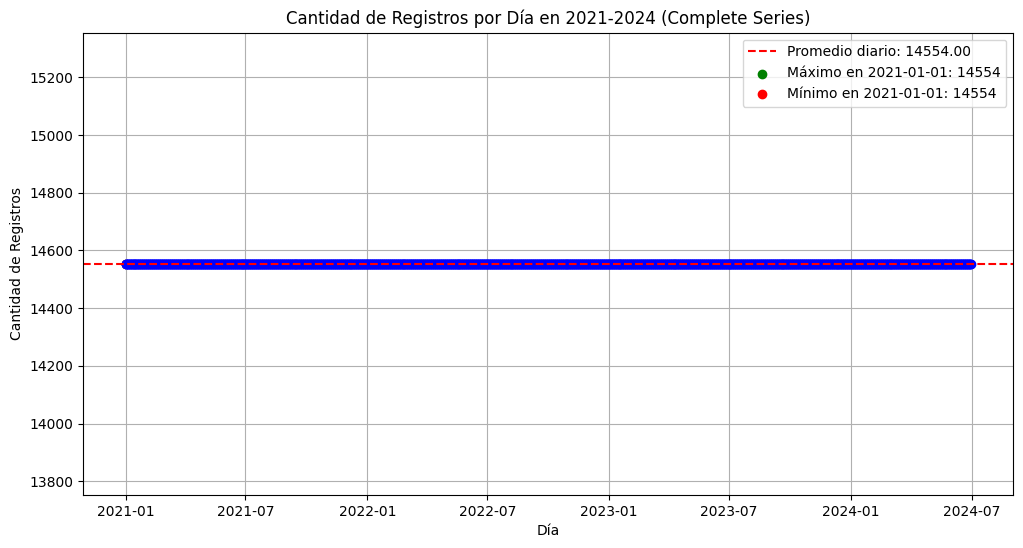

Promedio de registros por día en 2021-2024 (Complete Series): 14554.00
Día con máximo número de registros (2021-01-01): 14554
Día con mínimo número de registros (2021-01-01): 14554


In [ ]:
## DISTRIBUCIÓN DE OBERVACIONES POR DÍA ##

# Nos asegurándonos de que la columna 'Fecha' está en formato datetime
df_precios_montevideo_2021_2024_C['Fecha'] = pd.to_datetime(df_precios_montevideo_2021_2024_C['Fecha'], errors='coerce')

# Agrupamos por día y contamos los registros para los años 2021-2024 en la base "df_precios_montevideo_2021_2024_C"
registros_por_dia_C = df_precios_montevideo_2021_2024_C.groupby(df_precios_montevideo_2021_2024_C['Fecha'].dt.date).size()

# Calculamos estadísticas
promedio_diario_C = round(registros_por_dia_C.mean(),0)
max_registros_C = round(registros_por_dia_C.max(),0)
min_registros_C = round(registros_por_dia_C.min(),0)
dia_maximo_C = registros_por_dia_C.idxmax()
dia_minimo_C = registros_por_dia_C.idxmin()

# Creamos gráfico de la evolución diaria
plt.figure(figsize=(12, 6))
registros_por_dia_C.plot(kind='line', color='blue', marker='o', linestyle='-')
plt.title('Cantidad de Registros por Día en 2021-2024 (Complete Series)')
plt.xlabel('Día')
plt.ylabel('Cantidad de Registros')
plt.grid(True)

# Mostramos estadísticas en el gráfico
plt.axhline(y=promedio_diario_C, color='r', linestyle='--', label=f'Promedio diario: {promedio_diario_C:.2f}')
plt.scatter(dia_maximo_C, max_registros_C, color='green', label=f'Máximo en {dia_maximo_C}: {max_registros_C}')
plt.scatter(dia_minimo_C, min_registros_C, color='red', label=f'Mínimo en {dia_minimo_C}: {min_registros_C}')
plt.legend()

plt.show()

# Imprimir estadísticas
print(f"Promedio de registros por día en 2021-2024 (Complete Series): {promedio_diario_C:.2f}")
print(f"Día con máximo número de registros ({dia_maximo_C}): {max_registros_C}")
print(f"Día con mínimo número de registros ({dia_minimo_C}): {min_registros_C}")

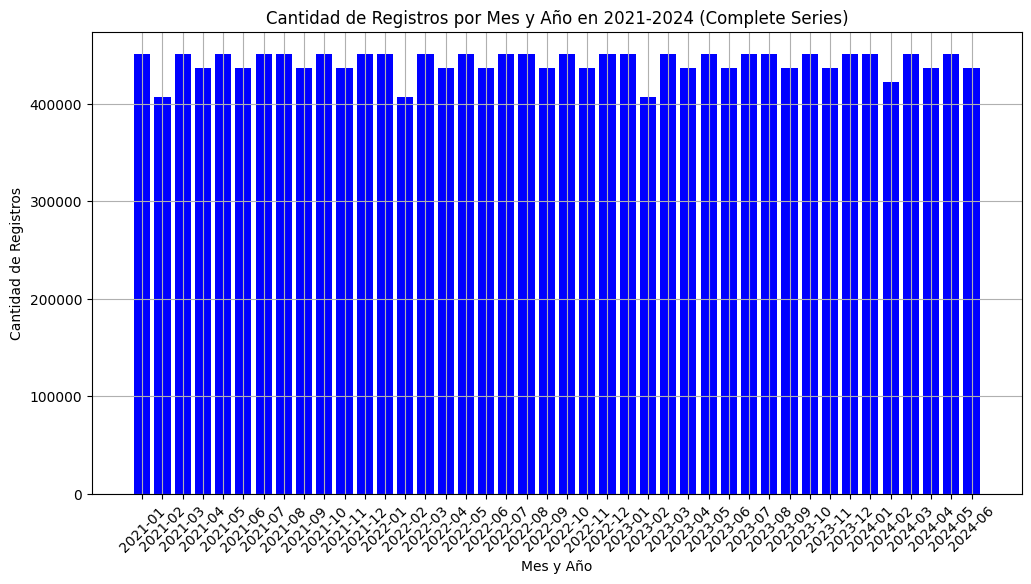

In [ ]:
## AGRUPAMIENTOS REGISTROS DE PRECIOS POR MES ##

# Agrupamos por mes y año, y contamos registros para 2021-2024 en la base "df_precios_montevideo_2021_2024_C"
registros_por_mes = df_precios_montevideo_2021_2024_C.groupby(df_precios_montevideo_2021_2024_C['Fecha'].dt.to_period('M')).size()

# Total de registros para calcular porcentajes
total_registros = registros_por_mes.sum()

# Creamos gráfico de barras de la evolución mensual para 2021-2024
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(registros_por_mes.index.astype(str), registros_por_mes, color='blue')

plt.title('Cantidad de Registros por Mes y Año en 2021-2024 (Complete Series)')
plt.xlabel('Mes y Año')
plt.ylabel('Cantidad de Registros')
plt.grid(True)
plt.xticks(rotation=45)  # Rotar las etiquetas para mejor legibilidad
plt.show()

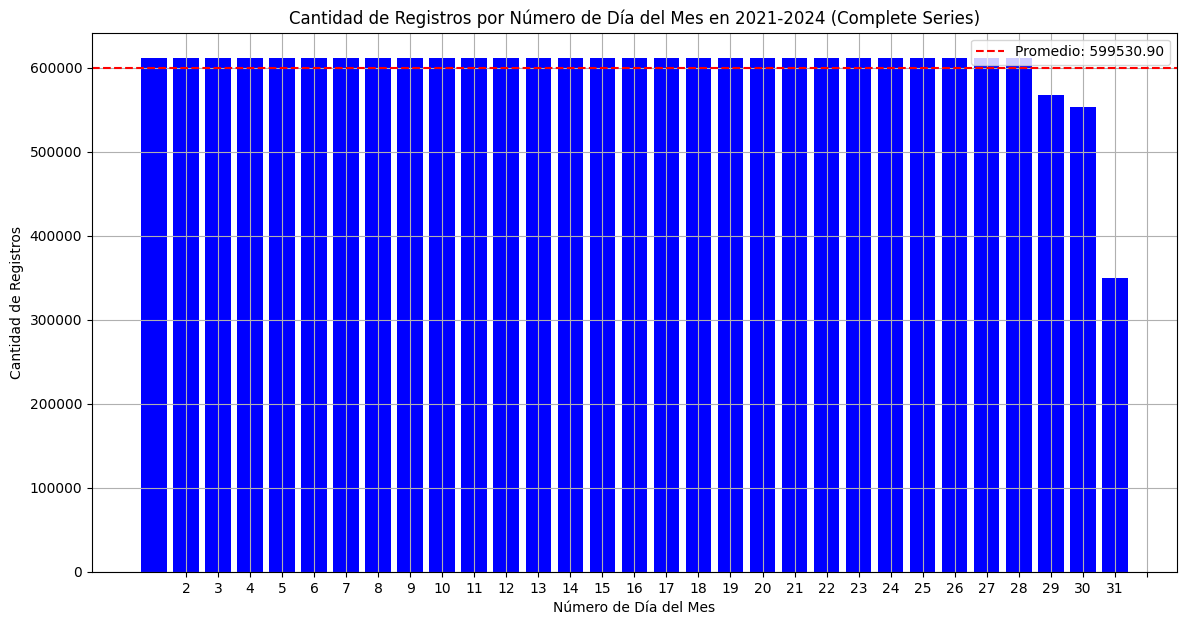

In [ ]:
## AGRUPAMIENTOS REGISTROS DE PRECIOS POR DÍA DEL MES (Excluyendo factor mes) ##

# Agrupamos por número de día del mes y contamos registros para 2021-2024 en la base "df_precios_montevideo_2021_2024_C"
registros_por_dia_del_mes = df_precios_montevideo_2021_2024_C.groupby(df_precios_montevideo_2021_2024_C['Fecha'].dt.day).size()

# Total de registros para calcular porcentajes
total_registros = registros_por_dia_del_mes.sum()

# Calculamos promedio de registros por día del mes
promedio_registros = registros_por_dia_del_mes.mean()

# Creamos gráfico de barras de la evolución por número de día del mes para 2021-2024
fig, ax = plt.subplots(figsize=(14, 7))
barras = ax.bar(registros_por_dia_del_mes.index.astype(str), registros_por_dia_del_mes, color='blue')

# Añadimos línea de promedio
ax.axhline(y=promedio_registros, color='red', linestyle='--', label=f'Promedio: {promedio_registros:.2f}')

plt.title('Cantidad de Registros por Número de Día del Mes en 2021-2024 (Complete Series)')
plt.xlabel('Número de Día del Mes')
plt.ylabel('Cantidad de Registros')
plt.grid(True)
plt.xticks(range(1, 32))  # Aseguramos de que los ticks cubran todos los días del mes
ax.legend()  # Mostramos leyenda

plt.show()

##### **1.7.1.2 Distribución <ins>productos</ins> por <ins>Rubro</ins> y <ins>Categoría</ins>**

In [ ]:
# Aseguramos que la columna 'Fecha' está en el formato datetime y extraemos el mes
df_precios_montevideo_2021_2024_C['Fecha'] = pd.to_datetime(df_precios_montevideo_2021_2024_C['Fecha'], errors='coerce')
df_precios_montevideo_2021_2024_C['Mes'] = df_precios_montevideo_2021_2024_C['Fecha'].dt.month

# Filtramos los registros con precio mayor a cero
df_precios_mayor_cero = df_precios_montevideo_2021_2024_C[df_precios_montevideo_2021_2024_C['Precio'] > 0]

# Agrupamos por Rubro y Establecimiento para contar los meses únicos con precios
conteo_meses_rubro = df_precios_mayor_cero.groupby(['Rubro', 'ID_establecimiento']).agg(
    Cantidad_Meses=('Mes', 'nunique')  # Contar la cantidad de meses únicos con precios
).reset_index()

# Agrupamos por Categoria y Establecimiento para contar los meses únicos con precios
conteo_meses_categoria = df_precios_mayor_cero.groupby(['Categoria', 'ID_establecimiento']).agg(
    Cantidad_Meses=('Mes', 'nunique')  # Contar la cantidad de meses únicos con precios
).reset_index()

# Filtramos rubros y categorías que se informaron en al menos 10 meses por establecimiento
rubros_mas_10_meses = conteo_meses_rubro[conteo_meses_rubro['Cantidad_Meses'] >= 10]
categorias_mas_10_meses = conteo_meses_categoria[conteo_meses_categoria['Cantidad_Meses'] >= 10]

# Agrupamos por Rubro para contar la cantidad de establecimientos que cumplen la condición
conteo_rubros = rubros_mas_10_meses.groupby('Rubro').agg(
    Cantidad_Centros=('ID_establecimiento', 'nunique')  # Contar la cantidad de establecimientos que cumplen la condición
).reset_index()

# Agrupamos por Categoria para contar la cantidad de establecimientos que cumplen la condición
conteo_categorias = categorias_mas_10_meses.groupby('Categoria').agg(
    Cantidad_Centros=('ID_establecimiento', 'nunique')  # Contar la cantidad de establecimientos que cumplen la condición
).reset_index()

# Renombramos columnas para claridad
conteo_rubros = conteo_rubros.rename(columns={'Cantidad_Centros': 'Centros_Informados'})
conteo_categorias = conteo_categorias.rename(columns={'Cantidad_Centros': 'Centros_Informados'})

# Calculamos el porcentaje de centros que informan sobre cada rubro y categoría
total_centros = df_precios_montevideo_2021_2024_C['ID_establecimiento'].nunique()
conteo_rubros['Porcentaje_Centros'] = round((conteo_rubros['Centros_Informados'] / total_centros) * 100, 2)
conteo_categorias['Porcentaje_Centros'] = round((conteo_categorias['Centros_Informados'] / total_centros) * 100, 2)

# Unir conteo_categorias con productos para obtener el rubro correspondiente
conteo_categorias = pd.merge(conteo_categorias, df_precios_montevideo_2021_2024_C[['Categoria', 'Rubro']].drop_duplicates(), on='Categoria', how='left')

# Reordenar las columnas de conteo_categorias
conteo_categorias = conteo_categorias[['Categoria', 'Rubro', 'Centros_Informados', 'Porcentaje_Centros']]

# Ordenar los DataFrames por Porcentaje_Centros
conteo_rubros = conteo_rubros.sort_values('Porcentaje_Centros', ascending=False)
conteo_categorias = conteo_categorias.sort_values('Porcentaje_Centros', ascending=False)

# Imprimir resultados
print("Cantidad de centros con los que se cuenta información en 2021-2024: ", total_centros)
print("\nConteo de Rubros:")
conteo_rubros.head(10)

Cantidad de centros con los que se cuenta información en 2021-2024:  289

Conteo de Rubros:


,Rubro,Centros_Informados,Porcentaje_Centros
3,Cuidado Personal,259,89.62
0,Alimentos,255,88.24
2,Bebidas sin Alcohol,240,83.04
4,Limpieza,223,77.16
1,Bebidas con Alcohol,148,51.21


In [ ]:
print("\nConteo de Categorías:")
conteo_categorias.head(10)


Conteo de Categorías:


,Categoria,Rubro,Centros_Informados,Porcentaje_Centros
16,Higiene Personal,Cuidado Personal,259,89.62
10,Estimulantes,Bebidas sin Alcohol,240,83.04
14,Gaseosas,Bebidas sin Alcohol,216,74.74
20,Limpieza de Hogar,Limpieza,215,74.39
11,Estética,Cuidado Personal,213,73.70
1,Aguas,Bebidas sin Alcohol,188,65.05
23,Primeros Auxilios,Cuidado Personal,184,63.67
24,Protección,Cuidado Personal,171,59.17
0,Aceites,Alimentos,171,59.17
12,Fideos,Alimentos,158,54.67


In [ ]:
# Mostrar el top 30 de CATEGORÍAS por porcentaje de centros informados
top_30_categorias = conteo_categorias.sort_values('Porcentaje_Centros', ascending=False).head(30)

##### **1.7.1.3  <ins>Representatividad</ins>**

In [ ]:
# Filtramos los registros con precio mayor a cero
df_precios_mayor_cero = df_precios_montevideo_2021_2024_C[df_precios_montevideo_2021_2024_C['Precio'] > 0]

# Agrupamos por Nombre y Establecimiento para contar los meses únicos con precios
conteo_meses_nombre = df_precios_mayor_cero.groupby(['Nombre', 'ID_establecimiento']).agg(
    Cantidad_Meses=('Mes', 'nunique')  # Contar la cantidad de meses únicos con precios
).reset_index()

# Filtramos nombres que se informaron en al menos 10 meses por establecimiento
nombres_mas_10_meses = conteo_meses_nombre[conteo_meses_nombre['Cantidad_Meses'] >= 10]

# Agrupamos por Nombre para contar la cantidad de establecimientos que cumplen la condición
conteo_nombres = nombres_mas_10_meses.groupby('Nombre').agg(
    Cantidad_Centros=('ID_establecimiento', 'nunique')  # Contar la cantidad de establecimientos que cumplen la condición
).reset_index()

# Calculamos el porcentaje de centros que informan sobre cada nombre
total_centros = df_precios_montevideo_2021_2024_C['ID_establecimiento'].nunique()
conteo_nombres['Porcentaje_Centros'] = round((conteo_nombres['Cantidad_Centros'] / total_centros) * 100, 2)

# Renombramos columnas para claridad
conteo_nombres = conteo_nombres.rename(columns={'Cantidad_Centros': 'Centros_Informados'})

# Unimos conteo_nombres con productos para obtener el rubro correspondiente
conteo_nombres = pd.merge(conteo_nombres, df_precios_montevideo_2021_2024_C[['Nombre', 'Rubro']].drop_duplicates(), on='Nombre', how='left')

# Clasificamos los productos en tramos de representatividad
bins = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ["0%", "1-10%", "10-20%", "20-30%", "30-40%", "40-50%", "50-60%", "60-70%", "70-80%", "80-90%", "90-100%"]
conteo_nombres['Tramo_Representatividad'] = pd.cut(conteo_nombres['Porcentaje_Centros'], bins=bins, labels=labels, right=False)

# Contamos la cantidad de productos en cada tramo y por rubro
conteo_tramos = conteo_nombres.groupby(['Tramo_Representatividad', 'Rubro']).size().unstack(fill_value=0)

# Añadimos una columna con el total de productos por tramo
conteo_tramos['Total_Productos'] = conteo_nombres['Tramo_Representatividad'].value_counts().sort_index()

# Añadimos una fila de totales
totales = conteo_tramos.sum().to_frame().T
totales.index = ['Totales']
conteo_tramos = pd.concat([conteo_tramos, totales])

# Reordenamos las columnas para que el total de productos sea la segunda columna
columnas = ['Total_Productos'] + [col for col in conteo_tramos.columns if col != 'Total_Productos']
conteo_tramos = conteo_tramos[columnas]

# Mostramos el DataFrame resultante
print(conteo_tramos)

Rubro    Total_Productos  Alimentos  Bebidas con Alcohol  Bebidas sin Alcohol  \
0%                     0          0                    0                    0   
1-10%                  0          0                    0                    0   
10-20%                34         15                    0                    7   
20-30%                36         29                    0                    0   
30-40%                26          9                    2                    2   
40-50%                32         17                    3                    4   
50-60%                13          6                    0                    1   
60-70%                 5          0                    0                    2   
70-80%                 3          0                    0                    2   
80-90%                 1          0                    0                    0   
90-100%                0          0                    0                    0   
Totales              150    

In [ ]:
# Filtramos los registros con precio mayor a cero
df_precios_mayor_cero = df_precios_montevideo_2021_2024_C[df_precios_montevideo_2021_2024_C['Precio'] > 0]

# Agrupamos por Nombre y Establecimiento para contar los meses únicos con precios
conteo_meses_nombre = df_precios_mayor_cero.groupby(['Nombre', 'ID_establecimiento']).agg(
    Cantidad_Meses=('Mes', 'nunique')  # Contamos la cantidad de meses únicos con precios
).reset_index()

# Filtramos nombres que se informaron en al menos 10 meses por establecimiento
nombres_mas_10_meses = conteo_meses_nombre[conteo_meses_nombre['Cantidad_Meses'] >= 10]

# Agrupamos por Nombre para contar la cantidad de establecimientos que cumplen la condición
conteo_nombres = nombres_mas_10_meses.groupby('Nombre').agg(
    Cantidad_Centros=('ID_establecimiento', 'nunique')  # Contamos la cantidad de establecimientos que cumplen la condición
).reset_index()

# Calculamos el porcentaje de centros que informan sobre cada nombre
total_centros = df_precios_montevideo_2021_2024_C['ID_establecimiento'].nunique()
conteo_nombres['Porcentaje_Centros'] = round((conteo_nombres['Cantidad_Centros'] / total_centros) * 100, 2)

# Renombramos columnas para claridad
conteo_nombres = conteo_nombres.rename(columns={'Cantidad_Centros': 'Centros_Informados'})

# Unimos conteo_nombres con productos para obtener el rubro correspondiente
conteo_nombres = pd.merge(conteo_nombres, productos[['Nombre', 'Rubro']].drop_duplicates(), on='Nombre', how='left')

# Seleccionamos las columnas deseadas
productos_informados = conteo_nombres[['Nombre', 'Rubro', 'Centros_Informados', 'Porcentaje_Centros']]

# Mostramos el DataFrame resultante ordenado por porcentaje de centros
productos_informados = productos_informados.sort_values('Porcentaje_Centros', ascending=False)

productos_informados.tail(20)

,Nombre,Rubro,Centros_Informados,Porcentaje_Centros
111,Papel higiénico hoja simple Sin Fin 4 rollos d...,Cuidado Personal,43,14.88
6,Aceite de soja Río de la Plata Envase 900 cc,Alimentos,43,14.88
9,Agua de mesa con gas Matutina Envase 2 lt.,Bebidas sin Alcohol,43,14.88
5,Aceite de soja Condesa Envase 900 cc,Alimentos,42,14.53
27,Café envasado (no instantáneo) Águila Paquete ...,Bebidas sin Alcohol,41,14.19
40,Cocoa Copacabana Envase 500 grs.,Bebidas sin Alcohol,41,14.19
41,Cocoa Vascolet Envase 500 grs.,Bebidas sin Alcohol,40,13.84
79,Huevos colorados Super huevo Envase 1/2 docena,Alimentos,38,13.15
97,Margarina Doriana nueva Envase 250 grs.,Alimentos,38,13.15
85,Jabón de tocador Rexona Unidad 125 grs.,Cuidado Personal,36,12.46


In [ ]:
# Contamos la cantidad única de establecimientos informados
cantidad_establecimientos = df_precios_montevideo_2021_2024_C['ID_establecimiento'].nunique()

# Contamos la cantidad única de nombres de productos informados
cantidad_nombres_productos = df_precios_montevideo_2021_2024_C['Nombre'].nunique()

# Imprimimos los resultados
print(f"Cantidad única de establecimientos informados: {cantidad_establecimientos}")
print(f"Cantidad única de nombres de productos informados: {cantidad_nombres_productos}")

Cantidad única de establecimientos informados: 289
Cantidad única de nombres de productos informados: 150


##### **1.7.1.4  <ins>Relación Centros y Productos</ins>**

###### **1.7.1.4.1** **Matriz de confusión**: <ins>Departamentos</ins> y <ins>Rubros</ins>

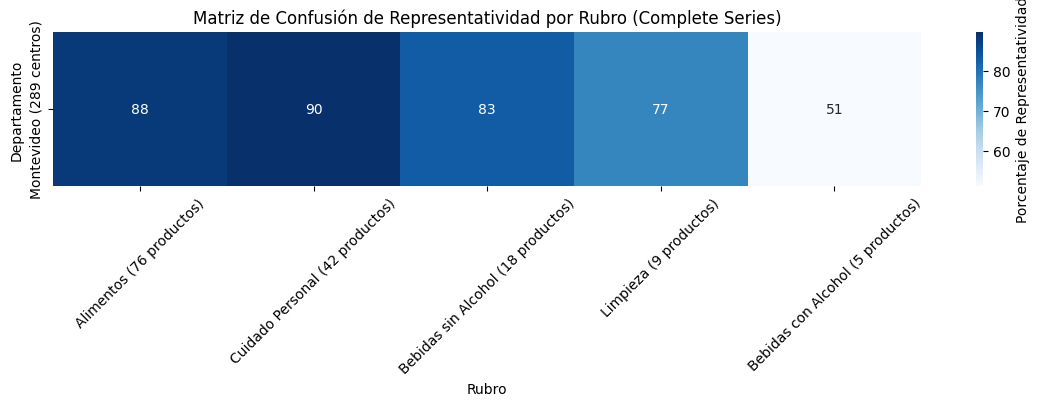

In [ ]:
### MATRIZ DE CONFUSIÓN: DEPARTAMENTOS Y RUBROS ###

# Filtramos los registros con precio mayor a cero
df_precios_mayor_cero_C = df_precios_montevideo_2021_2024_C[df_precios_montevideo_2021_2024_C['Precio'] > 0]

# Agrupamos por Departamento, Rubro y Establecimiento para contar los meses únicos con precios
conteo_meses_C = df_precios_mayor_cero_C.groupby(['Departamento', 'Rubro', 'ID_establecimiento']).agg(
    Cantidad_Meses=('Mes', 'nunique')  # Contamos la cantidad de meses únicos con precios
).reset_index()

# Filtramos aquellos que se informaron en al menos 10 meses por establecimiento
conteo_meses_C = conteo_meses_C[conteo_meses_C['Cantidad_Meses'] >= 10]

# Agrupamos por Departamento y Rubro para contar la cantidad de establecimientos que cumplen la condición
conteo_rubro_depto_C = conteo_meses_C.groupby(['Departamento', 'Rubro']).agg(
    Cantidad_Centros=('ID_establecimiento', 'nunique')  # Contamos la cantidad de establecimientos que cumplen la condición
).reset_index()

# Calculamos el total de centros por departamento
total_centros_depto_C = conteo_meses_C.groupby('Departamento')['ID_establecimiento'].nunique().reset_index()
total_centros_depto_C = total_centros_depto_C.rename(columns={'ID_establecimiento': 'Total_Centros'})

# Unimos para tener el total de centros por departamento
conteo_rubro_depto_C = conteo_rubro_depto_C.merge(total_centros_depto_C, on='Departamento', how='left')

# Calculamos el porcentaje de representatividad
conteo_rubro_depto_C['Porcentaje_Representatividad'] = (conteo_rubro_depto_C['Cantidad_Centros'] / conteo_rubro_depto_C['Total_Centros']) * 100

# Convertimos las columnas a tipo str antes de concatenarlas
conteo_rubro_depto_C['Departamento'] = conteo_rubro_depto_C['Departamento'].astype(str) + " (" + conteo_rubro_depto_C['Total_Centros'].astype(str) + " centros)"
conteo_rubro_depto_C['Rubro'] = conteo_rubro_depto_C['Rubro'].astype(str)

# Calculamos el total de productos por rubro
total_productos_rubro_C = df_precios_mayor_cero_C.groupby('Rubro')['Nombre'].nunique().reset_index()
total_productos_rubro_C = total_productos_rubro_C.rename(columns={'Nombre': 'Total_Productos'})

# Unimos para tener el total de productos por rubro
conteo_rubro_depto_C = conteo_rubro_depto_C.merge(total_productos_rubro_C, on='Rubro', how='left')

# Incluimos la cantidad de productos en el nombre de los rubros
conteo_rubro_depto_C['Rubro'] = conteo_rubro_depto_C['Rubro'] + " (" + conteo_rubro_depto_C['Total_Productos'].astype(str) + " productos)"

# Pivotamos el DataFrame para tener la matriz de confusión con porcentajes, pero solo para el departamento único
matriz_confusion_C = conteo_rubro_depto_C.pivot(index='Departamento', columns='Rubro', values='Porcentaje_Representatividad').fillna(0)

# Ordenamos los rubros por la cantidad de productos
rubros_ordenados_C = sorted(matriz_confusion_C.columns, key=lambda x: int(x.split("(")[1].split()[0]), reverse=True)
matriz_confusion_C = matriz_confusion_C.loc[:, rubros_ordenados_C]

# Mostramos la fila correspondiente al departamento único
matriz_confusion_C_single_dept = matriz_confusion_C.iloc[0:1, :]

# Creamos el gráfico de matriz de confusión con la única fila del departamento
plt.figure(figsize=(14, 2))  # Ajustamos el tamaño del gráfico para mostrar solo una fila
sns.heatmap(matriz_confusion_C_single_dept, annot=True, fmt=".0f", cmap="Blues", cbar_kws={'label': 'Porcentaje de Representatividad'})

plt.title('Matriz de Confusión de Representatividad por Rubro (Complete Series)')
plt.ylabel('Departamento')
plt.xlabel('Rubro')
plt.xticks(rotation=45)
plt.show()

###### **1.7.1.4.2** **Matriz de confusión**: <ins>Departamentos</ins> y <ins>Categorías</ins>

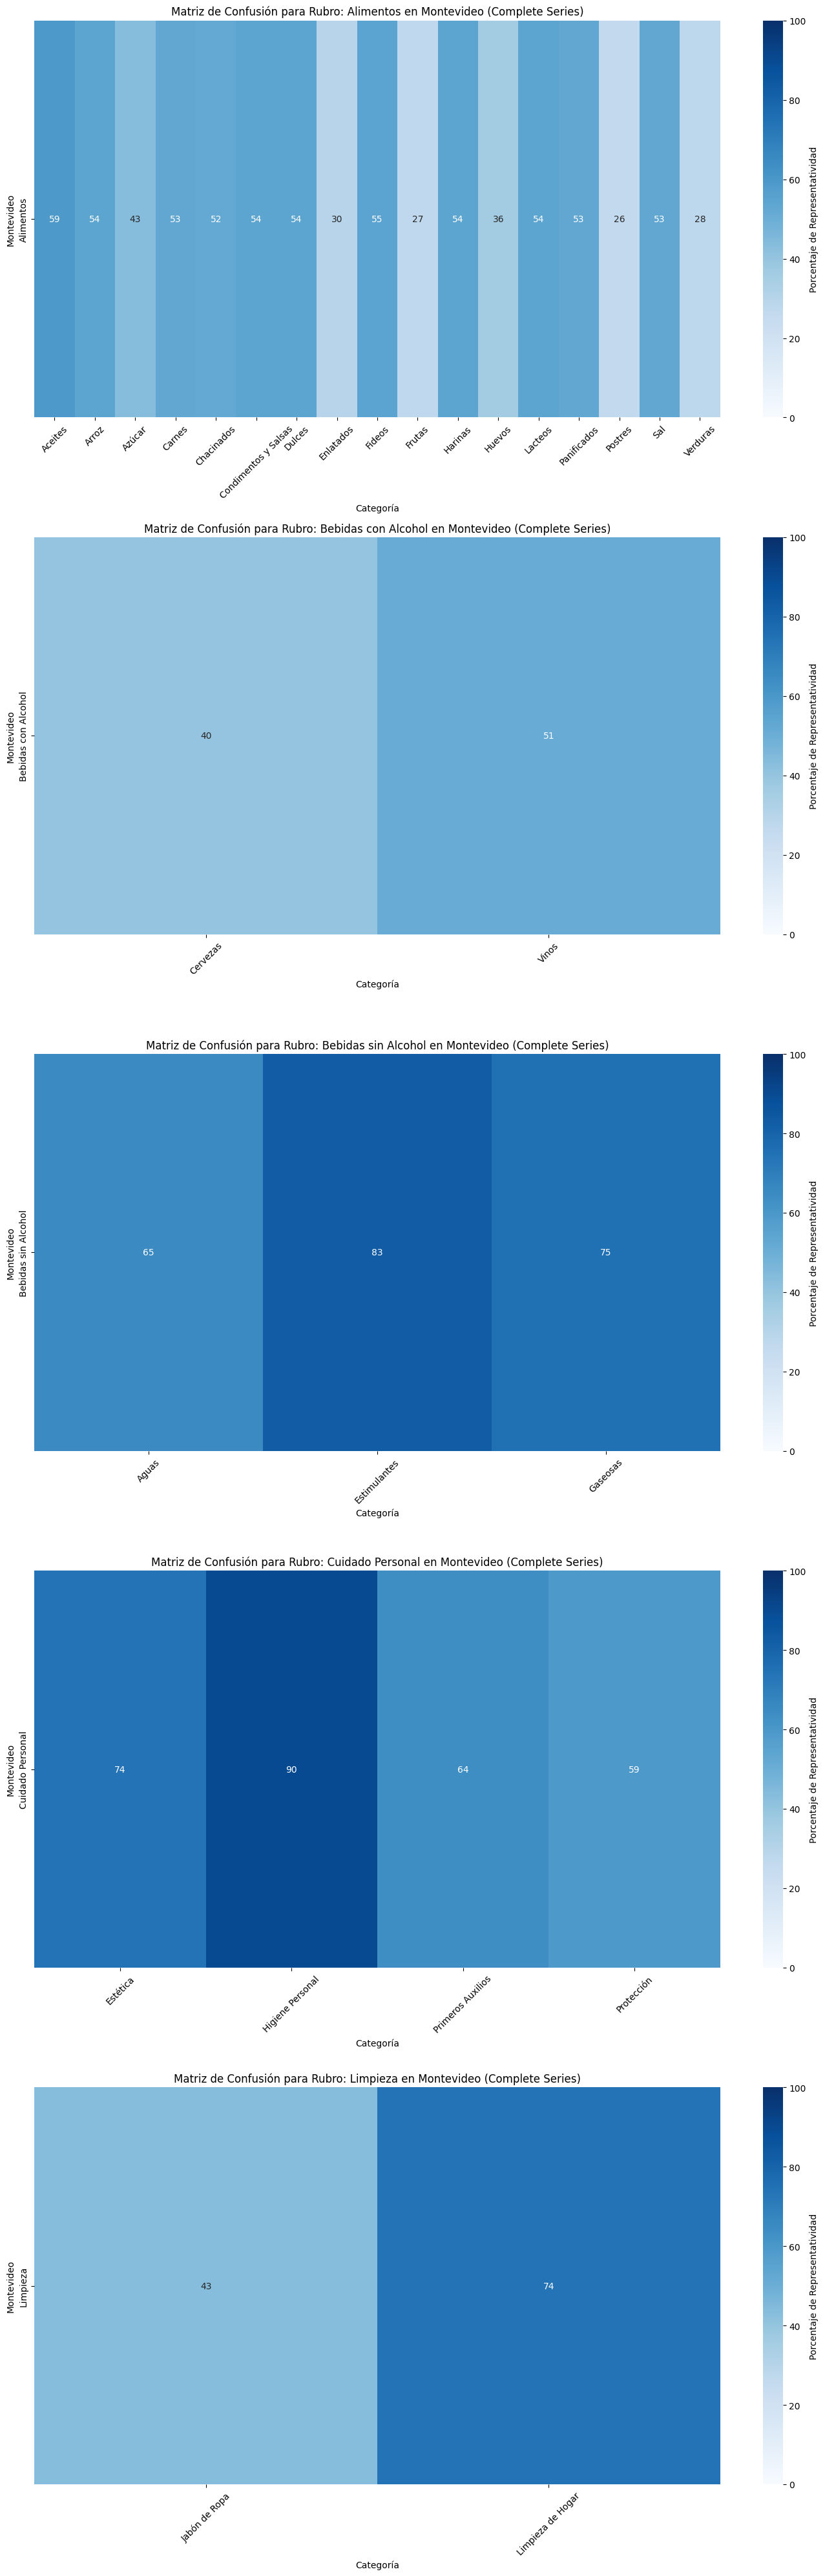

In [ ]:
### MATRIZ DE CONFUSIÓN: MONTEVIDEO Y CATEGORÍAS (Por Categoría) ###

# Filtramos los registros con precio mayor a cero y que correspondan solo a Montevideo
df_precios_mayor_cero_C = df_precios_montevideo_2021_2024_C[
    (df_precios_montevideo_2021_2024_C['Precio'] > 0) &
    (df_precios_montevideo_2021_2024_C['Departamento'] == 'Montevideo')
]

# Agrupamos por Rubro, Categoria y Establecimiento para contar los meses únicos con precios
conteo_meses_C = df_precios_mayor_cero_C.groupby(['Rubro', 'Categoria', 'ID_establecimiento']).agg(
    Cantidad_Meses=('Mes', 'nunique')
).reset_index()

# Filtramos aquellos que se informaron en al menos 10 meses por establecimiento
conteo_meses_C = conteo_meses_C[conteo_meses_C['Cantidad_Meses'] >= 10]

# Calculamos la cantidad de establecimientos que informan por cada categoría
conteo_categoria_C = conteo_meses_C.groupby(['Rubro', 'Categoria']).agg(
    Establecimientos_Informan=('ID_establecimiento', 'nunique')
).reset_index()

# Calculamos el total de centros en Montevideo
total_centros_C = df_precios_mayor_cero_C['ID_establecimiento'].nunique()

# Calculamos el porcentaje de representatividad por categoría
conteo_categoria_C['Porcentaje_Representatividad'] = (conteo_categoria_C['Establecimientos_Informan'] / total_centros_C) * 100

# Redondeamos los porcentajes a cero decimales
conteo_categoria_C['Porcentaje_Representatividad'] = conteo_categoria_C['Porcentaje_Representatividad'].round(0)

# Obtener todos los rubros únicos
rubros_unicos = conteo_categoria_C['Rubro'].unique()

# Crear subplots para cada rubro
fig, axes = plt.subplots(nrows=len(rubros_unicos), ncols=1, figsize=(14, 8 * len(rubros_unicos)))

# Si hay un solo rubro, convertir `axes` en una lista para iterar
if len(rubros_unicos) == 1:
    axes = [axes]

# Iterar sobre cada rubro para crear su matriz de confusión
for ax, rubro in zip(axes, rubros_unicos):
    # Filtrar el DataFrame por rubro
    matriz_rubro_C = conteo_categoria_C[conteo_categoria_C['Rubro'] == rubro].pivot(
        index='Rubro', columns='Categoria', values='Porcentaje_Representatividad'
    ).fillna(0)

    # Crear el heatmap para el rubro actual
    sns.heatmap(matriz_rubro_C, annot=True, fmt=".0f", cmap="Blues", cbar_kws={'label': 'Porcentaje de Representatividad'}, ax=ax, vmin=0, vmax=100)

    # Configurar el título y etiquetas del gráfico
    ax.set_title(f'Matriz de Confusión para Rubro: {rubro} en Montevideo (Complete Series)')
    ax.set_ylabel('Montevideo')
    ax.set_xlabel('Categoría')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()